## Using the 2nd order slaved Adams-Bashforth scheme

Given an ODE: $$\frac{dq}{dt} = -\alpha q+f(t)$$
the following expression is exactly true: $$e^{\alpha |t+\delta t|}q(t+\delta t)-e^{\alpha t}q(t) = \int_t^{t+\delta t}e^{\alpha s}f(s)ds $$
The slaved Adams Bashforth scheme of integration is obtained by writing a similar equation involving $q(t)$ and $q(t-\delta t)$, and then adding them up, which yields the exact relation: $$q(t+\delta t) = e^{-2\alpha\delta t}q(t-\delta t)+\int_{t-\delta t}^{t+\delta t}e^{-\alpha|t+\delta t-s|}f(s)ds$$
Finally, replacing $f(s)$ under the integral, we obtain the slaved Adams-Bashforth scheme: $$q_{n+1} = e^{-2\alpha \delta t}q_{n-1}+\frac{1-e^{-2\alpha\delta t}}{\alpha}\left[\frac{3}{2}f_n-\frac{1}{2}f_{n-1}\right]$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

### MHD Shell model equations without the ionic term and without forcing

In [2]:
def f(Y, t, n):
    '''
    Y: complex vector representing u_n / b_n at a given time t
    n: shell number
    Returns the non-linear term according to the MHD shell model system of equations
    '''
    
    X = Y[:]    
    if n in range(N):  #for the u terms
        #taking care of the boundary terms
        if n==0:
            phi_u = k[0]*(X[1]*X[2]-X[N+1]*X[N+2])     
        elif n==1:
            phi_u = k[1]*(X[2]*X[3]-X[N+2]*X[N+3])-0.5*k[0]*(X[0]*X[2]-X[N]*X[N+2])
        elif n==N-2:
            phi_u = -0.5*k[n-1]*(X[n-1]*X[n+1]-X[N+n-1]*X[N+n+1])-0.5*k[n-2]*(X[n-2]*X[n-1]-X[N+n-2]*X[N+n-1])
        elif n==N-1:
            phi_u = -0.5*k[n-2]*(X[n-2]*X[n-1]-X[N+n-2]*X[N+n-1]) 
        else:
            phi_u = k[n]*(X[n+1]*X[n+2]-X[N+n+1]*X[N+n+2])-0.5*k[n-1]*(X[n-1]*X[n+1]-X[N+n-1]*X[N+n+1])-0.5*k[n-2]*(X[n-2]*X[n-1]-X[N+n-2]*X[N+n-1])
        
        yNLT = 1j*phi_u.conjugate()
        
    if n in range(N,2*N):  #for the b terms
        #taking care of the boundary terms
        if n==N:
            phi_b = (1./6.)*k[0]*(X[1]*X[N+2]-X[N+1]*X[2])   
        elif n==N+1:
            phi_b = (1./6.)*k[1]*(X[2]*X[N+3]-X[N+2]*X[3])+(1./3.)*k[0]*(X[0]*X[N+2]-X[N]*X[2])
        elif n==2*N-2:
            phi_b = (1./3.)*k[n-1-N]*(X[n-1-N]*X[n+1]-X[n-1]*X[n+1-N])-(2./3.)*k[n-2-N]*(X[n-2-N]*X[n-1]-X[n-2]*X[n-1-N])
        elif n==2*N-1:
            phi_b = -(2./3.)*k[n-2-N]*(X[n-2-N]*X[n-1]-X[n-2]*X[n-1-N])    
        else:
            phi_b = (1./6.)*k[n-N]*(X[n+1-N]*X[n+2]-X[n+1]*X[n+2-N])+(1./3.)*k[n-1-N]*(X[n-1-N]*X[n+1]-X[n-1]*X[n+1-N])-(2./3.)*k[n-2-N]*(X[n-2-N]*X[n-1]-X[n-2]*X[n-1-N])
       
        yNLT = 1j*phi_b.conjugate()

    return yNLT


In [3]:
def slavedAdBash(t0, tn, n, y0):
    '''
    t0: initial time
    tn: final time
    n : number of time slices
    y0: initial configuration vector
    y : returns the configuration
    '''
    dt = abs(tn-t0)/n
    t = np.linspace(t0,tn,n+1)
    y = np.zeros([n+1,len(y0)],dtype=complex)
    y[0] = y0
    
    for i in range(0,n): #i denotes the time slice  
        for j in range(len(y0)):   #j denotes the shell
            if j<N:
                al = nu*k[j]*k[j]+nu2*pow(k[j],4)
            elif j>=N:
                al = eta*k[j-N]*k[j-N]+eta2*pow(k[j-N],4)
            ex = np.exp(-2*al*dt)
            y[i+1][j] = ex*y[i][j]+(1.5*f(y[i],t[i],j)-0.5*f(y[i-1],t[i-1],j))*(1-ex)/al             
    return y

### Driver code

In [4]:
start_time = time.time()
Nr = 1 #number of realizations
N = 25 #number of shells

nu = 10**(-5) #kinematic viscosity
eta = 10**(-5) #magnetic diffusivity
nu2 = 5.*10**(-13) #hyperviscosity
eta2 = 5.*10**(-13) #magnetic hyperdiffusivity
k0 = 1./16.
u0 = 0.1
b0 = 0.1

n = 10**6 #number of time slices
t0 = 0 #initial time
tn = 20 #final time
t = np.linspace(t0,tn,n+1)

#initializing the k vector
k=[]
for i in range(1,N+1):
    k.append(k0*(2**i))

uf,bf = [],[]
for _ in range(Nr):
    #initialization of the vectors u,b
    ui,bi = [],[]
    phi_u = np.random.uniform(-np.pi,np.pi,N)
    phi_b = np.random.uniform(-np.pi,np.pi,N)
    for i in range(N):
        kn = k[i]
        un = u0*kn**(-1./3.)*np.exp(-kn*kn+1j*phi_u[i])
        bn = b0*kn**(-1./3.)*np.exp(-kn*kn+1j*phi_b[i])
        ui.append(un)
        bi.append(bn)
    
    #initial configuration
    y0 = ui+bi
    
    #Solving the 2N differential equations using Adams-Bashforth slaved scheme
    ysol = slavedAdBash(t0,tn,n,y0)
    un, bn = [],[] #every element of un,bn stores the absolute values of a configuration at a given time
    for i in range(len(ysol)):
        un.append(np.abs(ysol[i][:N]))
        bn.append(np.abs(ysol[i][N:]))
    
    #every element of uf,bf is a realization
    uf.append(un)
    bf.append(bn)

#every element i of u / b gives the configuration at ith time averaged over all realizations
u = np.mean(uf,axis = 0)
b = np.mean(bf,axis = 0)

end_time = time.time()
print('Time taken = ', end_time-start_time)

/home/uddeepta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in cdouble_scalars
/home/uddeepta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in cdouble_scalars
/home/uddeepta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in cdouble_scalars
  app.launch_new_instance()
/home/uddeepta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in cdouble_scalars
  app.launch_new_instance()
/home/uddeepta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in cdouble_scalars
/home/uddeepta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in cdouble_scalars
/home/uddeepta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in 

Time taken =  1278.5063953399658


### Energy

In [5]:
Eu = np.zeros(n+1) #total energy at given time summed over all shells
Eb = np.zeros(n+1)
et = np.zeros(n+1)
for i in range(n+1):
    for j in range(N):
        enu = 0.5*u[i][j]*u[i][j]/k[j]
        enb = 0.5*b[i][j]*b[i][j]/k[j]
        Eu[i]+=enu
        Eb[i]+=enb
        et[i]+=enu+enb

/home/uddeepta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in double_scalars
  
/home/uddeepta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in double_scalars
  import sys


/home/uddeepta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  import sys


(1.0898946632821984e-11, 10000000000)

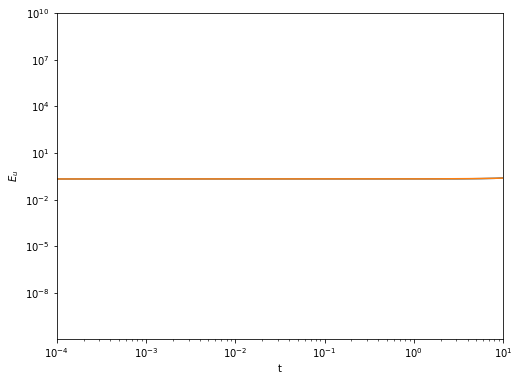

In [10]:
plt.figure(figsize = (8,6))
plt.loglog(t,Eu)
plt.loglog(t,Eb)
plt.xlabel('t')
plt.ylabel(r'$E_u$')


In [48]:
for i in range(len(Eu)):
    print(Eu[i],Eb[i])

5.2464413321763335 0.05246441332176335
5.246404288787503 0.05246441819313393
5.246379591320766 0.05246442144885846
5.246354893654367 0.052464424712139336
5.2463301955156965 0.052464427983097355
5.246305496904752 0.052464431261732725
5.246280797821534 0.05246443454804564
5.246256098266041 0.0524644378420363
5.246231398238277 0.05246444114370486
5.246206697738234 0.05246444445305158
5.2461819967659205 0.05246444777007661
5.246157295321328 0.052464451094780186
5.246132593404461 0.05246445442716248
5.246107891015319 0.052464457767223686
5.246083188153897 0.052464461114963994
5.2460584848202005 0.05246446447038364
5.246033781014226 0.052464467833482784
5.246009076735974 0.05246447120426163
5.245984371985444 0.0524644745827204
5.245959666762635 0.052464477968859224
5.245934961067546 0.05246448136267837
5.245910254900179 0.052464484764178004
5.24588554826053 0.05246448817335832
5.245860841148602 0.052464491590219535
5.245836133564393 0.052464495014761824
5.2458114255079025 0.0524644984469854


5.227673559228194 0.052469057098558404
5.227648506298802 0.05246906619024239
5.227623452896834 0.052469075289750006
5.22759839902229 0.052469084397081436
5.227573344675169 0.05246909351223686
5.227548289855472 0.05246910263521651
5.227523234563196 0.05246911176602054
5.227498178798344 0.052469120904649155
5.227473122560911 0.052469130051102555
5.2274480658509015 0.052469139205380946
5.227423008668311 0.052469148367484474
5.227397951013141 0.05246915753741336
5.227372892885393 0.05246916671516781
5.227347834285064 0.052469175900748
5.227322775212152 0.05246918509415412
5.227297715666663 0.05246919429538637
5.22727265564859 0.05246920350444494
5.227247595157935 0.05246921272133003
5.227222534194696 0.05246922194604184
5.227197472758877 0.05246923117858054
5.227172410850473 0.05246924041894634
5.227147348469487 0.0524692496671394
5.227122285615916 0.052469258923159956
5.2270972222897605 0.05246926818700818
5.227072158491021 0.05246927745868428
5.227047094219696 0.05246928673818841
5.22702

5.203838694778712 0.05248113212219855
5.2038131960317004 0.052481148676425136
5.2037876968117365 0.052481165238654696
5.203762197118817 0.052481181808887424
5.203736696952942 0.05248119838712352
5.203711196314109 0.052481214973363145
5.203685695202322 0.05248123156760652
5.203660193617575 0.05248124816985382
5.203634691559874 0.05248126478010525
5.203609189029214 0.05248128139836094
5.203583686025597 0.05248129802462111
5.203558182549022 0.05248131465888597
5.2035326785994895 0.05248133130115569
5.203507174176996 0.05248134795143046
5.203481669281542 0.05248136460971047
5.20345616391313 0.0524813812759959
5.203430658071757 0.05248139795028694
5.2034051517574245 0.05248141463258377
5.20337964497013 0.052481431322886594
5.203354137709874 0.05248144802119559
5.203328629976655 0.05248146472751093
5.203303121770476 0.052481481441832824
5.203277613091334 0.05248149816416146
5.203252103939228 0.05248151489449701
5.203226594314159 0.05248153163283967
5.203201084216124 0.05248154837918963
5.203

5.176804465428923 0.052502957299468106
5.176778469859091 0.052502982359016376
5.176752473815881 0.052503007426761394
5.1767264772993 0.05250303250270333
5.17670048030934 0.052503057586842365
5.176674482846007 0.05250308267917868
5.176648484909297 0.05250310777971245
5.17662248649921 0.05250313288844389
5.176596487615745 0.052503158005373134
5.1765704882589025 0.0525031831305004
5.176544488428684 0.05250320826382584
5.176518488125088 0.052503233405349646
5.176492487348112 0.05250325855507203
5.176466486097757 0.05250328371299311
5.17644048437402 0.05250330887911313
5.176414482176908 0.05250333405343223
5.1763884795064135 0.05250335923595062
5.176362476362539 0.052503384426668444
5.176336472745282 0.05250340962558594
5.176310468654646 0.05250343483270324
5.176284464090625 0.05250346004802056
5.176258459053225 0.052503485271538045
5.1762324535424415 0.0525035105032559
5.176206447558274 0.0525035357431743
5.176180441100724 0.05250356099129342
5.176154434169789 0.05250358624761347
5.1761284

5.151048742316983 0.0525315422182433
5.15102228170138 0.05253157541341374
5.150995820612013 0.05253160861695613
5.150969359048877 0.05253164182887062
5.1509428970119755 0.05253167504915743
5.150916434501309 0.0525317082778167
5.150889971516872 0.052531741514848615
5.150863508058671 0.05253177476025335
5.1508370441267015 0.05253180801403109
5.150810579720962 0.052531841276182
5.150784114841454 0.05253187454670625
5.150757649488179 0.052531907825604025
5.150731183661131 0.05253194111287548
5.150704717360317 0.052531974408520817
5.150678250585732 0.052532007712540206
5.150651783337373 0.052532041024933814
5.1506253156152475 0.052532074345701826
5.150598847419346 0.0525321076748444
5.1505723787496756 0.05253214101236173
5.150545909606233 0.05253217435825396
5.150519439989018 0.05253220771252132
5.1504929698980275 0.05253224107516396
5.150466499333265 0.05253227444618202
5.150440028294729 0.052532307825575726
5.150413556782416 0.052532341213345234
5.150387084796332 0.05253237460949072
5.150

5.124055108532285 0.05256940670902378
5.12402816873752 0.05256944845666021
5.124001228468592 0.05256949021284258
5.123974287725496 0.05256953197757108
5.123947346508236 0.05256957375084586
5.1239204048168085 0.05256961553266707
5.123893462651213 0.052569657323034924
5.12386652001145 0.05256969912194958
5.123839576897519 0.052569740929411184
5.123812633309419 0.052569782745419916
5.123785689247153 0.05256982456997594
5.123758744710718 0.052569866403079424
5.123731799700109 0.05256990824473057
5.123704854215335 0.05256995009492949
5.123677908256388 0.05256999195367641
5.123650961823274 0.05257003382097147
5.123624014915988 0.05257007569681483
5.1235970675345275 0.05257011758120668
5.123570119678897 0.05257015947414718
5.123543171349096 0.052570201375636484
5.123516222545122 0.052570243285674785
5.123489273266973 0.05257028520426224
5.123462323514652 0.05257032713139901
5.123435373288157 0.05257036906708528
5.123408422587489 0.05257041101132122
5.123381471412645 0.05257045296410697
5.1233

5.095534551084143 0.05261792952949652
5.095507113674062 0.0526179803333331
5.095479675789402 0.052618031145889
5.095452237430167 0.05261808196716438
5.095424798596353 0.05261813279715942
5.095397359287962 0.05261818363587425
5.095369919504993 0.05261823448330903
5.095342479247446 0.05261828533946395
5.09531503851532 0.05261833620433917
5.095287597308616 0.052618387077934835
5.09526015562733 0.05261843796025113
5.095232713471467 0.05261848885128817
5.0952052708410225 0.052618539751046155
5.095177827735997 0.05261859065952526
5.095150384156391 0.0526186415767256
5.095122940102204 0.052618692502647384
5.0950954955734336 0.05261874343729072
5.095068050570082 0.05261879438065582
5.095040605092147 0.05261884533274283
5.095013159139631 0.05261889629355191
5.094985712712529 0.052618947263083214
5.0949582658108445 0.052618998241336895
5.094930818434575 0.05261904922831316
5.094903370583724 0.05261910022401211
5.094875922258285 0.05261915122843394
5.09484847345826 0.052619202241578816
5.09482102

5.0696454172727545 0.05266931912429182
5.0696175354896695 0.05266937815920415
5.069589653231648 0.05266943720298407
5.069561770498688 0.0526694962556317
5.069533887290788 0.05266955531714722
5.069506003607948 0.05266961438753077
5.069478119450169 0.052669673466782536
5.06945023481745 0.05266973255490263
5.069422349709792 0.05266979165189124
5.069394464127194 0.05266985075774851
5.069366578069651 0.052669909872474586
5.069338691537171 0.052669968996069634
5.069310804529748 0.05267002812853381
5.069282917047382 0.05267008726986726
5.0692550290900735 0.052670146420070126
5.06922714065782 0.0526702055791426
5.069199251750627 0.05267026474708481
5.069171362368487 0.05267032392389692
5.069143472511405 0.05267038310957908
5.0691155821793785 0.05267044230413146
5.069087691372405 0.052670501507554195
5.069059800090487 0.052670560719847444
5.069031908333623 0.05267061994101135
5.069004016101814 0.0526706791710461
5.068976123395058 0.05267073840995182
5.068948230213356 0.0526707976577287
5.068920

5.063248089458447 0.05268306992155032
5.063220098904567 0.05268313099117036
5.063192107875662 0.052683192069693276
5.063164116371731 0.05268325315711922
5.063136124392778 0.05268331425344838
5.063108131938794 0.052683375358680895
5.0630801390097835 0.05268343647281692
5.063052145605746 0.052683497595856554
5.063024151726679 0.052683558727800034
5.062996157372585 0.05268361986864747
5.062968162543465 0.05268368101839902
5.062940167239313 0.05268374217705486
5.062912171460131 0.052683803344615095
5.062884175205921 0.05268386452107991
5.062856178476681 0.05268392570644947
5.062828181272407 0.05268398690072393
5.062800183593106 0.0526840481039034
5.0627721854387735 0.0526841093159881
5.062744186809408 0.052684170536978096
5.06271618770501 0.05268423176687361
5.062688188125582 0.05268429300567477
5.06266018807112 0.052684354253381756
5.062632187541624 0.05268441550999468
5.062604186537093 0.052684476775513724
5.062576185057532 0.05268453804993901
5.062548183102932 0.05268459933327074
5.0625

5.040902377466946 0.052734306468073755
5.040874010098746 0.05273437464524819
5.0408456422552215 0.05273444283144481
5.040817273936373 0.05273451102666383
5.040788905142198 0.05273457923090533
5.040760535872694 0.052734647444169516
5.040732166127865 0.05273471566645653
5.0407037959077075 0.05273478389776647
5.040675425212225 0.052734852138099544
5.040647054041414 0.05273492038745587
5.040618682395274 0.05273498864583558
5.040590310273806 0.052735056913238855
5.04056193767701 0.05273512518966581
5.040533564604882 0.05273519347511663
5.040505191057426 0.05273526176959144
5.04047681703464 0.05273533007309038
5.040448442536524 0.05273539838561361
5.040420067563077 0.05273546670716126
5.040391692114297 0.05273553503773352
5.040363316190187 0.05273560337733048
5.040334939790746 0.052735671725952324
5.040306562915971 0.0527357400835992
5.040278185565865 0.05273580845027124
5.040249807740421 0.05273587682596861
5.040221429439648 0.05273594521069143
5.040193050663542 0.052736013604439864
5.04016

5.021531504284716 0.05278268311092099
5.021502814085136 0.05278275744775173
5.021474123409979 0.05278283179370317
5.021445432259245 0.05278290614877537
5.021416740632936 0.052782980512968536
5.021388048531046 0.05278305488628279
5.02135935595358 0.052783129268718275
5.021330662900532 0.05278320366027511
5.021301969371908 0.05278327806095347
5.021273275367705 0.052783352470753504
5.021244580887919 0.052783426889675314
5.021215885932558 0.05278350131771906
5.021187190501613 0.0527835757548849
5.021158494595088 0.05278365020117295
5.021129798212981 0.05278372465658338
5.0211011013552955 0.05278379912111631
5.021072404022026 0.05278387359477189
5.021043706213174 0.05278394807755026
5.021015007928741 0.05278402256945158
5.020986309168724 0.052784097070475974
5.020957609933122 0.05278417158062359
5.020928910221939 0.05278424609989456
5.020900210035172 0.05278432062828902
5.020871509372818 0.05278439516580713
5.020842808234883 0.05278446971244905
5.020814106621361 0.05278454426821487
5.020785

5.002840544314148 0.05283277169373969
5.002811545864625 0.05283285197025663
5.002782546939295 0.05283293225598485
5.002753547538152 0.052833012550924534
5.002724547661197 0.05283309285507576
5.00269554730843 0.05283317316843875
5.0026665464798485 0.052833253491013574
5.002637545175455 0.05283333382280038
5.002608543395249 0.05283341416379934
5.002579541139227 0.052833494514010544
5.002550538407393 0.05283357487343416
5.00252153519974 0.0528336552420703
5.002492531516277 0.052833735619919116
5.002463527356995 0.05283381600698076
5.002434522721899 0.05283389640325534
5.0024055176109865 0.05283397680874301
5.0023765120242585 0.05283405722344391
5.002347505961713 0.05283413764735819
5.0023184994233505 0.052834218080485953
5.0022894924091705 0.05283429852282735
5.002260484919173 0.052834378974382534
5.002231476953356 0.05283445943515164
5.002202468511722 0.05283453990513475
5.002173459594269 0.05283462038433211
5.002144450200997 0.052834700872743764
5.002115440331902 0.052834781370369864
5.

4.989918433420222 0.0528693223398972
4.989889223675481 0.05286940671962799
4.989860013454769 0.05286949110863029
4.98983080275809 0.05286957550690425
4.989801591585439 0.05286965991445
4.98977237993682 0.052869744331267655
4.989743167812231 0.052869828757357365
4.989713955211672 0.05286991319271928
4.989684742135141 0.05286999763735351
4.989655528582641 0.05287008209126018
4.989626314554168 0.05287016655443945
4.989597100049723 0.052870251026891434
4.989567885069305 0.0528703355086163
4.989538669612916 0.05287041999961414
4.9895094536805535 0.052870504499885104
4.989480237272217 0.05287058900942931
4.989451020387906 0.05287067352824692
4.989421803027624 0.05287075805633806
4.989392585191364 0.052870842593702845
4.9893633668791315 0.05287092714034143
4.989334148090925 0.05287101169625393
4.9893049288267415 0.05287109626144051
4.989275709086582 0.052871180835901276
4.989246488870446 0.052871265419636375
4.9892172681783356 0.052871350012645923
4.989188047010248 0.05287143461493007
4.98915

4.981046102161536 0.05289531420983589
4.981016748182295 0.052895401404924526
4.98098739372698 0.0528954886093249
4.98095803879559 0.052895575823037125
4.980928683388125 0.052895663046061296
4.980899327504584 0.05289575027839759
4.980869971144969 0.05289583752004612
4.980840614309277 0.052895924771007
4.98081125699751 0.05289601203128041
4.980781899209666 0.052896099300866445
4.980752540945743 0.052896186579765254
4.980723182205743 0.052896273867976934
4.980693822989665 0.05289636116550166
4.9806644632975114 0.05289644847233954
4.980635103129277 0.05289653578849071
4.980605742484966 0.052896623113955314
4.980576381364574 0.052896710448733446
4.980547019768105 0.05289679779282528
4.980517657695551 0.052896885146230935
4.980488295146921 0.05289697250895053
4.980458932122211 0.05289705988098419
4.9804295686214175 0.05289714726233208
4.980400204644544 0.05289723465299428
4.980370840191589 0.05289732205297096
4.980341475262554 0.052897409462262235
4.980312109857434 0.052897496880868256
4.980

4.972425019309471 0.05292126125026411
4.972395525825751 0.052921351179274156
4.9723660318658585 0.05292144111763407
4.972336537429789 0.052921531065344016
4.972307042517546 0.05292162102240409
4.972277547129124 0.052921710988814444
4.972248051264527 0.05292180096457517
4.972218554923756 0.052921890949686426
4.972189058106806 0.05292198094414835
4.972159560813678 0.052922070947961065
4.972130063044375 0.05292216096112469
4.972100564798891 0.05292225098363934
4.972071066077233 0.052922341015505185
4.972041566879394 0.05292243105672231
4.972012067205375 0.05292252110729088
4.9719825670551785 0.052922611167211
4.971953066428803 0.05292270123648283
4.971923565326245 0.05292279131510646
4.971894063747509 0.05292288140308204
4.971864561692591 0.052922971500409706
4.971835059161492 0.05292306160708957
4.971805556154211 0.05292315172312176
4.9717760526707515 0.052923241848506414
4.971746548711108 0.05292333198324367
4.971717044275283 0.05292342212733363
4.971687539363274 0.05292351228077645
4.9

4.963407429723282 0.052949123660408305
4.963377790990548 0.0529492164470788
4.963348151781536 0.05294930924313813
4.963318512096248 0.05294940204858648
4.9632888719346795 0.052949494863423964
4.963259231296832 0.0529495876876507
4.963229590182707 0.052949680521266806
4.963199948592302 0.05294977336427244
4.963170306525615 0.052949866216667696
4.963140663982649 0.052949959078452714
4.963111020963404 0.05295005194962764
4.963081377467878 0.052950144830192565
4.963051733496071 0.052950237720147654
4.963022089047981 0.052950330619492995
4.962992444123611 0.05295042352822874
4.962962798722957 0.05295051644635501
4.9629331528460225 0.052950609373871936
4.962903506492804 0.052950702310779627
4.962873859663303 0.05295079525707822
4.962844212357519 0.052950888212767847
4.962814564575449 0.052950981177848626
4.962784916317098 0.052951074152320685
4.962755267582459 0.052951167136184155
4.962725618371539 0.05295126012943914
4.96269596868433 0.05295135313208581
4.962666318520838 0.05295144614412424

4.955000662201664 0.052975757403603746
4.954970888669039 0.05297585285234812
4.954941114660041 0.05297594831051688
4.954911340174674 0.05297604377811014
4.954881565212931 0.052976139255128056
4.954851789774818 0.05297623474157072
4.954822013860331 0.05297633023743826
4.954792237469469 0.052976425742730794
4.954762460602235 0.052976521257448485
4.954732683258628 0.05297661678159141
4.954702905438645 0.052976712315159706
4.954673127142286 0.05297680785815353
4.954643348369555 0.05297690341057295
4.954613569120449 0.05297699897241813
4.954583789394963 0.052977094543689186
4.954554009193105 0.05297719012438624
4.954524228514871 0.0529772857145094
4.9544944473602595 0.05297738131405881
4.954464665729271 0.052977476923034596
4.954434883621902 0.052977572541436875
4.9544051010381605 0.052977668169265774
4.954375317978038 0.05297776380652141
4.954345534441537 0.05297785945320391
4.95431575042866 0.052977955109313406
4.9542859659394 0.05297805077485001
4.954256180973766 0.05297814644981387
4.95

4.946495925391238 0.053003342172822425
4.946466016079452 0.05300344031251471
4.9464361062912 0.053003538461666486
4.9464061960264845 0.05300363662027784
4.946376285285305 0.05300373478834891
4.946346374067658 0.053003832965879814
4.946316462373544 0.053003931152870686
4.9462865502029665 0.05300402934932166
4.946256637555923 0.05300412755523284
4.94622672443241 0.05300422577060433
4.946196810832432 0.053004323995436274
4.946166896755986 0.0530044222297288
4.946136982203073 0.05300452047348202
4.94610706717369 0.05300461872669604
4.94607715166784 0.05300471698937098
4.94604723568552 0.053004815261507035
4.946017319226732 0.05300491354310423
4.9459874022914745 0.05300501183416273
4.945957484879745 0.05300511013468264
4.945927566991548 0.05300520844466411
4.945897648626879 0.05300530676410726
4.945867729785743 0.05300540509301219
4.9458378104681335 0.05300550343137903
4.945807890674052 0.053005601779207906
4.945777970403497 0.05300570013649893
4.945748049656473 0.053005798503252245
4.94571

4.938583325161856 0.053029579814790825
4.9385532900522895 0.053029680455992836
4.938523254466173 0.0530297811066862
4.938493218403509 0.05302988176687106
4.938463181864291 0.053029982436547544
4.938433144848528 0.05303008311571578
4.938403107356211 0.053030183804375866
4.938373069387347 0.05303028450252796
4.938343030941929 0.05303038521017214
4.93831299201996 0.05303048592730853
4.9382829526214405 0.05303058665393727
4.9382529127463695 0.05303068739005846
4.9382228723947446 0.05303078813567222
4.938192831566571 0.05303088889077869
4.938162790261843 0.053030989655377975
4.93813274848056 0.05303109042947019
4.9381027062227245 0.053031191213055454
4.938072663488335 0.05303129200613392
4.938042620277393 0.05303139280870568
4.938012576589895 0.05303149362077085
4.937982532425843 0.053031594442329535
4.937952487785236 0.053031695273381904
4.937922442668075 0.05303179611392804
4.937892397074356 0.05303189696396809
4.937862351004082 0.053031997823502146
4.937832304457251 0.05303209869253032
4

4.9290081391490155 0.05306206274345977
4.9289779524810315 0.053062166408913106
4.928947765336398 0.053062270083895455
4.928917577715115 0.05306237376840699
4.9288873896171825 0.05306247746244778
4.928857201042602 0.05306258116601799
4.9288270119913715 0.05306268487911772
4.92879682246349 0.05306278860174707
4.928766632458959 0.05306289233390614
4.928736441977777 0.0530629960755951
4.9287062510199435 0.05306309982681404
4.92867605958546 0.053063203587563064
4.928645867674324 0.05306330735784232
4.928615675286535 0.053063411137651895
4.928585482422094 0.05306351492699192
4.928555289081003 0.053063618725862516
4.9285250952632556 0.053063722534263814
4.928494900968858 0.053063826352195906
4.928464706197805 0.0530639301796589
4.928434510950101 0.053064034016652946
4.92840431522574 0.053064137863178124
4.928374119024726 0.05306424171923458
4.928343922347056 0.05306434558482244
4.928313725192732 0.05306444945994177
4.928283527561756 0.05306455334459274
4.928253329454119 0.05306465723877544
4.

4.919809438132862 0.053094016450964655
4.9197791065496075 0.05309412301860205
4.919748774489611 0.05309422959580374
4.919718441952872 0.05309433618256978
4.919688108939392 0.05309444277890032
4.919657775449169 0.05309454938479546
4.919627441482203 0.05309465600025531
4.919597107038495 0.053094762625279984
4.919566772118044 0.053094869259869594
4.91953643672085 0.05309497590402428
4.919506100846911 0.05309508255774413
4.919475764496228 0.05309518922102927
4.9194454276688 0.05309529589387982
4.9194150903646285 0.053095402576295886
4.919384752583712 0.05309550926827758
4.919354414326048 0.05309561596982502
4.919324075591642 0.05309572268093832
4.9192937363804905 0.053095829401617604
4.919263396692589 0.05309593613186299
4.919233056527944 0.05309604287167456
4.919202715886551 0.053096149621052455
4.919172374768411 0.05309625637999676
4.919142033173524 0.05309636314850764
4.9191116911018895 0.05309646992658516
4.919081348553508 0.05309657671422946
4.9190510055283765 0.05309668351144066
4.91

4.910688579973412 0.05312641620667616
4.910658105354358 0.0531265256486907
4.910627630258471 0.05312663510030349
4.910597154685756 0.05312674456151462
4.910566678636208 0.05312685403232422
4.910536202109829 0.05312696351273242
4.910505725106621 0.05312707300273931
4.910475247626577 0.053127182502344994
4.910444769669702 0.0531272920115496
4.910414291235994 0.053127401530353224
4.910383812325454 0.05312751105875601
4.9103533329380795 0.053127620596758
4.910322853073875 0.05312773014435938
4.910292372732833 0.053127839701560244
4.910261891914958 0.053127949268360675
4.91023141062025 0.053128058844760816
4.910200928848705 0.05312816843076076
4.910170446600326 0.05312827802636063
4.910139963875113 0.053128387631560525
4.910109480673064 0.05312849724636056
4.910078996994177 0.05312860687076088
4.910048512838456 0.05312871650476156
4.910018028205897 0.0531288261483627
4.909987543096503 0.053128935801564456
4.90995705751027 0.05312904546436689
4.909926571447202 0.05312915513677016
4.909896084

4.90336099523617 0.053152957821470614
4.90333040616943 0.05315306957025642
4.903299816625791 0.05315318132866713
4.903269226605253 0.053153293096702796
4.903238636107813 0.05315340487436359
4.903208045133472 0.053153516661649594
4.903177453682231 0.053153628458560906
4.903146861754087 0.05315374026509765
4.9031162693490415 0.053153852081259945
4.903085676467094 0.05315396390704786
4.903055083108243 0.05315407574246158
4.90302448927249 0.05315418758750114
4.902993894959835 0.053154299442166694
4.902963300170275 0.053154411306458316
4.902932704903813 0.053154523180376154
4.902902109160444 0.05315463506392032
4.902871512940173 0.05315474695709086
4.902840916242998 0.05315485885988797
4.902810319068921 0.0531549707723117
4.902779721417934 0.053155082694362185
4.902749123290046 0.053155194626039494
4.902718524685248 0.05315530656734381
4.902687925603546 0.0531554185182752
4.902657326044938 0.05315553047883376
4.902626726009423 0.05315564244901962
4.902596125497003 0.05315575442883291
4.9025

4.896251552150793 0.05317914167297387
4.8962208524355955 0.053179255657660955
4.896190152243435 0.05317936965199819
4.896159451574307 0.0531794836559857
4.896128750428212 0.05317959766962359
4.896098048805152 0.053179711692911975
4.896067346705125 0.053179825725850956
4.896036644128127 0.05317993976844065
4.896005941074166 0.053180053820681146
4.895975237543234 0.05318016788257254
4.895944533535336 0.05318028195411499
4.895913829050469 0.05318039603530854
4.895883124088633 0.05318051012615335
4.895852418649828 0.0531806242266495
4.895821712734054 0.0531807383367971
4.895791006341311 0.053180852456596296
4.895760299471598 0.053180966586047144
4.895729592124915 0.053181080725149786
4.895698884301262 0.053181194873904304
4.895668176000636 0.05318130903231085
4.8956374672230405 0.053181423200369476
4.895606757968474 0.053181537378080325
4.895576048236936 0.05318165156544347
4.895545338028428 0.05318176576245909
4.895514627342945 0.05318187996912721
4.895483916180492 0.05318199418544798
4.8

4.887760328939158 0.053210968042514836
4.887729497570866 0.05321108469471483
4.887698665725534 0.05321120135659444
4.8876678334031585 0.05321131802815381
4.88763700060374 0.053211434709393046
4.887606167327281 0.05321155140031221
4.887575333573777 0.053211668100911456
4.887544499343229 0.05321178481119086
4.887513664635639 0.05321190153115051
4.887482829451005 0.053212018260790576
4.887451993789326 0.0532121350001111
4.8874211576506035 0.053212251749112226
4.887390321034836 0.053212368507794046
4.887359483942023 0.05321248527615663
4.887328646372167 0.05321260205420016
4.887297808325263 0.053212718841924696
4.887266969801314 0.05321283563933033
4.887236130800322 0.053212952446417196
4.887205291322279 0.0532130692631854
4.88717445136719 0.053213186089635024
4.887143610935057 0.0532133029257662
4.887112770025876 0.05321341977157901
4.887081928639645 0.05321353662707358
4.88705108677637 0.05321365349224999
4.8870202444360435 0.05321377036710836
4.8869894016186715 0.053213887251648787
4.88

4.879913832831042 0.053240909001340465
4.879882880285461 0.053241028115538505
4.879851927262768 0.05324114723944272
4.879820973762966 0.053241266373053237
4.879790019786053 0.053241385516370136
4.8797590653320295 0.053241504669393536
4.879728110400895 0.05324162383212354
4.879697154992649 0.05324174300456022
4.879666199107293 0.05324186218670372
4.879635242744824 0.05324198137855411
4.879604285905243 0.05324210058011153
4.879573328588548 0.05324221979137606
4.879542370794743 0.05324233901234781
4.879511412523827 0.05324245824302688
4.879480453775793 0.05324257748341338
4.879449494550649 0.0532426967335074
4.879418534848391 0.053242815993309045
4.8793875746690185 0.05324293526281845
4.879356614012533 0.053243054542035685
4.879325652878932 0.05324317383096086
4.879294691268217 0.053243293129594076
4.879263729180387 0.053243412437935435
4.8792327666154405 0.05324353175598505
4.879201803573381 0.053243651083743
4.879170840054203 0.05324377042120945
4.879139876057913 0.05324388976838443
4.8

4.871197397064799 0.0532747623084153
4.871166310441104 0.05327488415408754
4.871135223340225 0.0532750060094947
4.871104135762162 0.05327512787463683
4.8710730477069175 0.05327524974951409
4.871041959174489 0.05327537163412655
4.871010870164876 0.053275493528474306
4.870979780678082 0.05327561543255748
4.870948690714101 0.05327573734637616
4.870917600272938 0.05327585926993044
4.87088650935459 0.05327598120322045
4.870855417959056 0.053276103146246236
4.870824326086336 0.05327622509900796
4.870793233736434 0.05327634706150568
4.870762140909344 0.0532764690337395
4.870731047605068 0.053276591015709536
4.870699953823607 0.0532767130074159
4.870668859564958 0.05327683500885869
4.870637764829123 0.05327695702003799
4.870606669616101 0.053277079040953905
4.870575573925894 0.05327720107160653
4.870544477758498 0.05327732311199598
4.8705133811139145 0.05327744516212236
4.870482283992143 0.05327756722198573
4.870451186393183 0.05327768929158624
4.870420088317033 0.05327781137092395
4.870388989

4.86160015551621 0.0533127515058219
4.861568921908437 0.05331287635457524
4.861537687823404 0.05331300121309414
4.861506453261112 0.05331312608137875
4.861475218221561 0.05331325095942915
4.861443982704751 0.05331337584724542
4.861412746710679 0.053313500744827665
4.86138151023935 0.053313625652176004
4.861350273290754 0.053313750569290504
4.861319035864902 0.053313875496171295
4.861287797961787 0.05331400043281844
4.861256559581412 0.053314125379232066
4.861225320723775 0.05331425033541227
4.861194081388873 0.05331437530135911
4.8611628415767125 0.05331450027707275
4.861131601287287 0.05331462526255323
4.861100360520604 0.05331475025780069
4.861069119276654 0.053314875262815205
4.861037877555442 0.053315000277596905
4.861006635356966 0.05331512530214581
4.860975392681227 0.0533152503364621
4.860944149528223 0.053315375380545836
4.860912905897956 0.05331550043439711
4.860881661790425 0.05331562549801606
4.860850417205628 0.05331575057140274
4.860819172143568 0.053315875654557275
4.8607

4.853306554191077 0.05334617832531946
4.853275194101219 0.05334630576536438
4.853243833534036 0.05334643321520064
4.853212472489532 0.05334656067482831
4.853181110967705 0.05334668814424749
4.853149748968556 0.05334681562345827
4.853118386492084 0.053346943112460785
4.8530870235382855 0.0533470706112551
4.853055660107164 0.053347198119841316
4.85302429619872 0.053347325638219534
4.852992931812952 0.053347453166389835
4.852961566949858 0.05334758070435234
4.852930201609441 0.0533477082521071
4.852898835791695 0.05334783580965425
4.852867469496627 0.053347963376993886
4.8528361027242335 0.0533480909541261
4.852804735474515 0.053348218541050964
4.852773367747469 0.05334834613776861
4.852741999543099 0.0533484737442791
4.8527106308614005 0.053348601360582545
4.852679261702377 0.05334872898667904
4.8526478920660265 0.05334885662256869
4.8526165219523465 0.053348984268251576
4.8525851513613425 0.053349111923727814
4.852553780293008 0.05334923958899747
4.852522408747346 0.05334936726406068
4.

4.845420195043113 0.05337847322788505
4.845388715138089 0.05337860312854032
4.845357234755689 0.053378733039010764
4.8453257538959065 0.05337886295929639
4.845294272558745 0.05337899288939735
4.8452627907442025 0.05337912282931374
4.845231308452281 0.05337925277904562
4.8451998256829745 0.05337938273859313
4.845168342436289 0.05337951270795632
4.845136858712221 0.05337964268713532
4.845105374510774 0.053379772676130186
4.845073889831941 0.05337990267494103
4.84504240467573 0.05338003268356795
4.845010919042135 0.05338016270201104
4.844979432931154 0.053380292730270375
4.844947946342794 0.053380422768346064
4.844916459277049 0.05338055281623821
4.844884971733921 0.053380682873946886
4.844853483713411 0.0533808129414722
4.844821995215517 0.05338094301881424
4.8447905062402405 0.0533810731059731
4.844759016787578 0.05338120320294886
4.84472752685753 0.05338133330974165
4.844696036450097 0.05338146342635155
4.8446645455652835 0.053381593552778626
4.844633054203081 0.053381723689023
4.84460

4.836998107468387 0.053413505540329476
4.836966500095083 0.053413638064927084
4.836934892244339 0.05341377059936454
4.836903283916155 0.05341390314364196
4.836871675110536 0.05341403569775937
4.8368400658274755 0.053414168261716945
4.836808456066976 0.05341430083551473
4.836776845829038 0.053414433419152814
4.836745235113659 0.053414566012631295
4.836713623920839 0.053414698615950294
4.836682012250581 0.053414831229109845
4.836650400102882 0.05341496385211008
4.83661878747774 0.05341509648495108
4.836587174375161 0.05341522912763294
4.836555560795138 0.05341536178015574
4.836523946737676 0.053415494442519584
4.836492332202773 0.05341562711472458
4.836460717190425 0.05341575979677076
4.836429101700638 0.05341589248865829
4.836397485733409 0.053416025190387184
4.836365869288738 0.053416157901957584
4.836334252366622 0.05341629062336958
4.8363026349670655 0.05341642335462326
4.836271017090065 0.0534165560957187
4.836239398735622 0.05341668884665602
4.836207779903734 0.05341682160743527
4.

4.829937844801313 0.0534433022572078
4.829906130954009 0.05344343697833839
4.829874416629222 0.05344357170932902
4.829842701826949 0.05344370645017972
4.829810986547192 0.053443841200890636
4.829779270789945 0.053443975961461825
4.829747554555215 0.05344411073189339
4.829715837843 0.05344424551218539
4.829684120653296 0.053444380302337995
4.829652402986106 0.0534445151023512
4.82962068484143 0.053444649912225126
4.829588966219267 0.05344478473195987
4.829557247119616 0.05344491956155554
4.829525527542479 0.0534450544010122
4.829493807487852 0.053445189250329934
4.82946208695574 0.05344532410950884
4.829430365946137 0.05344545897854901
4.829398644459048 0.05344559385745052
4.829366922494469 0.053445728746213526
4.829335200052402 0.053445863644838026
4.829303477132846 0.05344599855332416
4.829271753735802 0.05344613347167199
4.8292400298612685 0.05344626839988163
4.829208305509245 0.05344640333795315
4.829176580679731 0.05344653828588666
4.829144855372728 0.053446673243682234
4.829113129

4.822344654685054 0.053475781235764255
4.822312826713054 0.05347591831596096
4.8222809982635235 0.05347605540603881
4.822249169336461 0.05347619250599784
4.822217339931863 0.053476329615838196
4.822185510049734 0.053476466735559954
4.822153679690069 0.05347660386516318
4.822121848852871 0.053476741004647964
4.822090017538139 0.05347687815401442
4.822058185745872 0.0534770153132626
4.822026353476071 0.053477152482392626
4.821994520728734 0.05347728966140455
4.821962687503864 0.05347742685029849
4.821930853801459 0.05347756404907452
4.821899019621516 0.053477701257732706
4.821867184964039 0.05347783847627318
4.821835349829027 0.05347797570469599
4.8218035142164775 0.05347811294300124
4.821771678126394 0.053478250191189035
4.821739841558774 0.05347838744925943
4.821708004513618 0.053478524717212525
4.821676166990924 0.05347866199504839
4.821644328990692 0.053478799282767164
4.821612490512923 0.05347893658036888
4.8215806515576185 0.05347907388785364
4.821548812124775 0.05347921120522154
4

4.815203261737194 0.05350673415135296
4.815171326793008 0.05350687344708647
4.81513939137125 0.05350701275272049
4.815107455471914 0.05350715206825503
4.815075519095002 0.05350729139369024
4.815043582240516 0.0535074307290261
4.81501164490845 0.053507570074262815
4.81497970709881 0.05350770942940039
4.814947768811592 0.05350784879443894
4.814915830046798 0.053507988169378566
4.814883890804427 0.05350812755421935
4.814851951084477 0.05350826694896131
4.814820010886952 0.053508406353604626
4.814788070211848 0.05350854576814931
4.814756129059164 0.05350868519259548
4.814724187428906 0.05350882462694323
4.814692245321066 0.053508964071192634
4.814660302735652 0.05350910352534377
4.814628359672657 0.05350924298939674
4.8145964161320824 0.05350938246335163
4.81456447211393 0.05350952194720848
4.814532527618198 0.053509661440967436
4.814500582644887 0.053509800944628545
4.814468637193996 0.053509940458191914
4.814436691265524 0.053510079981657604
4.814404744859474 0.05351021951502571
4.814372

4.806403158798155 0.053545413768276276
4.806371092513825 0.053545555789819343
4.806339025751875 0.05354569782128603
4.806306958512297 0.053545839862676345
4.806274890795095 0.05354598191399042
4.806242822600265 0.05354612397522833
4.80621075392781 0.05354626604639014
4.80617868477773 0.05354640812747595
4.806146615150024 0.05354655021848584
4.80611454504469 0.05354669231941987
4.806082474461733 0.05354683443027816
4.806050403401147 0.05354697655106078
4.8060183318629335 0.05354711868176781
4.805986259847096 0.05354726082239931
4.8059541873536284 0.053547402972955405
4.805922114382534 0.05354754513343613
4.805890040933812 0.053547687303841615
4.805857967007466 0.053547829484171916
4.805825892603488 0.05354797167442713
4.8057938177218835 0.053548113874607325
4.805761742362649 0.05354825608471258
4.805729666525788 0.053548398304743
4.8056975902113 0.05354854053469866
4.805665513419181 0.053548682774579616
4.805633436149434 0.05354882502438597
4.8056013584020585 0.05354896728411782
4.80556

4.793667553415286 0.05360243126438701
4.793635297978349 0.05360257722205464
4.793603042063722 0.05360272318967794
4.793570785671405 0.053602869167257025
4.793538528801397 0.053603015154791905
4.7935062714536985 0.053603161152282766
4.793474013628309 0.05360330715972957
4.793441755325228 0.05360345317713248
4.793409496544456 0.05360359920449157
4.793377237285994 0.05360374524180686
4.7933449775498405 0.053603891289078505
4.793312717335993 0.05360403734630652
4.793280456644456 0.05360418341349103
4.793248195475227 0.05360432949063206
4.793215933828307 0.053604475577729765
4.793183671703692 0.05360462167478418
4.793151409101386 0.053604767781795376
4.793119146021388 0.05360491389876344
4.7930868824636965 0.053605060025688454
4.793054618428312 0.053605206162570515
4.7930223539152355 0.05360535230940966
4.792990088924467 0.05360549846620601
4.792957823456003 0.053605644632959616
4.7929255575098475 0.053605790809670595
4.792893291085999 0.05360593699633897
4.792861024184454 0.053606083192964

4.781278775199916 0.05365906206789572
4.781246336796734 0.05365921184430684
4.781213897915805 0.053659361630703346
4.781181458557128 0.05365951142708531
4.781149018720706 0.05365966123345284
4.781116578406539 0.05365981104980599
4.781084137614623 0.05365996087614483
4.781051696344962 0.05366011071246944
4.7810192545975525 0.0536602605587799
4.780986812372396 0.053660410415076285
4.780954369669493 0.05366056028135868
4.780921926488842 0.05366071015762716
4.780889482830445 0.053660860043881785
4.780857038694299 0.05366100994012262
4.7808245940804035 0.05366115984634978
4.7807921489887635 0.053661309762563295
4.780759703419372 0.05366145968876328
4.780727257372235 0.053661609624949785
4.78069481084735 0.0536617595711229
4.780662363844716 0.053661909527282704
4.780629916364332 0.053662059493429275
4.7805974684062 0.05366220946956265
4.78056501997032 0.053662359455682956
4.780532571056689 0.05366250945179024
4.780500121665311 0.05366265945788458
4.780467671796184 0.05366280947396605
4.78043

4.7669923833697645 0.05372577496652108
4.766959735223562 0.053725929133685596
4.766927086599559 0.053726083310867936
4.766894437497754 0.05372623749806818
4.766861787918149 0.05372639169528639
4.766829137860739 0.05372654590252264
4.766796487325528 0.05372670011977699
4.766763836312517 0.053726854347049505
4.766731184821702 0.053727008584340284
4.766698532853087 0.053727162831649404
4.766665880406667 0.053727317088976906
4.766633227482445 0.053727471356322894
4.766600574080421 0.0537276256336874
4.766567920200595 0.05372777992107054
4.766535265842965 0.05372793421847234
4.766502611007533 0.05372808852589295
4.766469955694295 0.05372824284333233
4.766437299903258 0.05372839717079063
4.766404643634416 0.053728551508267906
4.766371986887769 0.05372870585576422
4.766339329663322 0.053728860213279654
4.766306671961069 0.05372901458081429
4.766274013781012 0.053729168958368156
4.766241355123154 0.05372932334594136
4.766208695987489 0.053729477743533996
4.766176036374022 0.05372963215114607
4

4.7564221844229095 0.053776092313487754
4.756389381941162 0.05377624972009717
4.75635657898158 0.05377640713674715
4.756323775544163 0.053776564563437775
4.75629097162891 0.05377672200016908
4.756258167235821 0.053776879446941164
4.756225362364893 0.05377703690375412
4.756192557016133 0.053777194370607975
4.756159751189535 0.05377735184750285
4.756126944885098 0.05377750933443876
4.756094138102827 0.05377766683141578
4.75606133084272 0.05377782433843403
4.756028523104775 0.053777981855493526
4.755995714888993 0.053778139382594334
4.755962906195374 0.053778296919736554
4.755930097023919 0.05377845446692022
4.7558972873746255 0.053778612024145446
4.755864477247495 0.05377876959141228
4.755831666642526 0.05377892716872079
4.755798855559722 0.05377908475607103
4.7557660439990785 0.053779242353463104
4.755733231960599 0.05377939996089705
4.75570041944428 0.053779557578372945
4.755667606450122 0.053779715205890845
4.75563479297813 0.05377987284345083
4.755601979028298 0.053780030491052996
4.

4.749128311514473 0.053811283009238604
4.749095402950874 0.0538114426465307
4.749062493909419 0.05381160229387845
4.749029584390107 0.05381176195128193
4.74899667439294 0.0538119216187412
4.748963763917917 0.05381208129625635
4.748930852965034 0.05381224098382742
4.748897941534299 0.05381240068145449
4.748865029625706 0.05381256038913763
4.748832117239255 0.05381272010687689
4.748799204374948 0.053812879834672346
4.748766291032783 0.05381303957252408
4.748733377212762 0.05381319932043215
4.748700462914884 0.05381335907839659
4.748667548139148 0.0538135188464175
4.748634632885554 0.053813678624494946
4.748601717154103 0.053813838412628996
4.748568800944795 0.0538139982108197
4.748535884257629 0.05381415801906715
4.748502967092607 0.053814317837371395
4.7484700494497245 0.0538144776657325
4.748437131328986 0.05381463750415055
4.748404212730388 0.053814797352625565
4.748371293653933 0.053814957211157664
4.74833837409962 0.0538151170797469
4.74830545406745 0.053815276958393346
4.7482725335

4.739267361665465 0.05385946284173034
4.739234310219274 0.05385962548860846
4.739201258295205 0.05385978814556185
4.739168205893254 0.053859950812590617
4.739135153013425 0.053860113489694765
4.739102099655717 0.05386027617687438
4.739069045820129 0.053860438874129536
4.73903599150666 0.053860601581460284
4.7390029367153135 0.05386076429886672
4.738969881446086 0.05386092702634887
4.7389368256989775 0.053861089763906814
4.73890376947399 0.053861252511540614
4.7388707127711225 0.05386141526925035
4.738837655590374 0.05386157803703605
4.738804597931747 0.0538617408148978
4.738771539795237 0.05386190360283565
4.738738481180848 0.0538620664008497
4.738705422088579 0.05386222920894001
4.738672362518426 0.053862392027106624
4.738639302470396 0.05386255485534959
4.738606241944485 0.05386271769366899
4.738573180940692 0.0538628805420649
4.73854011945902 0.05386304340053736
4.738507057499467 0.053863206269086444
4.738473995062031 0.05386336914771221
4.738440932146715 0.05386353203641475
4.73840

4.729562844934376 0.053907549641207274
4.729529653466781 0.05390771524285325
4.7294964615212844 0.05390788085459293
4.729463269097894 0.05390804647642642
4.729430076196605 0.05390821210835373
4.729396882817419 0.05390837775037495
4.729363688960336 0.05390854340249013
4.729330494625352 0.05390870906469935
4.7292972998124725 0.05390887473700264
4.729264104521696 0.05390904041940008
4.729230908753021 0.05390920611189175
4.7291977125064495 0.05390937181447768
4.729164515781979 0.05390953752715794
4.72913131857961 0.05390970324993262
4.729098120899345 0.053909868982801715
4.72906492274118 0.053910034725765346
4.729031724105117 0.05391020047882355
4.728998524991158 0.053910366241976405
4.7289653253993 0.053910532015223944
4.728932125329543 0.05391069779856627
4.728898924781888 0.05391086359200342
4.728865723756333 0.05391102939553546
4.728832522252881 0.05391119520916243
4.7287993202715315 0.05391136103288442
4.728766117812283 0.05391152686670147
4.728732914875136 0.05391169271061366
4.72869

4.7219162218622674 0.05394590396010111
4.721882920477016 0.053946071884906265
4.721849618613855 0.05394623981981905
4.721816316272791 0.05394640776483958
4.721783013453815 0.05394657571996787
4.72174971015693 0.05394674368520396
4.72171640638214 0.05394691166054794
4.72168310212944 0.05394707964599988
4.721649797398832 0.05394724764155981
4.721616492190317 0.053947415647227825
4.721583186503894 0.05394758366300395
4.721549880339562 0.05394775168888826
4.721516573697322 0.053947919724880805
4.721483266577174 0.05394808777098166
4.7214499589791155 0.053948255827190886
4.7214166509031505 0.0539484238935085
4.721383342349276 0.053948591969934595
4.721350033317494 0.05394876005646926
4.721316723807803 0.053948928153112516
4.721283413820203 0.05394909625986441
4.721250103354696 0.05394926437672502
4.721216792411278 0.053949432503694425
4.7211834809899536 0.05394960064077266
4.721150169090719 0.05394976878795978
4.721116856713575 0.05394993694525586
4.721083543858525 0.053950105112660955
4.72

4.713275195600212 0.05398973435991209
4.713241770435679 0.05398990490456031
4.713208344793226 0.053990075459331294
4.713174918672859 0.053990246024225065
4.713141492074574 0.053990416599241746
4.713108064998376 0.05399058718438135
4.713074637444261 0.053990757779643926
4.713041209412228 0.05399092838502954
4.713007780902282 0.053991099000538285
4.712974351914417 0.05399126962617015
4.712940922448636 0.05399144026192525
4.7129074925049395 0.05399161090780364
4.712874062083327 0.05399178156380533
4.712840631183798 0.05399195222993041
4.712807199806352 0.05399212290617895
4.71277376795099 0.053992293592551
4.712740335617713 0.0539924642890466
4.712706902806517 0.053992634995665784
4.712673469517406 0.05399280571240865
4.712640035750377 0.05399297643927525
4.712606601505433 0.05399314717626566
4.712573166782574 0.0539933179233799
4.712539731581796 0.05399348868061803
4.712506295903101 0.05399365944798013
4.712472859746492 0.053993830225466236
4.712439423111966 0.05399400101307643
4.7124059

4.705205909568809 0.054031128500775405
4.705172369225962 0.0540313014866408
4.705138828405193 0.054031474482642484
4.705105287106504 0.0540316474887805
4.705071745329897 0.05403182050505488
4.705038203075369 0.0540319935314657
4.705004660342921 0.054032166568013025
4.7049711171325495 0.05403233961469691
4.704937573444261 0.05403251267151737
4.704904029278053 0.0540326857384745
4.704870484633925 0.05403285881556835
4.7048369395118765 0.05403303190279897
4.704803393911908 0.054033205000166416
4.70476984783402 0.054033378107670726
4.704736301278211 0.05403355122531199
4.7047027542444795 0.05403372435309022
4.704669206732831 0.0540338974910055
4.704635658743262 0.05403407063905787
4.704602110275772 0.05403424379724741
4.7045685613303645 0.05403441696557416
4.7045350119070335 0.054034590144038164
4.704501462005781 0.05403476333263946
4.7044679116266135 0.054034936531378155
4.704434360769523 0.05403510974025428
4.704400809434513 0.054035282959267864
4.704367257621582 0.05403545618841899
4.70

4.696839607928679 0.054074515087210825
4.696805948583635 0.05407469059868306
4.696772288760669 0.054074866120304974
4.696738628459781 0.054075041652076654
4.696704967680975 0.054075217193998104
4.696671306424247 0.05407539274606941
4.6966376446896 0.0540755683082906
4.696603982477033 0.05407574388066175
4.696570319786544 0.0540759194631829
4.696536656618138 0.054076095055854104
4.69650299297181 0.0540762706586754
4.69646932884756 0.054076446271646865
4.69643566424539 0.05407662189476854
4.6964019991653005 0.05407679752804049
4.696368333607292 0.054076973171462726
4.696334667571364 0.054077148825035365
4.696301001057514 0.05407732448875842
4.696267334065745 0.054077500162631936
4.6962336665960525 0.054077675846655994
4.696199998648443 0.05407785154083063
4.696166330222914 0.05407802724515589
4.696132661319463 0.05407820295963185
4.696098991938092 0.054078378684258556
4.696065322078802 0.054078554419036036
4.69603165174159 0.054078730163964354
4.695997980926458 0.054078905919043574
4.695

4.688443674771706 0.05411853095810904
4.6884098964248695 0.05411870899845797
4.688376117600117 0.05411888704896942
4.688342338297447 0.05411906510964345
4.688308558516861 0.05411924318048015
4.688274778258361 0.054119421261479506
4.688240997521942 0.05411959935264162
4.688207216307606 0.05411977745396651
4.688173434615353 0.05411995556545423
4.688139652445185 0.05412013368710485
4.6881058697971 0.0541203118189184
4.688072086671098 0.05412048996089497
4.688038303067181 0.05412066811303455
4.688004518985346 0.054120846275337225
4.687970734425595 0.054121024447803055
4.687936949387928 0.05412120263043206
4.687903163872344 0.05412138082322431
4.687869377878843 0.05412155902617987
4.687835591407427 0.05412173723929876
4.687801804458094 0.05412191546258102
4.687768017030848 0.054122093696026725
4.687734229125682 0.054122271939635945
4.687700440742601 0.05412245019340869
4.687666651881603 0.05412262845734504
4.687632862542686 0.05412280673144503
4.687599072725858 0.05412298501570873
4.6875652

4.679272258285149 0.05416715185262238
4.679238350423926 0.054167332648835394
4.679204442084795 0.05416751345522432
4.679170533267755 0.05416769427178918
4.679136623972808 0.05416787509853001
4.679102714199953 0.054168055935446865
4.67906880394919 0.054168236782539785
4.679034893220517 0.05416841763980884
4.679000982013937 0.054168598507254064
4.678967070329448 0.05416877938487551
4.678933158167054 0.05416896027267321
4.678899245526751 0.05416914117064724
4.67886533240854 0.05416932207879763
4.678831418812421 0.05416950299712444
4.6787975047383945 0.054169683925627696
4.6787635901864615 0.054169864864307464
4.678729675156619 0.05417004581316379
4.6786957596488685 0.05417022677219671
4.678661843663212 0.0541704077414063
4.6786279271996465 0.05417058872079258
4.678594010258173 0.05417076971035561
4.678560092838795 0.054170950710095415
4.678526174941508 0.05417113172001208
4.678492256566313 0.05417131274010562
4.678458337713212 0.05417149377037611
4.678424418382206 0.05417167481082357
4.67

4.670814445059045 0.05421248442092965
4.670780418200085 0.05421266775239765
4.670746390863228 0.0542128510940532
4.670712363048476 0.054213034445896376
4.670678334755827 0.05421321780792717
4.670644305985284 0.05421340118014568
4.670610276736843 0.054213584562551945
4.670576247010508 0.05421376795514601
4.670542216806278 0.054213951357927885
4.67050818612415 0.05421413477089766
4.670474154964127 0.05421431819405536
4.670440123326207 0.05421450162740105
4.670406091210392 0.05421468507093476
4.670372058616685 0.05421486852465652
4.670338025545078 0.054215051988566396
4.670303991995577 0.05421523546266442
4.6702699579681815 0.054215418946950665
4.670235923462889 0.05421560244142516
4.670201888479701 0.05421578594608794
4.67016785301862 0.05421596946093907
4.670133817079644 0.05421615298597858
4.67009978066277 0.0542163365212065
4.670065743768002 0.05421652006662293
4.67003170639534 0.05421670362222787
4.6699976685447835 0.05421688718802139
4.669963630216332 0.05421707076400351
4.669929591

4.662975682224068 0.054254919038652163
4.662941545450618 0.054255104714447305
4.66290740819929 0.054255290400440276
4.6628732704700795 0.05425547609663117
4.662839132262988 0.05425566180301999
4.662804993578015 0.054255847519606805
4.662770854415162 0.05425603324639166
4.662736714774427 0.05425621898337459
4.662702574655812 0.054256404730555624
4.662668434059316 0.05425659048793484
4.662634292984939 0.05425677625551223
4.662600151432682 0.054256962033287885
4.662566009402543 0.05425714782126183
4.662531866894525 0.05425733361943411
4.662497723908625 0.05425751942780476
4.662463580444845 0.054257705246373855
4.662429436503185 0.054257891075141416
4.662395292083644 0.054258076914107466
4.662361147186224 0.054258262763272065
4.6623270018109215 0.05425844862263527
4.662292855957743 0.05425863449219713
4.662258709626681 0.054258820371957645
4.662224562817741 0.054259006261916924
4.662190415530921 0.054259192162074955
4.66215626776622 0.0542593780724318
4.662122119523642 0.05425956399298753


4.654255329017369 0.05430259674176902
4.65422107038671 0.054302785019408065
4.654186811278195 0.05430297330725578
4.6541525516918165 0.05430316160531227
4.654118291627579 0.05430334991357755
4.65408403108548 0.05430353823205164
4.654049770065519 0.05430372656073466
4.654015508567701 0.05430391489962655
4.653981246592021 0.05430410324872741
4.653946984138481 0.05430429160803725
4.653912721207082 0.05430447997755615
4.6538784577978225 0.05430466835728413
4.653844193910704 0.05430485674722122
4.653809929545725 0.05430504514736748
4.653775664702888 0.05430523355772293
4.65374139938219 0.05430542197828767
4.653707133583631 0.05430561040906167
4.653672867307216 0.05430579885004499
4.653638600552941 0.05430598730123768
4.653604333320806 0.0543061757626398
4.653570065610811 0.05430636423425134
4.653535797422959 0.05430655271607241
4.653501528757248 0.05430674120810299
4.653467259613678 0.054306929710343156
4.653432989992248 0.05430711822279295
4.653398719892961 0.054307306745452394
4.653364449

4.643921906209295 0.05435972941764361
4.643887503746957 0.05435992076993318
4.643853100806789 0.05436011213244354
4.64381869738879 0.054360303505174706
4.643784293492962 0.054360494888126706
4.643749889119304 0.054360686281299614
4.6437154842678146 0.05436087768469341
4.643681078938494 0.05436106909830818
4.643646673131346 0.05436126052214397
4.643612266846368 0.05436145195620075
4.64357786008356 0.054361643400478644
4.643543452842924 0.054361834854977656
4.643509045124457 0.054362026319697804
4.643474636928161 0.05436221779463915
4.643440228254038 0.05436240927980173
4.6434058191020835 0.05436260077518559
4.643371409472303 0.054362792280790745
4.64333699936469 0.054362983796617255
4.643302588779252 0.05436317532266515
4.643268177715983 0.054363366858934455
4.643233766174886 0.054363558405425234
4.643199354155961 0.05436374996213751
4.643164941659209 0.054363941529071355
4.643130528684627 0.054364133106226745
4.643096115232218 0.054364324693603756
4.643061701301981 0.054364516291202425

4.6327159488407705 0.054422457250513354
4.632681391089805 0.05442265192653965
4.632646832861049 0.05442284661279883
4.6326122741545035 0.05442304130929091
4.632577714970166 0.054423236016015966
4.632543155308039 0.054423430732973975
4.6325085951681215 0.05442362546016501
4.632474034550414 0.0544238201975891
4.6324394734549195 0.05442401494524629
4.632404911881633 0.05442420970313659
4.632370349830556 0.054424404471260075
4.632335787301693 0.05442459924961676
4.632301224295037 0.05442479403820666
4.632266660810595 0.05442498883702984
4.632232096848363 0.05442518364608631
4.632197532408342 0.05442537846537613
4.632162967490532 0.05442557329489933
4.632128402094935 0.054425768134655945
4.632093836221547 0.05442596298464598
4.632059269870376 0.05442615784486955
4.632024703041414 0.05442635271532661
4.631990135734663 0.05442654759601722
4.631955567950124 0.05442674248694143
4.631920999687798 0.05442693738809927
4.631886430947685 0.054427132299490755
4.631851861729784 0.05442732722111596
4.6

4.623472062950785 0.05447479923965423
4.623437377634754 0.054474996649101784
4.623402691840974 0.05447519406879145
4.62336800556944 0.054475391498723276
4.623333318820157 0.05447558893889727
4.62329863159312 0.0544757863893135
4.6232639438883325 0.05447598384997197
4.623229255705793 0.05447618132087273
4.623194567045505 0.054476378802015786
4.623159877907464 0.05447657629340121
4.623125188291674 0.05447677379502903
4.62309049819813 0.05447697130689926
4.623055807626837 0.054477168829011935
4.623021116577794 0.05447736636136709
4.6229864250510015 0.054477563903964764
4.622951733046459 0.05447776145680499
4.6229170405641655 0.05447795901988783
4.622882347604122 0.054478156593213256
4.622847654166331 0.05447835417678135
4.62281296025079 0.054478551770592125
4.622778265857498 0.054478749374645606
4.622743570986458 0.05447894698894184
4.62270887563767 0.05447914461348086
4.622674179811131 0.05447934224826268
4.622639483506847 0.05447953989328738
4.622604786724812 0.05447973754855495
4.62257

4.615655827790009 0.05451947452838979
4.615621034983801 0.05451967424313925
4.6155862416998765 0.054519873968138115
4.615551447938238 0.054520073703386455
4.615516653698883 0.05452027344888424
4.6154818589818145 0.05452047320463154
4.615447063787031 0.05452067297062836
4.6154122681145315 0.05452087274687478
4.61537747196432 0.05452107253337081
4.615342675336391 0.05452127233011645
4.61530787823075 0.05452147213711174
4.615273080647395 0.05452167195435674
4.615238282586325 0.05452187178185147
4.615203484047542 0.05452207161959594
4.615168685031046 0.05452227146759023
4.615133885536835 0.054522471325834314
4.615099085564912 0.054522671194328264
4.615064285115277 0.054522871073072084
4.61502948418793 0.05452307096206582
4.614994682782869 0.05452327086130951
4.614959880900096 0.054523470770803176
4.614925078539611 0.054523670690546845
4.614890275701414 0.05452387062054054
4.614855472385505 0.05452407056078433
4.614820668591882 0.05452427051127821
4.6147858643205515 0.054524470472022225
4.6

4.605406167821125 0.05457863224616053
4.605371234574245 0.05457883497555307
4.605336300849702 0.05457903771520388
4.605301366647497 0.054579240465112984
4.605266431967633 0.05457944322528044
4.605231496810105 0.05457964599570622
4.605196561174917 0.054579848776390376
4.605161625062066 0.05458005156733295
4.605126688471557 0.05458025436853398
4.605091751403386 0.05458045717999347
4.605056813857554 0.054580660001711453
4.605021875834062 0.05458086283368795
4.604986937332911 0.05458106567592302
4.6049519983541 0.054581268528416646
4.604917058897628 0.0545814713911689
4.604882118963498 0.05458167426417979
4.604847178551707 0.05458187714744937
4.604812237662258 0.054582080040977615
4.60477729629515 0.054582282944764596
4.604742354450384 0.054582485858810356
4.604707412127958 0.05458268878311487
4.604672469327873 0.0545828917176782
4.604637526050132 0.05458309466250036
4.604602582294732 0.05458329761758141
4.604567638061676 0.05458350058292135
4.604532693350961 0.054583703558520213
4.6044977

4.596798195229256 0.05462881287887271
4.596763144483533 0.05462901813264524
4.5967280932601975 0.05462922339668285
4.59669304155925 0.05462942867098556
4.596657989380692 0.054629633955553446
4.596622936724521 0.05462983925038647
4.596587883590741 0.0546300445554847
4.596552829979349 0.054630249870848135
4.596517775890345 0.05463045519647683
4.596482721323732 0.05463066053237078
4.596447666279508 0.054630865878530034
4.596412610757674 0.054631071234954635
4.596377554758226 0.05463127660164459
4.5963424982811745 0.054631481978599905
4.596307441326509 0.05463168736582063
4.596272383894235 0.054631892763306794
4.596237325984354 0.054632098171058414
4.596202267596862 0.054632303589075504
4.596167208731762 0.054632509017358125
4.596132149389053 0.05463271445590627
4.596097089568735 0.05463291990472
4.596062029270809 0.05463312536379931
4.596026968495275 0.05463333083314423
4.5959919072421345 0.05463353631275482
4.595956845511386 0.05463374180263106
4.59592178330303 0.05463394730277301
4.5958

4.587281970409526 0.05468481228487475
4.587246790238915 0.05468502032143142
4.587211609590751 0.05468522836826009
4.587176428465036 0.054685436425360764
4.587141246861768 0.054685644492733464
4.5871060647809525 0.05468585257037823
4.587070882222583 0.05468606065829508
4.587035699186663 0.05468626875648403
4.587000515673192 0.05468647686494513
4.5869653316821735 0.05468668498367834
4.586930147213603 0.05468689311268375
4.5868949622674835 0.054687101251961336
4.586859776843812 0.05468730940151118
4.586824590942594 0.05468751756133326
4.5867894045638264 0.05468772573142763
4.586754217707508 0.05468793391179428
4.5867190303736445 0.05468814210243326
4.58668384256223 0.05468835030334457
4.586648654273267 0.05468855851452828
4.586613465506757 0.05468876673598438
4.586578276262698 0.05468897496771287
4.586543086541094 0.054689183209713825
4.586507896341942 0.05468939146198726
4.5864727056652415 0.05468959972453314
4.586437514510996 0.05468980799735157
4.586402322879205 0.054690016280442524
4.

4.5766711786631324 0.054747895174684695
4.576635854760282 0.05474810630416395
4.576600530379953 0.05474831744392212
4.576565205522147 0.05474852859395918
4.576529880186864 0.05474873975427519
4.576494554374102 0.054748950924870116
4.5764592280838645 0.054749162105744056
4.576423901316151 0.05474937329689697
4.5763885740709584 0.054749584498328896
4.576353246348291 0.05474979571003988
4.576317918148146 0.054750006932029936
4.576282589470527 0.05475021816429905
4.576247260315432 0.05475042940684729
4.576211930682859 0.05475064065967464
4.576176600572812 0.05475085192278114
4.576141269985292 0.0547510631961668
4.576105938920297 0.05475127447983165
4.576070607377827 0.05475148577377573
4.5760352753578815 0.054751697077999026
4.575999942860466 0.05475190839250158
4.575964609885574 0.05475211971728341
4.57592927643321 0.05475233105234455
4.575893942503371 0.05475254239768498
4.57585860809606 0.054752753753304774
4.57582327321128 0.05475296511920393
4.575787937849024 0.05475317649538245
4.575

4.565272206847678 0.05481641020556664
4.565236729210577 0.054816624645917106
4.5652012510960835 0.054816839096552966
4.565165772504199 0.05481705355747424
4.565130293434925 0.05481726802868095
4.565094813888257 0.054817482510173134
4.565059333864203 0.05481769700195077
4.565023853362757 0.05481791150401391
4.564988372383922 0.054818126016362545
4.564952890927699 0.05481834053899672
4.564917408994085 0.05481855507191646
4.564881926583082 0.05481876961512175
4.564846443694693 0.05481898416861263
4.564810960328915 0.054819198732389114
4.564775476485747 0.05481941330645124
4.564739992165192 0.054819627890799
4.56470450736725 0.05481984248543242
4.5646690220919215 0.054820057090351516
4.5646335363392065 0.05482027170555631
4.564598050109104 0.05482048633104681
4.5645625634016165 0.05482070096682307
4.564527076216742 0.05482091561288508
4.564491588554482 0.05482113026923288
4.564456100414837 0.05482134493586644
4.5644206117978054 0.05482155961278581
4.564385122703391 0.054821774299991036
4.5

4.555782726002248 0.054874031081179664
4.5557471209119615 0.054874248268372734
4.555711515344359 0.054874465465855934
4.5556759092994445 0.05487468267362922
4.555640302777219 0.054874899891692704
4.5556046957776815 0.054875117120046335
4.555569088300831 0.054875334358690166
4.55553348034667 0.05487555160762415
4.555497871915199 0.05487576886684839
4.555462263006415 0.054875986136362846
4.555426653620322 0.054876203416167564
4.555391043756918 0.054876420706262516
4.555355433416206 0.054876638006647764
4.555319822598182 0.054876855317323316
4.555284211302849 0.05487707263828918
4.555248599530209 0.0548772899695454
4.555212987280258 0.054877507311091915
4.555177374553001 0.054877724662928805
4.555141761348433 0.05487794202505609
4.555106147666558 0.05487815939747375
4.555070533507377 0.054878376780181835
4.555034918870887 0.05487859417318036
4.554999303757093 0.05487881157646933
4.554963688165989 0.05487902899004872
4.554928072097582 0.05487924641391863
4.554892455551867 0.054879463848079

4.541073020245432 0.05496438360849305
4.541037218528934 0.05496460503651187
4.541001416335256 0.0549648264748269
4.5409656136644 0.05496504792343813
4.540929810516363 0.054965269382345576
4.540894006891145 0.05496549085154923
4.54085820278875 0.05496571233104914
4.540822398209174 0.0549659338208453
4.540786593152419 0.054966155320937723
4.540750787618488 0.05496637683132644
4.54071498160738 0.054966598352011446
4.54067917511909 0.054966819882992755
4.540643368153627 0.054967041424270384
4.540607560710987 0.054967262975844325
4.540571752791168 0.054967484537714634
4.540535944394173 0.054967706109881304
4.540500135520004 0.054967927692344314
4.540464326168658 0.05496814928510373
4.540428516340138 0.054968370888159535
4.540392706034444 0.054968592501511745
4.540356895251574 0.05496881412516037
4.540321083991531 0.05496903575910545
4.540285272254312 0.05496925740334694
4.540249460039924 0.054969479057884914
4.5402136473483585 0.05496970072271937
4.540177834179623 0.054969922397850306
4.540

4.525526251925721 0.05506122508456019
4.525490243622808 0.05506145097192734
4.52545423484287 0.055061676869595524
4.525418225585907 0.05506190277756472
4.5253822158519155 0.055062128695834926
4.5253462056409 0.055062354624406167
4.525310194952862 0.055062580563278445
4.525274183787797 0.0550628065124518
4.525238172145709 0.05506303247192622
4.525202160026598 0.055063258441701714
4.525166147430462 0.05506348442177829
4.525130134357303 0.05506371041215595
4.525094120807125 0.055063936412834705
4.5250581067799205 0.05506416242381456
4.525022092275698 0.05506438844509557
4.524986077294452 0.055064614476677695
4.524950061836186 0.05506484051856094
4.524914045900899 0.05506506657074534
4.524878029488592 0.05506529263323092
4.524842012599266 0.055065518706017634
4.52480599523292 0.05506574478910555
4.524769977389552 0.055065970882494625
4.5247339590691675 0.0550661969861849
4.524697940271763 0.0550664231001764
4.524661920997344 0.055066649224469064
4.524625901245905 0.05506687535906298
4.5245

4.515858960906694 0.05512213147613671
4.515822824774422 0.05512236012447978
4.5157866881652255 0.055122588783125995
4.515750551079107 0.05512281745207544
4.515714413516067 0.055123046131328075
4.515678275476106 0.05512327482088395
4.515642136959224 0.05512350352074303
4.515605997965421 0.05512373223090536
4.515569858494697 0.055123960951370905
4.5155337185470525 0.055124189682139724
4.515497578122488 0.05512441842321177
4.515461437221005 0.05512464717458708
4.515425295842604 0.05512487593626565
4.515389153987286 0.055125104708247524
4.515353011655047 0.05512533349053266
4.5153168688458925 0.05512556228312108
4.515280725559818 0.055125791086012815
4.515244581796827 0.05512601989920781
4.515208437556922 0.05512624872270614
4.515172292840099 0.055126477556507784
4.515136147646362 0.055126706400612756
4.515100001975708 0.05512693525502103
4.5150638558281395 0.055127164119732654
4.5150277092036575 0.05512739299474762
4.51499156210226 0.055127621880065945
4.51495541452395 0.05512785077568760

4.506048622161715 0.05518447214076747
4.506012356798173 0.05518470358150655
4.505976090957821 0.055184935032550404
4.505939824640656 0.05518516649389907
4.505903557846682 0.05518539796555253
4.505867290575895 0.05518562944751082
4.5058310228283 0.0551858609397739
4.505794754603892 0.055186092442341815
4.505758485902677 0.055186323955214535
4.505722216724652 0.05518655547839211
4.50568594706982 0.0551867870118745
4.505649676938177 0.05518701855566174
4.505613406329727 0.0551872501097538
4.505577135244469 0.055187481674150725
4.5055408636824055 0.05518771324885252
4.505504591643534 0.05518794483385915
4.505468319127859 0.05518817642917066
4.505432046135375 0.055188408034787015
4.5053957726660885 0.05518863965070826
4.505359498719994 0.055188871276934365
4.505323224297097 0.055189102913465356
4.505286949397397 0.055189334560301236
4.505250674020893 0.05518956621744201
4.505214398167584 0.05518979788488766
4.5051781218374725 0.05519002956263823
4.50514184503056 0.05519026125069366
4.505105

4.497804154750729 0.05523727352512841
4.497767781161809 0.0552375073051624
4.497731407096171 0.05523774109550207
4.497695032553821 0.05523797489614741
4.497658657534757 0.055238208707098425
4.497622282038981 0.05523844252835511
4.497585906066492 0.05523867635991746
4.497549529617291 0.05523891020178549
4.4975131526913765 0.05523914405395921
4.497476775288751 0.05523937791643863
4.497440397409417 0.055239611789223736
4.49740401905337 0.055239845672314505
4.497367640220615 0.055240079565710976
4.4973312609111495 0.05524031346941316
4.497294881124975 0.05524054738342103
4.497258500862092 0.055240781307734604
4.497222120122499 0.05524101524235388
4.497185738906201 0.055241249187278865
4.497149357213195 0.055241483142509575
4.49711297504348 0.05524171710804598
4.497076592397061 0.05524195108388809
4.497040209273935 0.055242185070035914
4.497003825674104 0.05524241906648948
4.496967441597566 0.05524265307324875
4.496931057044323 0.05524288709031377
4.4968946720143785 0.05524312111768453
4.49

4.488586441239717 0.055296748404025285
4.488549947056307 0.05529698479146235
4.488513452396297 0.05529722118920555
4.488476957259686 0.055297457597254886
4.488440461646476 0.05529769401561034
4.488403965556667 0.05529793044427192
4.488367468990258 0.05529816688323965
4.488330971947255 0.05529840333251353
4.488294474427651 0.05529863979209355
4.48825797643145 0.05529887626197968
4.488221477958655 0.05529911274217195
4.4881849790092625 0.05529934923267036
4.4881484795832725 0.05529958573347492
4.488111979680688 0.055299822244585614
4.488075479301511 0.05530005876600246
4.488038978445738 0.05530029529772542
4.48800247711337 0.05530053183975454
4.48796597530441 0.0553007683920898
4.487929473018856 0.05530100495473119
4.487892970256711 0.055301241527678735
4.4878564670179735 0.05530147811093242
4.487819963302644 0.05530171470449226
4.487783459110724 0.05530195130835823
4.487746954442212 0.055302187922530346
4.487710449297111 0.055302424547008615
4.4876739436754205 0.055302661181793014
4.487

4.478715705493855 0.055360947279998886
4.478679082645398 0.055361186450093774
4.4786424593204694 0.055361425630494704
4.478605835519068 0.05536166482120169
4.478569211241196 0.05536190402221471
4.4785325864868515 0.05536214323353379
4.478495961256036 0.055362382455158884
4.478459335548754 0.05536262168709004
4.478422709365 0.05536286092932723
4.478386082704776 0.05536310018187046
4.478349455568084 0.05536333944471973
4.478312827954923 0.055363578717875034
4.478276199865295 0.055363818001336385
4.4782395712991985 0.05536405729510376
4.4782029422566385 0.05536429659917717
4.478166312737612 0.05536453591355661
4.478129682742117 0.05536477523824209
4.478093052270157 0.055365014573233576
4.4780564213217335 0.0553652539185311
4.478019789896846 0.055365493274134654
4.477983157995494 0.05536573264004423
4.4779465256176785 0.055365972016259826
4.477909892763404 0.055366211402781425
4.4778732594326645 0.05536645079960905
4.477836625625462 0.0553666902067427
4.477799991341798 0.055366929624182354

4.467781013460824 0.055432676033117495
4.467744248645398 0.055432918274317386
4.467707483353649 0.055433160525822534
4.467670717585577 0.05543340278763296
4.467633951341181 0.05543364505974865
4.467597184620462 0.055433887342169606
4.4675604174234245 0.05543412963489582
4.467523649750062 0.05543437193792727
4.4674868816003785 0.055434614251263975
4.467450112974375 0.05543485657490592
4.467413343872052 0.05543509890885313
4.46737657429341 0.05543534125310554
4.467339804238447 0.05543558360766321
4.467303033707166 0.055435825972526075
4.467266262699571 0.055436068347694205
4.467229491215654 0.05543631073316752
4.467192719255421 0.05543655312894609
4.46715594681887 0.05543679553502985
4.467119173906007 0.05543703795141882
4.467082400516828 0.055437280378113
4.467045626651333 0.05543752281511238
4.4670088523095215 0.05543776526241694
4.4669720774913975 0.055438007720026716
4.466935302196961 0.055438250187941684
4.4668985264262115 0.05543849266616182
4.466861750179149 0.05543873515468717
4.

4.458980676599955 0.055490864762463545
4.458943797957795 0.055491109466496595
4.458906918839438 0.05549135418083376
4.458870039244883 0.05549159890547506
4.458833159174129 0.05549184364042049
4.458796278627176 0.055492088385670026
4.458759397604028 0.055492333141223656
4.458722516104681 0.0554925779070814
4.458685634129136 0.05549282268324323
4.458648751677398 0.055493067469709174
4.458611868749464 0.055493312266479175
4.4585749853453365 0.05549355707355327
4.458538101465012 0.05549380189093143
4.458501217108496 0.05549404671861366
4.4584643322757875 0.05549429155659995
4.458427446966886 0.055494536404890285
4.4583905611817904 0.05549478126348467
4.458353674920507 0.05549502613238311
4.458316788183031 0.0554952710115856
4.458279900969363 0.0554955159010921
4.458243013279506 0.05549576080090263
4.458206125113461 0.05549600571101718
4.458169236471226 0.05549625063143574
4.4581323473528025 0.0554964955621583
4.458095457758192 0.05549674050318488
4.458058567687393 0.05549698545451546
4.458

4.4487470914055685 0.05555904164329285
4.448710080876794 0.05555928920132285
4.448673069871968 0.055559536769655096
4.448636058391096 0.05555978434828959
4.4485990464341745 0.0555600319372263
4.448562034001208 0.055560279536465224
4.448525021092192 0.05556052714600635
4.448488007707133 0.055560774765849676
4.448450993846027 0.05556102239599517
4.448413979508878 0.05556127003644287
4.448376964695681 0.05556151768719274
4.448339949406443 0.055561765348244786
4.448302933641163 0.055562013019598976
4.448265917399836 0.0555622607012553
4.448228900682469 0.055562508393213805
4.448191883489062 0.055562756095474425
4.44815486581961 0.05556300380803718
4.448117847674121 0.05556325153090203
4.44808082905259 0.05556349926406901
4.448043809955023 0.0555637470075381
4.448006790381415 0.05556399476130925
4.447969770331769 0.055564242525382515
4.447932749806085 0.05556449029975785
4.447895728804366 0.055564738084435246
4.44785870732661 0.05556498587941473
4.447821685372814 0.055565233684696236
4.4477

4.438959787002189 0.05562475459009358
4.438922650816103 0.05562500486761509
4.438885514154119 0.055625255155436475
4.438848377016236 0.05562550545355772
4.438811239402456 0.05562575576197881
4.438774101312778 0.05562600608069975
4.438736962747201 0.055626256409720506
4.438699823705734 0.055626506749041085
4.438662684188367 0.05562675709866149
4.438625544195106 0.05562700745858167
4.4385884037259515 0.055627257828801666
4.4385512627809005 0.05562750820932144
4.438514121359959 0.055627758600140964
4.438476979463125 0.05562800900126026
4.438439837090398 0.05562825941267932
4.4384026942417805 0.055628509834398085
4.438365550917272 0.05562876026641659
4.438328407116875 0.05562901070873482
4.438291262840584 0.055629261161352785
4.438254118088408 0.05562951162427041
4.4382169728603404 0.055629762097487746
4.438179827156387 0.05563001258100476
4.438142680976546 0.055630263074821426
4.438105534320818 0.05563051357893777
4.438068387189205 0.05563076409335376
4.438031239581704 0.05563101461806938

4.43085284299265 0.05567955869486101
4.430815603074449 0.05567981121750429
4.430778362680477 0.05568006375044507
4.430741121810734 0.05568031629368336
4.430703880465222 0.055680568847219135
4.430666638643942 0.055680821411052385
4.430629396346891 0.055681073985183065
4.430592153574077 0.05568132656961121
4.430554910325492 0.05568157916433677
4.430517666601142 0.05568183176935976
4.4304804224010255 0.05568208438468017
4.430443177725146 0.055682337010298004
4.4304059325735015 0.05568258964621318
4.430368686946092 0.05568284229242575
4.430331440842919 0.05568309494893568
4.430294194263983 0.05568334761574297
4.430256947209286 0.05568360029284759
4.430219699678826 0.05568385298024955
4.430182451672605 0.05568410567794881
4.430145203190624 0.05568435838594538
4.430107954232883 0.05568461110423923
4.430070704799386 0.055684863832830396
4.430033454890127 0.05568511657171881
4.42999620450511 0.055685369320904475
4.429958953644338 0.055685622080387395
4.429921702307808 0.05568587485016753
4.429

4.419136131927996 0.055759356771659614
4.419098742647682 0.0557596125271049
4.419061352891791 0.05575986829284367
4.419023962660322 0.055760124068875844
4.418986571953275 0.055760379855201464
4.418949180770652 0.05576063565182049
4.418911789112454 0.0557608914587329
4.418874396978681 0.05576114727593871
4.418837004369332 0.055761403103437863
4.418799611284409 0.05576165894123036
4.418762217723915 0.05576191478931622
4.418724823687845 0.05576217064769538
4.418687429176205 0.05576242651636788
4.418650034188993 0.05576268239533367
4.41861263872621 0.055762938284592736
4.418575242787854 0.055763194184145076
4.418537846373934 0.055763450093990655
4.41850044948444 0.055763706014129485
4.41846305211938 0.05576396194456155
4.41842565427875 0.05576421788528681
4.418388255962557 0.055764473836305256
4.418350857170797 0.055764729797616895
4.4183134579034675 0.0557649857692217
4.418276058160575 0.055765241751119674
4.4182386579421165 0.05576549774331078
4.4182012572480955 0.055765753745795
4.41816

4.4102240718758035 0.05582051684154741
4.410186569425675 0.055820775046419205
4.410149066500119 0.05582103326158086
4.4101115630991385 0.055821291487032416
4.41007405922273 0.05582154972277381
4.410036554870899 0.05582180796880501
4.4099990500436395 0.055822066225126026
4.40996154474096 0.055822324491736866
4.409924038962856 0.05582258276863747
4.40988653270933 0.05582284105582784
4.409849025980382 0.05582309935330795
4.409811518776013 0.05582335766107781
4.409774011096224 0.055823615979137375
4.409736502941013 0.05582387430748665
4.409698994310383 0.05582413264612562
4.409661485204335 0.05582439099505425
4.409623975622871 0.05582464935427254
4.409586465565988 0.05582490772378045
4.409548955033689 0.055825166103578
4.409511444025975 0.05582542449366514
4.409473932542843 0.055825682894041904
4.409436420584297 0.05582594130470823
4.4093989081503375 0.055826199725664084
4.409361395240966 0.05582645815690951
4.40932388185618 0.055826716598444445
4.409286367995982 0.055826975050268894
4.409

4.4000435165344225 0.055890866763084884
4.400005885267516 0.05589112775590625
4.399968253525362 0.05589138875901294
4.39993062130796 0.05589164977240488
4.399892988615313 0.055891910796082064
4.399855355447416 0.05589217183004448
4.399817721804275 0.05589243287429213
4.399780087685886 0.05589269392882496
4.399742453092257 0.05589295499364296
4.39970481802338 0.055893216068746164
4.399667182479261 0.05589347715413445
4.3996295464599005 0.055893738249807916
4.399591909965299 0.05589399935576645
4.399554272995453 0.0558942604720101
4.399516635550368 0.05589452159853881
4.3994789976300455 0.055894782735352574
4.399441359234481 0.055895043882451374
4.3994037203636776 0.05589530503983519
4.399366081017637 0.055895566207504
4.39932844119636 0.05589582738545782
4.399290800899846 0.055896088573696566
4.399253160128097 0.055896349772220265
4.3992155188811095 0.05589661098102891
4.399177877158891 0.05589687220012244
4.399140234961437 0.055897133429500874
4.399102592288751 0.05589739466916418
4.39

4.390998383883545 0.055953799980397526
4.390960638576391 0.05595406344115598
4.3909228927941495 0.05595432691219517
4.390885146536826 0.055954590393515115
4.390847399804416 0.05595485388511579
4.390809652596925 0.05595511738699715
4.39077190491435 0.05595538089915921
4.390734156756695 0.05595564442160193
4.390696408123956 0.055955907954325305
4.390658659016138 0.055956171497329316
4.390620909433242 0.05595643505061391
4.3905831593752636 0.05595669861417908
4.39054540884221 0.05595696218802486
4.390507657834077 0.05595722577215116
4.390469906350866 0.055957489366558005
4.390432154392581 0.05595775297124534
4.390394401959218 0.05595801658621314
4.390356649050783 0.05595828021146145
4.390318895667272 0.05595854384699021
4.3902811418086864 0.05595880749279937
4.390243387475029 0.05595907114888896
4.3902056326663 0.05595933481525893
4.390167877382499 0.05595959849190927
4.390130121623627 0.05595986217883995
4.390092365389687 0.05596012587605099
4.390054608680674 0.055960389583542304
4.39001

4.38048689875328 0.056027437839833875
4.380449021399314 0.05602770415785906
4.380411143570461 0.05602797048615926
4.380373265266717 0.05602823682473441
4.380335386488085 0.05602850317358452
4.380297507234564 0.05602876953270958
4.380259627506159 0.056029035902109545
4.380221747302865 0.056029302281784384
4.380183866624686 0.056029568671734094
4.380145985471621 0.05602983507195864
4.380108103843675 0.05603010148245804
4.380070221740844 0.056030367903232216
4.38003233916313 0.05603063433428117
4.379994456110534 0.05603090077560488
4.379956572583055 0.056031167227203325
4.379918688580696 0.05603143368907648
4.37988080410346 0.056031700161224336
4.379842919151343 0.056031966643646854
4.379805033724345 0.05603223313634401
4.379767147822472 0.05603249963931583
4.37972926144572 0.05603276615256221
4.379691374594093 0.05603303267608319
4.379653487267588 0.05603329920987872
4.379615599466212 0.0560335657539488
4.37957771118996 0.0560338323082934
4.379539822438833 0.05603409887291248
4.379501933

4.371040776744671 0.05609406822242289
4.371002781165396 0.05609433709823165
4.370964785111412 0.05609460598430977
4.37092678858272 0.05609487488065721
4.370888791579322 0.05609514378727397
4.370850794101213 0.056095412704160005
4.370812796148399 0.056095681631315286
4.370774797720881 0.05609595056873981
4.370736798818655 0.056096219516433544
4.370698799441726 0.05609648847439648
4.370660799590096 0.056096757442628556
4.370622799263761 0.05609702642112979
4.3705847984627235 0.056097295409900126
4.370546797186987 0.05609756440893956
4.37050879543655 0.05609783341824807
4.3704707932114095 0.05609810243782564
4.370432790511572 0.05609837146767219
4.3703947873370375 0.05609864050778779
4.370356783687804 0.05609890955817234
4.370318779563874 0.05609917861882584
4.370280774965248 0.056099447689748255
4.370242769891926 0.05609971677093959
4.370204764343912 0.05609998586239981
4.370166758321202 0.05610025496412886
4.370128751823798 0.05610052407612678
4.370090744851703 0.056100793198393485
4.37

4.360879102001072 0.05616622266295991
4.3608409797008045 0.05616649427982676
4.360802856926025 0.0561667659069564
4.360764733676737 0.05616703754434881
4.36072660995294 0.056167309192004
4.360688485754638 0.056167580849921926
4.360650361081827 0.05616785251810256
4.360612235934509 0.05616812419654586
4.360574110312688 0.056168395885251826
4.360535984216363 0.056168667584220414
4.360497857645533 0.0561689392934516
4.360459730600199 0.05616921101294538
4.360421603080365 0.05616948274270172
4.360383475086028 0.05616975448272057
4.360345346617191 0.056170026233001935
4.360307217673855 0.05617029799354576
4.360269088256017 0.056170569764352044
4.360230958363683 0.05617084154542077
4.36019282799685 0.05617111333675188
4.36015469715552 0.05617138513834536
4.360116565839694 0.056171656950201175
4.360078434049374 0.05617192877231936
4.360040301784556 0.05617220060469981
4.360002169045246 0.05617247244734253
4.359964035831443 0.05617274430024752
4.3599259021431465 0.0561730161634147
4.3598877679

4.350530601192347 0.05624020621364678
4.350492350327936 0.05624048061078013
4.350454098989224 0.056240755018169136
4.350415847176212 0.05624102943581377
4.350377594888899 0.05624130386371399
4.350339342127286 0.056241578301869787
4.350301088891378 0.05624185275028114
4.350262835181169 0.056242127208947994
4.350224580996667 0.05624240167787033
4.350186326337867 0.05624267615704814
4.350148071204772 0.056242950646481354
4.350109815597384 0.05624322514616999
4.350071559515701 0.056243499656114006
4.3500333029597265 0.056243774176313356
4.34999504592946 0.056244048706768045
4.349956788424903 0.05624432324747803
4.349918530446056 0.05624459779844328
4.349880271992919 0.05624487235966378
4.349842013065493 0.05624514693113946
4.349803753663777 0.056245421512870354
4.349765493787777 0.05624569610485642
4.34972723343749 0.05624597070709758
4.349688972612919 0.05624624531959386
4.349650711314059 0.05624651994234523
4.3496124495409205 0.056246794575351644
4.349574187293492 0.05624706921861307
4.3

4.340262402476137 0.0563141114838474
4.340224024527204 0.05631438862849465
4.340185646104184 0.056314665783389985
4.340147267207078 0.05631494294853333
4.340108887835882 0.0563152201239247
4.3400705079906 0.05631549730956407
4.340032127671233 0.056315774505451395
4.339993746877778 0.05631605171158663
4.339955365610244 0.05631632892796977
4.339916983868624 0.05631660615460079
4.339878601652921 0.056316883391479645
4.339840218963136 0.056317160638606305
4.339801835799273 0.05631743789598074
4.339763452161329 0.05631771516360291
4.339725068049304 0.05631799244147283
4.339686683463201 0.05631826972959044
4.339648298403022 0.0563185470279557
4.339609912868763 0.0563188243365686
4.339571526860431 0.05631910165542911
4.3395331403780215 0.056319378984537205
4.3394947534215405 0.056319656323892825
4.3394563659909835 0.05631993367349597
4.339417978086353 0.05632021103334662
4.339379589707653 0.0563204884034447
4.339341200854879 0.056320765783790215
4.339302811528037 0.056321043174383134
4.339264

4.3297291158116105 0.05639043230476869
4.3296906079926325 0.05639071225627258
4.329652099699788 0.05639099221801628
4.329613590933078 0.05639127218999977
4.329575081692504 0.056391552172223025
4.329536571978065 0.05639183216468599
4.329498061789766 0.05639211216738867
4.329459551127606 0.056392392180330986
4.329421039991584 0.05639267220351294
4.329382528381701 0.05639295223693449
4.329344016297959 0.05639323228059563
4.329305503740361 0.056393512334496285
4.329266990708901 0.05639379239863644
4.329228477203588 0.05639407247301611
4.329189963224419 0.05639435255763517
4.329151448771394 0.05639463265249369
4.329112933844516 0.056394912757591564
4.329074418443782 0.056395192872928816
4.329035902569197 0.056395472998505364
4.32899738622076 0.05639575313432119
4.328958869398474 0.056396033280376304
4.328920352102336 0.05639631343667061
4.328881834332348 0.05639659360320413
4.328843316088511 0.05639687377997682
4.328804797370827 0.05639715396698863
4.328766278179297 0.05639743416423954
4.32

4.319855649468739 0.05646243403040044
4.3198170203672825 0.05646271660226534
4.319778390792174 0.056462999184361914
4.319739760743414 0.056463281776690084
4.319701130221004 0.056463564379249834
4.319662499224944 0.05646384699204115
4.3196238677552365 0.05646412961506398
4.319585235811882 0.0564644122483183
4.319546603394881 0.05646469489180405
4.319507970504232 0.05646497754552123
4.31946933713994 0.056465260209469806
4.319430703302002 0.05646554288364974
4.319392068990422 0.056465825568060964
4.3193534342052 0.056466108262703506
4.319314798946335 0.05646639096757729
4.319276163213831 0.05646667368268228
4.319237527007685 0.05646695640801849
4.319198890327901 0.05646723914358583
4.319160253174477 0.05646752188938433
4.319121615547416 0.0564678046454139
4.319082977446719 0.056468087411674535
4.319044338872386 0.056468370188166174
4.319005699824418 0.056468652974888824
4.318967060302816 0.05646893577184244
4.31892842030758 0.056469218579026974
4.318889779838712 0.056469501396442384
4.318

4.3093310797835445 0.05653967056517051
4.309292321880222 0.05653995591881471
4.309253563503484 0.056540241282681404
4.309214804653325 0.056540526656770555
4.309176045329751 0.056540812041082134
4.309137285532762 0.05654109743561612
4.309098525262356 0.05654138284037244
4.309059764518537 0.0565416682553511
4.309021003301303 0.05654195368055204
4.308982241610655 0.05654223911597526
4.308943479446598 0.05654252456162066
4.308904716809129 0.05654281001748828
4.308865953698249 0.05654309548357805
4.30882719011396 0.056543380959889936
4.308788426056263 0.05654366644642388
4.308749661525158 0.05654395194317987
4.308710896520647 0.056544237450157894
4.308672131042729 0.05654452296735791
4.3086333650914055 0.05654480849477981
4.308594598666681 0.056545094032423665
4.30855583176855 0.05654537958028939
4.308517064397019 0.056545665138376944
4.308478296552084 0.05654595070668632
4.30843952823375 0.056546236285217454
4.308400759442016 0.05654652187397033
4.308361990176882 0.05654680747294488
4.3083

4.297449073405887 0.05662746564747572
4.297410170677236 0.05662775412756181
4.297371267475437 0.05662804261785951
4.297332363800487 0.05662833111836881
4.297293459652391 0.05662861962908967
4.297254555031146 0.056628908150022035
4.2972156499367555 0.05662919668116591
4.29717674436922 0.05662948522252121
4.29713783832854 0.05662977377408793
4.297098931814715 0.056630062335866004
4.297060024827748 0.05663035090785543
4.297021117367638 0.056630639490056145
4.29698220943439 0.05663092808246815
4.296943301028 0.05663121668509135
4.2969043921484715 0.056631505297925745
4.2968654827958055 0.0566317939209713
4.296826572969999 0.056632082554227976
4.296787662671059 0.056632371197695736
4.296748751898981 0.05663265985137455
4.2967098406537705 0.056632948515264354
4.296670928935425 0.05663323718936513
4.296632016743949 0.05663352587367682
4.296593104079339 0.05663381456819944
4.296554190941598 0.05663410327293291
4.296515277330725 0.05663439198787721
4.296476363246725 0.05663468071303229
4.296437

4.284273009540337 0.05672555326331877
4.284233946938247 0.056725845192816864
4.28419488386331 0.05672613713251388
4.28415582031553 0.0567264290824098
4.284116756294907 0.056726721042504605
4.284077691801444 0.05672701301279823
4.284038626835139 0.056727304993290636
4.283999561395993 0.05672759698398177
4.28396049548401 0.056727888984871626
4.2839214290991885 0.056728180995960116
4.283882362241528 0.056728473017247254
4.283843294911033 0.056728765048733004
4.283804227107702 0.05672905709041727
4.283765158831538 0.056729349142300066
4.283726090082539 0.056729641204381336
4.283687020860707 0.05672993327666104
4.283647951166044 0.05673022535913914
4.283608880998551 0.056730517451815586
4.283569810358226 0.056730809554690356
4.283530739245074 0.05673110166776341
4.283491667659096 0.05673139379103471
4.283452595600287 0.056731685924504206
4.283413523068654 0.056731978068171866
4.283374450064194 0.05673227022203765
4.28333537658691 0.05673256238610152
4.2832963026368045 0.05673285456036343
4.

4.272846644241075 0.05681122982843163
4.272807443607599 0.05681152473435402
4.27276824250155 0.05681181965046382
4.272729040922929 0.056812114576761004
4.272689838871733 0.056812409513245496
4.272650636347969 0.05681270445991726
4.272611433351632 0.05681299941677628
4.272572229882726 0.0568132943838225
4.272533025941253 0.0568135893610559
4.272493821527211 0.056813884348476416
4.272454616640603 0.056814179346084
4.272415411281432 0.05681447435387863
4.272376205449694 0.05681476937186026
4.272336999145394 0.05681506440002885
4.272297792368528 0.05681535943838437
4.272258585119103 0.05681565448692675
4.272219377397117 0.05681594954565599
4.27218016920257 0.05681624461457203
4.2721409605354665 0.05681653969367481
4.272101751395802 0.05681683478296433
4.272062541783582 0.05681712988244051
4.272023331698806 0.056817424992103335
4.2719841211414735 0.05681772011195275
4.271944910111589 0.05681801524198872
4.271905698609149 0.056818310382211204
4.271866486634155 0.05681860553262016
4.271827274

4.261694677034751 0.05689539234732175
4.261655342228188 0.05689569014482182
4.261616006949319 0.05689598795249761
4.261576671198148 0.05689628577034903
4.261537334974674 0.05689658359837607
4.261497998278897 0.056896881436578686
4.261458661110818 0.05689717928495683
4.26141932347044 0.056897477143510455
4.261379985357763 0.05689777501223953
4.261340646772787 0.05689807289114401
4.261301307715514 0.05689837078022381
4.261261968185944 0.056898668679478966
4.261222628184078 0.05689896658890938
4.261183287709918 0.056899264508515054
4.261143946763465 0.05689956243829591
4.26110460534472 0.056899860378251906
4.261065263453682 0.05690015832838302
4.2610259210903525 0.056900456288689186
4.260986578254736 0.0569007542591704
4.260947234946829 0.05690105223982656
4.260907891166633 0.056901350230657684
4.260868546914153 0.05690164823166369
4.260829202189385 0.05690194624284456
4.260789856992333 0.05690224426420025
4.260750511322998 0.05690254229573069
4.2607111651813785 0.05690284033743586
4.2606

4.250425677276195 0.05698097697897277
4.250386207429648 0.056981277684985183
4.250346737111076 0.056981578401161
4.250307266320473 0.05698187912750022
4.250267795057844 0.056982179864002766
4.250228323323188 0.056982480610668636
4.2501888511165085 0.05698278136749774
4.250149378437806 0.05698308213449004
4.250109905287079 0.056983382911645515
4.250070431664333 0.05698368369896412
4.250030957569565 0.0569839844964458
4.249991483002778 0.05698428530409051
4.249952007963969 0.056984586121898224
4.249912532453145 0.05698488694986887
4.249873056470302 0.05698518778800244
4.249833580015445 0.05698548863629884
4.24979410308857 0.0569857894947581
4.249754625689684 0.05698609036338007
4.249715147818785 0.05698639124216481
4.249675669475874 0.05698669213111223
4.249636190660951 0.05698699303022229
4.249596711374018 0.056987293939494935
4.249557231615076 0.05698759485893014
4.249517751384126 0.05698789578852786
4.249478270681168 0.05698819672828804
4.249438789506206 0.05698849767821063
4.24939930

4.237335384104131 0.05708106548002147
4.237295758069806 0.057081369547706526
4.23725613156378 0.05708167362554023
4.237216504586052 0.0570819777135225
4.237176877136625 0.057082281811653326
4.237137249215499 0.057082585919932684
4.2370976208226745 0.0570828900383605
4.237057991958153 0.05708319416693673
4.237018362621937 0.05708349830566134
4.2369787328140225 0.05708380245453426
4.236939102534416 0.05708410661355545
4.236899471783117 0.05708441078272488
4.236859840560125 0.05708471496204251
4.236820208865442 0.05708501915150827
4.236780576699071 0.05708532335112214
4.236740944061009 0.057085627560884075
4.23670131095126 0.05708593178079401
4.236661677369824 0.05708623601085191
4.236622043316701 0.0570865402510577
4.236582408791893 0.05708684450141137
4.236542773795402 0.057087148761912884
4.236503138327225 0.05708745303256217
4.23646350238737 0.057087757313359175
4.236423865975832 0.05708806160430387
4.236384229092614 0.05708836590539622
4.236344591737716 0.05708867021663616
4.23630495

4.225983117936669 0.05716844226859779
4.225943357036454 0.05716874923691624
4.225903595664824 0.05716905621537005
4.225863833821782 0.057169363203959205
4.225824071507328 0.05716967020268365
4.225784308721462 0.05716997721154333
4.225744545464186 0.05717028423053819
4.2257047817355 0.05717059125966822
4.225665017535406 0.05717089829893333
4.225625252863906 0.057171205348333504
4.225585487720999 0.057171512407868705
4.225545722106687 0.057171819477538854
4.225505956020972 0.05717212655734389
4.225466189463852 0.05717243364728379
4.225426422435329 0.057172740747358515
4.225386654935408 0.05717304785756802
4.225346886964085 0.05717335497791226
4.225307118521365 0.057173662108391136
4.225267349607246 0.05717396924900467
4.22522758022173 0.05717427639975276
4.225187810364815 0.057174583560635414
4.225148040036508 0.05717489073165253
4.225108269236808 0.057175197912804086
4.2250684979657125 0.057175505104090064
4.225028726223226 0.05717581230551034
4.224988954009348 0.05717611951706495
4.224

4.213594758506004 0.057264397755602346
4.213554851045161 0.05726470787372536
4.21351494311322 0.05726501800196883
4.213475034710186 0.0572653281403327
4.213435125836057 0.05726563828881693
4.213395216490837 0.057265948447421514
4.213355306674523 0.05726625861614634
4.21331539638712 0.057266568794991375
4.213275485628628 0.057266878983956576
4.213235574399046 0.05726718918304192
4.213195662698374 0.05726749939224733
4.213155750526621 0.05726780961157275
4.2131158378837785 0.05726811984101814
4.213075924769853 0.057268430080583466
4.213036011184843 0.057268740330268686
4.212996097128753 0.05726905059007372
4.2129561826015784 0.05726936085999851
4.212916267603325 0.057269671140043034
4.212876352133991 0.05726998143020725
4.21283643619358 0.05727029173049109
4.212796519782091 0.05727060204089452
4.2127566028995265 0.057270912361417486
4.212716685545886 0.057271222692059934
4.212676767721175 0.0572715330328218
4.212636849425387 0.057271843383703065
4.212596930658527 0.05727215374470368
4.21

4.202362232890142 0.05735193890725889
4.202322193092187 0.05735225186729278
4.202282152823433 0.05735256483743325
4.2022421120838755 0.057352877817680184
4.202202070873514 0.05735319080803356
4.202162029192355 0.05735350380849336
4.202121987040396 0.057353816819059496
4.202081944417639 0.057354129839731906
4.202041901324085 0.057354442870510586
4.2020018577597344 0.05735475591139544
4.2019618137245915 0.05735506896238645
4.201921769218649 0.05735538202348355
4.201881724241916 0.05735569509468669
4.201841678794393 0.05735600817599582
4.2018016328760766 0.0573563212674109
4.201761586486972 0.05735663436893188
4.201721539627077 0.0573569474805587
4.2016814922963945 0.05735726060229128
4.201641444494926 0.05735757373412962
4.201601396222672 0.057357886876073655
4.201561347479632 0.05735820002812334
4.201521298265809 0.057358513190278605
4.201481248581204 0.057358826362539396
4.201441198425815 0.05735913954490569
4.20140114779965 0.05735945273737741
4.201361096702703 0.05735976593995454
4.2

4.190168455862806 0.05744754398992023
4.190128272989089 0.057447860020006666
4.190088089644887 0.05744817606018412
4.190047905830209 0.057448492110452574
4.190007721545044 0.057448808170811966
4.189967536789403 0.057449124241262244
4.189927351563285 0.05744944032180335
4.189887165866687 0.05744975641243524
4.189846979699616 0.05745007251315787
4.1898067930620675 0.057450388623971164
4.189766605954044 0.05745070474487509
4.1897264183755505 0.057451020875869604
4.189686230326584 0.05745133701695462
4.189646041807145 0.05745165316813014
4.1896058528172375 0.057451969329396044
4.18956566335686 0.057452285500752334
4.1895254734260154 0.05745260168219895
4.189485283024705 0.05745291787373584
4.189445092152929 0.05745323407536291
4.189404900810685 0.057453550287080164
4.1893647089979815 0.05745386650888751
4.189324516714812 0.05745418274078492
4.189284323961184 0.057454498982772335
4.189244130737096 0.057454815234849674
4.189203937042548 0.05745513149701696
4.189163742877542 0.057455447769274

4.178455391934122 0.05753993432477093
4.178415072195029 0.057540253289146984
4.178374751985763 0.05754057226359881
4.178334431306329 0.05754089124812637
4.178294110156725 0.05754121024272959
4.178253788536952 0.05754152924740843
4.178213466447013 0.05754184826216283
4.17817314388691 0.05754216728699277
4.178132820856639 0.05754248632189814
4.178092497356206 0.05754280536687893
4.178052173385611 0.057543124421935085
4.178011848944852 0.05754344348706651
4.177971524033937 0.05754376256227319
4.1779311986528604 0.057544081647555076
4.177890872801625 0.057544400742912095
4.177850546480234 0.057544719848344215
4.177810219688684 0.05754503896385134
4.177769892426979 0.05754535808943347
4.177729564695121 0.057545677225090505
4.17768923649311 0.05754599637082243
4.17764890782095 0.057546315526629165
4.177608578678637 0.057546634692510666
4.177568249066174 0.057546953868466894
4.177527918983562 0.05754727305449776
4.177487588430802 0.05754759225060327
4.177447257407898 0.05754791145678331
4.177

4.166540684501332 0.05763446552527899
4.166500226108613 0.057634787459685095
4.16645976724604 0.05763510940415109
4.166419307913617 0.05763543135867693
4.1663788481113455 0.057635753323262574
4.166338387839224 0.05763607529790796
4.166297927097256 0.057636397282613015
4.166257465885441 0.05763671927737769
4.166217004203781 0.05763704128220193
4.166176542052278 0.057637363297085714
4.16613607943093 0.057637685322028925
4.166095616339742 0.05763800735703159
4.1660551527787115 0.05763832940209356
4.166014688747842 0.05763865145721485
4.165974224247136 0.05763897352239538
4.16593375927659 0.05763929559763511
4.165893293836209 0.057639617682933963
4.165852827925992 0.05763993977829191
4.165812361545941 0.05764026188370886
4.165771894696057 0.05764058399918481
4.165731427376339 0.057640906124719664
4.165690959586791 0.05764122826031337
4.165650491327414 0.057641550405965886
4.165610022598206 0.057641872561677174
4.165569553399172 0.05764219472744713
4.16552908373031 0.05764251690327574
4.165

4.153976084580971 0.057734746740292574
4.153935480586578 0.057735071790634605
4.153894876122671 0.0577353968510194
4.153854271189255 0.057735721921446936
4.153813665786329 0.057736047001917146
4.1537730599138944 0.05773637209242996
4.153732453571952 0.05773669719298537
4.153691846760501 0.05773702230358326
4.1536512394795455 0.057737347424223616
4.1536106317290855 0.05773767255490637
4.153570023509122 0.05773799769563146
4.153529414819658 0.057738322846398835
4.15348880566069 0.05773864800720842
4.1534481960322225 0.0577389731780602
4.153407585934256 0.057739298358954104
4.153366975366794 0.05773962354989006
4.153326364329834 0.05773994875086802
4.153285752823377 0.057740273961887946
4.153245140847426 0.05774059918294972
4.153204528401981 0.05774092441405338
4.1531639154870446 0.057741249655198806
4.153123302102616 0.05774157490638595
4.153082688248698 0.05774190016761476
4.15304207392529 0.057742225438885186
4.153001459132393 0.0577425507201972
4.152960843870009 0.05774287601155068
4.

4.140510526636003 0.0578428865535653
4.1404697672933795 0.05784321492499265
4.140429007481613 0.05784354330644401
4.140388247200699 0.05784387169791942
4.140347486450642 0.05784420009941876
4.140306725231443 0.05784452851094198
4.140265963543101 0.057844856932489044
4.140225201385619 0.05784518536405988
4.140184438758997 0.05784551380565442
4.140143675663238 0.057845842257272614
4.140102912098343 0.05784617071891442
4.140062148064309 0.05784649919057976
4.140021383561142 0.05784682767226859
4.139980618588841 0.05784715616398085
4.139939853147405 0.05784748466571649
4.13989908723684 0.05784781317747542
4.139858320857145 0.05784814169925763
4.139817554008318 0.057848470231063015
4.139776786690363 0.05784879877289157
4.139736018903282 0.057849127324743205
4.139695250647076 0.05784945588661785
4.139654481921743 0.05784978445851548
4.139613712727287 0.05785011304043602
4.139572943063709 0.05785044163237942
4.139532172931008 0.05785077023434562
4.139491402329188 0.057851098846334555
4.139450

4.127648137837343 0.05794681899584169
4.1276072307688185 0.05794715052199403
4.127566323231502 0.05794748205815219
4.127525415225389 0.057947813604316105
4.127484506750484 0.05794814516048571
4.127443597806789 0.057948476726660966
4.1274026883943025 0.057948808302841784
4.127361778513029 0.05794913988902815
4.127320868162967 0.05794947148521999
4.1272799573441175 0.057949803091417215
4.1272390460564825 0.057950134707619796
4.127198134300063 0.05795046633382767
4.12715722207486 0.05795079797004075
4.127116309380875 0.05795112961625902
4.1270753962181095 0.05795146127248239
4.127034482586562 0.057951792938710854
4.126993568486237 0.05795212461494429
4.126952653917134 0.057952456301182655
4.1269117388792536 0.057952787997425904
4.126870823372601 0.05795311970367397
4.12682990739717 0.0579534514199268
4.126788990952967 0.05795378314618433
4.126748074039993 0.05795411488244652
4.126707156658246 0.057954446628713276
4.126666238807729 0.05795477838498458
4.126625320488445 0.05795511015126034


4.117570874603113 0.05802867581052821
4.117529852244917 0.05802900979633769
4.117488829418204 0.058029343792138484
4.117447806122972 0.058029677797930466
4.1174067823592235 0.05803001181371369
4.1173657581269625 0.058030345839488004
4.1173247334261855 0.05803067987525339
4.117283708256895 0.05803101392100977
4.117242682619094 0.058031347976757096
4.1172016565127825 0.0580316820424953
4.117160629937961 0.05803201611822432
4.117119602894632 0.0580323502039441
4.117078575382795 0.058032684299654594
4.117037547402452 0.058033018405355734
4.116996518953606 0.058033352521047465
4.116955490036255 0.058033686646729685
4.1169144606504 0.05803402078240239
4.116873430796045 0.058034354928065496
4.116832400473188 0.058034689083718956
4.116791369681831 0.058035023249362716
4.116750338421979 0.058035357424996686
4.116709306693628 0.058035691610620825
4.116668274496781 0.05803602580623508
4.1166272418314405 0.05803636001183937
4.116586208697604 0.058036694227433655
4.116545175095278 0.058037028453017

4.104831509410023 0.05813268965079235
4.10479034186508 0.05813302673103702
4.104749173851967 0.05813336382125434
4.104708005370686 0.058133700921444285
4.104666836421239 0.058134038031606806
4.104625667003626 0.058134375151741816
4.104584497117849 0.05813471228184927
4.104543326763911 0.05813504942192908
4.10450215594181 0.05813538657198125
4.104460984651546 0.05813572373200567
4.104419812893123 0.05813606090200226
4.10437864066654 0.05813639808197099
4.104337467971802 0.0581367352719118
4.104296294808907 0.05813707247182463
4.104255121177857 0.05813740968170939
4.104213947078652 0.05813774690156606
4.104172772511293 0.05813808413139457
4.1041315974757815 0.05813842137119484
4.104090421972122 0.058138758620966825
4.104049246000311 0.058139095880710465
4.1040080695603525 0.05813943315042569
4.103966892652246 0.05813977043011244
4.103925715275994 0.05814010771977067
4.103884537431596 0.0581404450194003
4.103843359119056 0.05814078232900125
4.103802180338373 0.05814111964857352
4.10376100

4.0932863142440405 0.058227461431921416
4.093245015656006 0.05822780130213631
4.093203716600116 0.05822814118230677
4.093162417076378 0.058228481072432746
4.093121117084789 0.05822882097251418
4.093079816625351 0.058229160882550986
4.093038515698065 0.058229500802543105
4.092997214302933 0.05822984073249052
4.092955912439956 0.05823018067239311
4.092914610109135 0.05823052062225086
4.092873307310473 0.05823086058206368
4.0928320040439665 0.058231200551831515
4.092790700309622 0.058231540531554306
4.092749396107435 0.058231880521231995
4.092708091437411 0.05823222052086451
4.09266678629955 0.058232560530451796
4.092625480693854 0.0582329005499938
4.092584174620321 0.05823324057949046
4.092542868078955 0.058233580618941676
4.092501561069757 0.05823392066834744
4.092460253592727 0.05823426072770766
4.092418945647865 0.058234600797022286
4.092377637235175 0.05823494087629124
4.092336328354657 0.05823528096551448
4.092295019006311 0.05823562106469193
4.09225370919014 0.05823596117382355
4.0

4.0822015574379895 0.058318902643891196
4.082160133506182 0.05831924517998541
4.082118709106824 0.05831958772601856
4.08207728423992 0.058319930281990603
4.08203585890547 0.05832027284790148
4.081994433103474 0.058320615423751124
4.081953006833937 0.058320958009539466
4.081911580096857 0.05832130060526642
4.081870152892234 0.058321643210931966
4.081828725220073 0.058321985826536034
4.08178729708037 0.05832232845207852
4.081745868473132 0.058322671087559425
4.081704439398356 0.05832301373297863
4.081663009856044 0.05832335638833612
4.081621579846198 0.05832369905363178
4.08158014936882 0.05832404172886559
4.081538718423908 0.058324384414037485
4.081497287011464 0.05832472710914737
4.081455855131492 0.05832506981419523
4.0814144227839915 0.058325412529180956
4.081372989968962 0.05832575525410451
4.081331556686406 0.058326097988965826
4.081290122936326 0.058326440733764855
4.08124868871872 0.0583267834885015
4.0812072540335915 0.05832712625317574
4.08116581888094 0.058327469027787474
4.08

4.071581773258675 0.058406916118148446
4.071540229671568 0.05840726119656629
4.071498685617201 0.05840760628490699
4.071457141095582 0.0584079513831705
4.071415596106704 0.05840829649135671
4.071374050650573 0.05840864160946559
4.07133250472719 0.05840898673749709
4.071290958336553 0.05840933187545113
4.071249411478664 0.05840967702332762
4.071207864153528 0.058410022181126564
4.071166316361144 0.05841036734884784
4.071124768101511 0.05841071252649141
4.07108321937463 0.058411057714057205
4.071041670180505 0.05841140291154516
4.071000120519136 0.05841174811895521
4.070958570390524 0.0584120933362873
4.0709170197946705 0.05841243856354136
4.0708754687315745 0.05841278380071735
4.070833917201241 0.05841312904781517
4.070792365203667 0.058413474304834755
4.070750812738859 0.05841381957177607
4.0707092598068115 0.058414164848639025
4.070667706407532 0.058414510135423606
4.070626152541015 0.058414855432129695
4.070584598207267 0.058415200738757264
4.070543043406287 0.05841554605530621
4.070

4.060806375893415 0.05849662277940029
4.060764711324417 0.05849697042571668
4.060723046288455 0.05849731808193946
4.06068138078553 0.05849766574806855
4.060639714815643 0.05849801342410389
4.060598048378792 0.05849836111004542
4.060556381474984 0.05849870880589307
4.060514714104218 0.05849905651164679
4.060473046266493 0.0584994042273065
4.060431377961813 0.05849975195287212
4.0603897091901775 0.058500099688343625
4.060348039951587 0.058500447433720924
4.060306370246044 0.058500795189003967
4.06026470007355 0.058501142954192696
4.0602230294341055 0.05850149072928702
4.060181358327711 0.05850183851428691
4.060139686754368 0.058502186309192246
4.060098014714076 0.05850253411400304
4.06005634220684 0.05850288192871918
4.060014669232658 0.0585032297533406
4.059972995791532 0.05850357758786725
4.059931321883465 0.05850392543229904
4.059889647508457 0.05850427328663597
4.059847972666506 0.0585046211508779
4.059806297357617 0.05850496902502481
4.059764621581788 0.058505316909076656
4.05972294

4.049790721976296 0.05858874512219007
4.049748934167997 0.05858909538156031
4.049707145893032 0.05858944565081992
4.049665357151401 0.05858979592996887
4.049623567943107 0.0585901462190071
4.04958177826815 0.058590496517934486
4.049539988126532 0.05859084682675103
4.049498197518256 0.05859119714545662
4.049456406443318 0.05859154747405122
4.049414614901724 0.05859189781253475
4.049372822893473 0.058592248160907155
4.049331030418565 0.05859259851916837
4.049289237477003 0.05859294888731831
4.049247444068789 0.058593299265356925
4.049205650193921 0.05859364965328416
4.049163855852401 0.05859400005109995
4.0491220610442324 0.05859435045880421
4.049080265769415 0.058594700876396885
4.04903847002795 0.05859505130387792
4.048996673819839 0.058595401741247236
4.048954877145081 0.058595752188504775
4.04891308000368 0.05859610264565048
4.048871282395634 0.058596453112684285
4.048829484320947 0.058596803589606096
4.04878768577962 0.058597154076415886
4.048745886771652 0.058597504573113565
4.0487

4.0392454384831575 0.05867732307429608
4.039203533110716 0.05867767582373863
4.039161627271894 0.05867802858305423
4.039119720966693 0.05867838135224275
4.039077814195109 0.05867873413130415
4.0390359069571495 0.05867908692023833
4.038993999252812 0.05867943971904527
4.038952091082096 0.058679792527724865
4.038910182445006 0.058680145346277066
4.038868273341541 0.05868049817470183
4.038826363771704 0.05868085101299903
4.038784453735494 0.05868120386116866
4.038742543232916 0.058681556719210645
4.038700632263967 0.05868190958712491
4.038658720828649 0.05868226246491137
4.038616808926964 0.05868261535257001
4.038574896558913 0.05868296825010072
4.0385329837244965 0.058683321157503444
4.038491070423716 0.05868367407477813
4.038449156656571 0.05868402700192472
4.038407242423068 0.05868437993894312
4.038365327723202 0.058684732885833264
4.038323412556976 0.05868508584259511
4.038281496924392 0.05868543880922859
4.0382395808254525 0.05868579178573362
4.038197664260155 0.058686144772110135
4.

4.028796603588221 0.05876546235772858
4.028754582121299 0.05876581756352422
4.028712560188276 0.05876617277917655
4.028670537789149 0.05876652800468544
4.028628514923922 0.05876688324005087
4.028586491592596 0.05876723848527274
4.028544467795172 0.05876759374035102
4.028502443531649 0.05876794900528561
4.028460418802031 0.058768304280076455
4.028418393606317 0.058768659564723505
4.028376367944509 0.058769014859226684
4.028334341816609 0.058769370163585924
4.028292315222614 0.05876972547780114
4.028250288162533 0.058770080801872314
4.02820826063636 0.05877043613579934
4.028166232644099 0.05877079147958213
4.028124204185748 0.05877114683322069
4.028082175261315 0.05877150219671491
4.0280401458707935 0.05877185757006474
4.02799811601419 0.05877221295327008
4.027956085691504 0.0587725683463309
4.027914054902737 0.058772923749247113
4.0278720236478875 0.05877327916201866
4.02782999192696 0.05877363458464548
4.027787959739953 0.058773990017127506
4.027745927086869 0.05877434545946467
4.02770

4.0191615217830545 0.05884706167227317
4.019119393607662 0.05884741913351719
4.019077264966422 0.058847776604602706
4.019035135859335 0.05884813408552964
4.0189930062864025 0.05884849157629795
4.018950876247628 0.05884884907690757
4.018908745743007 0.05884920658735841
4.018866614772544 0.05884956410765041
4.01882448333624 0.05884992163778352
4.018782351434096 0.05885027917775768
4.018740219066113 0.058850636727572785
4.018698086232292 0.058850994287228814
4.018655952932632 0.05885135185672566
4.01861381916714 0.05885170943606329
4.018571684935812 0.058852067025241615
4.018529550238649 0.05885242462426057
4.018487415075657 0.05885278223312011
4.018445279446833 0.058853139851820134
4.018403143352178 0.05885349748036062
4.018361006791691 0.05885385511874147
4.01831886976538 0.0588542127669626
4.0182767322732404 0.058854570425023955
4.018234594315275 0.058854928092925536
4.0181924558914845 0.05885528577066719
4.018150317001873 0.05885564345824887
4.018108177646438 0.05885600115567053
4.018

4.009164118738981 0.05893205506870658
4.00912188018859 0.058932414860523925
4.009079641172614 0.05893277466216701
4.009037401691052 0.058933134473635705
4.008995161743907 0.05893349429492997
4.008952921331178 0.05893385412604975
4.00891068045287 0.05893421396699495
4.00886843910898 0.05893457381776551
4.008826197299508 0.05893493367836137
4.008783955024462 0.058935293548782484
4.008741712283838 0.05893565342902875
4.008699469077637 0.0589360133191001
4.008657225405862 0.058936373218996516
4.008614981268514 0.05893673312871786
4.008572736665592 0.05893709304826412
4.0085304915970985 0.05893745297763521
4.008488246063034 0.058937812916831075
4.008446000063402 0.05893817286585161
4.0084037535981984 0.0589385328246968
4.0083615066674305 0.05893889279336656
4.008319259271095 0.058939252771860795
4.008277011409196 0.05893961276017946
4.00823476308173 0.0589399727583225
4.008192514288705 0.05894033276628985
4.008150265030116 0.058940692784081414
4.008108015305966 0.05894105281169714
4.0080657

3.999013516139513 0.05901868675353414
3.9989711658799716 0.05901904890159711
3.9989288151551063 0.05901941105946969
3.9988864639649178 0.059019773227151795
3.998844112309409 0.059020135404643376
3.9988017601885817 0.05902049759194433
3.998759407602434 0.059020859789054615
3.9987170545509696 0.059021221995974156
3.9986747010341888 0.059021584212702885
3.9986323470520913 0.05902194643924076
3.9985899926046797 0.05902230867558767
3.9985476376919573 0.05902267092174358
3.998505282313921 0.0590230331777084
3.998462926470574 0.05902339544348207
3.998420570161916 0.05902375771906454
3.9983782133879506 0.05902412000445572
3.9983358561486786 0.05902448229965556
3.9982934984440983 0.05902484460466398
3.9982511402742125 0.05902520691948092
3.998208781639022 0.05902556924410632
3.9981664225385285 0.059025931578540074
3.998124062972732 0.05902629392278217
3.998081702941635 0.05902665627683251
3.9980393424452374 0.059027018640691015
3.99799698148354 0.059027381014357644
3.997954620056547 0.059027743

3.9879443131721564 0.05911354004000786
3.9879018415001384 0.05911390474608606
3.987859369363081 0.059114269461956234
3.987816896760984 0.059114634187618274
3.9877744236938506 0.059114998923072176
3.9877319501616784 0.05911536366831782
3.987689476164471 0.0591157284233552
3.9876470017022276 0.059116093188184164
3.987604526774952 0.05911645796280473
3.987562051382641 0.05911682274721676
3.987519575525301 0.059117187541420244
3.9874770992029287 0.059117552345415054
3.987434622415528 0.05911791715920119
3.9873921451630983 0.05911828198277853
3.987349667445642 0.05911864681614703
3.987307189263158 0.0591190116593066
3.9872647106156482 0.059119376512257196
3.987222231503117 0.05911974137499877
3.9871797519255603 0.05912010624753124
3.9871372718829834 0.05912047112985448
3.9870947913753843 0.05912083602196849
3.987052310402766 0.059121200923873185
3.987009828965129 0.05912156583556848
3.9869673470624742 0.059121930757054346
3.986924864694802 0.059122295688330696
3.986882381862115 0.0591226606

3.97812100531658 0.059198047130191146
3.9780784262487283 0.05919841409641174
3.9780358467160832 0.059198781072408606
3.9779932667186446 0.059199148058181675
3.9779506862564156 0.05919951505373088
3.977908105329398 0.059199882059056186
3.97786552393759 0.05920024907415749
3.9778229420809934 0.05920061609903474
3.9777803597596106 0.05920098313368786
3.9777377769734428 0.0592013501781168
3.9776951937224894 0.05920171723232149
3.9776526100067526 0.05920208429630182
3.977610025826233 0.059202451370057765
3.9775674411809314 0.05920281845358924
3.97752485607085 0.05920318554689619
3.97748227049599 0.05920355264997854
3.9774396844563507 0.0592039197628362
3.977397097951934 0.059204286885469144
3.97735451098274 0.059204654017877285
3.9773119235487733 0.05920502116006055
3.9772693356500315 0.05920538831201887
3.9772267472865166 0.05920575547375217
3.9771841584582295 0.0592061226452604
3.97714156916517 0.059206489826543474
3.977098979407342 0.05920685701760134
3.9770563891847446 0.059207224218433

3.9676752435854254 0.059288245902373665
3.967632550674825 0.059288615261746294
3.9675898572996906 0.05928898463087849
3.967547163460021 0.059289354009770166
3.9675044691558203 0.0592897233984213
3.967461774387087 0.059290092796831784
3.967419079153823 0.05929046220500157
3.9673763834560307 0.05929083162293061
3.967333687293708 0.059291201050618775
3.967290990666857 0.059291570488066055
3.9672482935754814 0.05929193993527234
3.96720559601958 0.059292309392237605
3.9671628979991533 0.05929267885896174
3.967120199514204 0.059293048335444694
3.9670775005647316 0.05929341782168642
3.9670348011507386 0.05929378731768682
3.966992101272225 0.05929415682344582
3.9669494009291917 0.05929452633896337
3.96690670012164 0.059294895864239416
3.9668639988495724 0.05929526539927385
3.9668212971129884 0.05929563494406662
3.9667785949118888 0.059296004498617695
3.966735892246276 0.05929637406292697
3.966693189116149 0.05929674363699435
3.9666504855215106 0.059297113220819826
3.9666077814623613 0.05929748

3.958014836967433 0.05937196912780936
3.9579720390983955 0.05937234069110517
3.9579292407650595 0.05937271226414507
3.957886441967422 0.05937308384692901
3.957843642705487 0.05937345543945689
3.957800842979254 0.05937382704172869
3.9577580427887256 0.05937419865374428
3.957715242133901 0.059374570275503635
3.957672441014781 0.05937494190700668
3.957629639431371 0.059375313548253324
3.957586837383667 0.05937568519924354
3.9575440348716717 0.059376056859977225
3.9575012318953866 0.059376428530454314
3.957458428454813 0.059376800210674756
3.9574156245499514 0.05937717190063848
3.957372820180801 0.05937754360034539
3.9573300153473663 0.05937791530979545
3.9572872100496457 0.059378287028988556
3.9572444042876413 0.05937865875792467
3.957201598061354 0.059379030496603716
3.9571587913707846 0.059379402245025636
3.957115984215935 0.059379774003190326
3.9570731765968055 0.059380145771097764
3.957030368513397 0.05938051754874786
3.956987559965712 0.05938088933614053
3.9569447509537485 0.05938126

3.9482878128976164 0.059456563809736525
3.948244909658632 0.0594569375831813
3.9482020059555794 0.059457311366354584
3.948159101788457 0.0594576851592563
3.948116197157269 0.05945805896188634
3.9480732920620145 0.05945843277424474
3.948030386502696 0.05945880659633134
3.9479874804793127 0.05945918042814611
3.947944573991867 0.05945955426968896
3.94790166704036 0.05945992812095984
3.9478587596247925 0.059460301981958674
3.947815851745164 0.05946067585268542
3.9477729434014788 0.05946104973313996
3.947730034593734 0.05946142362332225
3.9476871253219326 0.059461797523232225
3.947644215586076 0.05946217143286982
3.9476013053861645 0.059462545352234955
3.947558394722199 0.059462919281327554
3.94751548359418 0.05946329322014757
3.947472572002112 0.059463667168694896
3.947429659945991 0.059464041126969534
3.94738674742582 0.05946441509497133
3.947343834441602 0.05946478907270028
3.947300920993336 0.0594651630601563
3.947258007081025 0.05946553705733929
3.947215092704665 0.05946591106424921
3.

3.93823580611375 0.05954429185954021
3.938192794310015 0.05954466790757911
3.938149782042445 0.059545043965330405
3.9381067693110428 0.05954542003279404
3.938063756115806 0.0595457961099699
3.938020742456738 0.059546172196857976
3.9379777283338395 0.05954654829345815
3.9379347137471106 0.05954692439977039
3.9378916986965526 0.0595473005157946
3.937848683182167 0.05954767664153072
3.937805667203955 0.059548052776978694
3.9377626507619174 0.059548428922138436
3.9377196338560534 0.05954880507700991
3.937676616486367 0.05954918124159299
3.937633598652857 0.05954955741588765
3.9375905803555247 0.059549933599893794
3.9375475615943722 0.05955030979361139
3.9375045423693975 0.05955068599704033
3.9374615226806067 0.05955106221018056
3.9374185025279966 0.05955143843303203
3.937375481911571 0.059551814665594664
3.937332460831328 0.05955219090786836
3.937289439287271 0.059552567159853076
3.9372464172793986 0.059552943421548744
3.937203394807714 0.05955331969295528
3.9371603718722175 0.059553695974

3.9262606691262985 0.05964920692645236
3.926217528414252 0.05964958567188181
3.926174387238641 0.05964996442700449
3.926131245599469 0.05965034319182031
3.9260881034967343 0.05965072196632922
3.9260449609304393 0.05965110075053113
3.9260018179005844 0.05965147954442598
3.9259586744071697 0.0596518583480137
3.925915530450199 0.05965223716129423
3.9258723860296727 0.05965261598426752
3.9258292411455886 0.05965299481693345
3.9257860957979513 0.05965337365929197
3.925742949986759 0.059653752511343035
3.925699803712014 0.05965413137308655
3.9256566569737172 0.05965451024452246
3.9256135097718694 0.05965488912565067
3.925570362106472 0.05965526801647117
3.9255272139775257 0.05965564691698383
3.925484065385031 0.0596560258271886
3.9254409163289896 0.059656404747085424
3.925397766809403 0.05965678367667423
3.92535461682627 0.05965716261595492
3.9253114663795934 0.05965754156492746
3.925268315469373 0.05965792052359178
3.92522516409561 0.059658299491947786
3.9251820122583063 0.05965867846999543

3.916499083919398 0.05973504971250035
3.9164558384662835 0.059735430646841454
3.916412592549821 0.05973581159086018
3.9163693461700113 0.05973619254455642
3.916326099326855 0.059736573507930164
3.9162828520203523 0.059736954480981305
3.9162396042505034 0.05973733546370976
3.9161963560173128 0.05973771645611551
3.916153107320778 0.059738097458198455
3.916109858160901 0.05973847846995852
3.9160666085376845 0.05973885949139563
3.9160233584511257 0.059739240522509736
3.915980107901229 0.059739621563300774
3.9159368568879933 0.05974000261376865
3.9158936054114206 0.059740383673913315
3.9158503534715097 0.05974076474373469
3.915807101068265 0.0597411458232327
3.915763848201686 0.0597415269124073
3.9157205948717735 0.0597419080112584
3.915677341078529 0.059742289119785935
3.9156340868219504 0.05974267023798984
3.9155908321020414 0.05974305136587005
3.9155475769188035 0.05974343250342646
3.9155043212722362 0.05974381365065907
3.915461065162339 0.05974419480756775
3.915417808589117 0.0597445759

3.9053697627552495 0.05983326799968967
3.9053263982520776 0.05983365141890427
3.905283033285793 0.059834034847778717
3.9052396678563976 0.05983441828631297
3.9051963019638936 0.05983480173450694
3.9051529356082804 0.05983518519236057
3.9051095687895594 0.059835568659873765
3.9050662015077333 0.0598359521370465
3.9050228337628 0.05983633562387864
3.9049794655547623 0.059836719120370176
3.90493609688362 0.059837102626521005
3.9048927277493743 0.059837486142331066
3.904849358152027 0.05983786966780031
3.9048059880915797 0.059838253202928654
3.9047626175680294 0.059838636747716015
3.9047192465813816 0.059839020302162337
3.904675875131635 0.059839403866267536
3.9046325032187887 0.05983978744003157
3.9045891308428478 0.05984017102345436
3.9045457580038097 0.05984055461653585
3.9045023847016775 0.05984093821927591
3.9044590109364496 0.05984132183167455
3.90441563670813 0.059841705453731645
3.904372262016717 0.05984208908544718
3.9043288868622144 0.05984247272682103
3.9042855112446206 0.059842

3.8954272033251733 0.05992132304364638
3.8953837327929777 0.05992170867316547
3.895340261797876 0.0599220943123286
3.8952967903398683 0.05992247996113572
3.8952533184189573 0.05992286561958673
3.8952098460351405 0.059923251287681584
3.8951663731884216 0.05992363696542022
3.8951228998788006 0.059924022652802555
3.8950794261062787 0.059924408349828505
3.895035951870856 0.05992479405649804
3.894992477172533 0.05992517977281104
3.894949002011312 0.05992556549876747
3.8949055263871935 0.05992595123436726
3.894862050300178 0.05992633697961034
3.894818573750267 0.05992672273449664
3.8947750967374613 0.05992710849902608
3.89473161926176 0.059927494273198594
3.894688141323166 0.05992788005701413
3.8946446629216793 0.059928265850472597
3.8946011840573003 0.059928651653573944
3.8945577047300315 0.059929037466318086
3.894514224939872 0.059929423288704965
3.8944707446868256 0.05992980912073451
3.89442726397089 0.05993019496240664
3.894383782792066 0.05993058081372131
3.8943403011503555 0.0599309666

3.884675920472187 0.0600168663594123
3.884632335628477 0.060017254368914655
3.8845887503220737 0.060017642388044044
3.884545164552977 0.06001803041680038
3.8845015783211894 0.060018418455183575
3.884457991626711 0.060018806503193585
3.884414404469542 0.060019194560830304
3.8843708168496853 0.06001958262809371
3.8843272287671384 0.0600199707049837
3.884283640221906 0.06002035879150025
3.8842400512139856 0.06002074688764323
3.88419646174338 0.06002113499341261
3.884152871810091 0.06002152310880829
3.884109281414117 0.060021911233830244
3.8840656905554605 0.06002229936847838
3.88402209923412 0.06002268751275264
3.883978507450099 0.06002307566665293
3.883934915203399 0.0600234638301792
3.883891322494018 0.06002385200333137
3.8838477293219573 0.0600242401861094
3.8838041356872197 0.060024628378513176
3.8837605415898047 0.06002501658054266
3.883716947029713 0.0600254047921978
3.883673352006946 0.060025793013478476
3.8836297565215037 0.06002618124438464
3.883586160573388 0.06002656948491625
3

3.87332828465036 0.06011807277205357
3.873284579534497 0.060118463282260344
3.873240873956156 0.06011885380207627
3.873197167915338 0.06011924433150122
3.873153461412044 0.06011963487053515
3.8731097544462743 0.060120025419177985
3.87306604701803 0.06012041597742966
3.87302233912731 0.060120806545290124
3.872978630774119 0.06012119712275929
3.8729349219584557 0.06012158770983709
3.872891212680319 0.06012197830652345
3.872847502939713 0.06012236891281832
3.872803792736637 0.06012275952872161
3.872760082071092 0.06012315015423326
3.87271637094308 0.06012354078935321
3.8726726593525984 0.06012393143408137
3.8726289472996513 0.060124322088417705
3.8725852347842387 0.060124712752362114
3.8725415218063612 0.06012510342591451
3.872497808366019 0.060125494109074896
3.872454094463214 0.060125884801843145
3.872410380097946 0.060126275504219194
3.8723666652702162 0.06012666621620301
3.8723229499800236 0.06012705693779449
3.872279234227373 0.060127447668993556
3.872235518012263 0.06012783840980017

3.858047120372139 0.060254943875220096
3.8580032538995566 0.06025533773484125
3.8579593869647697 0.060255731604047555
3.857915519567779 0.06025612548283899
3.857871651708585 0.060256519371215504
3.8578277833871875 0.06025691326917697
3.8577839146035893 0.06025730717672338
3.8577400453577897 0.060257701093854595
3.8576961756497896 0.060258095020570605
3.85765230547959 0.06025848895687133
3.8576084348471924 0.06025888290275668
3.857564563752595 0.06025927685822661
3.857520692195802 0.06025967082328102
3.8574768201768133 0.0602600647979199
3.857432947695626 0.06026045878214312
3.857389074752246 0.06026085277595065
3.85734520134667 0.06026124677934241
3.857301327478902 0.06026164079231831
3.8572574531489408 0.060262034814878324
3.857213578356788 0.060262428847022355
3.8571697031024432 0.06026282288875033
3.8571258273859086 0.06026321694006222
3.8570819512071846 0.06026361100095789
3.85703807456627 0.06026400507143734
3.8569941974631683 0.060264399151500475
3.8569503198978796 0.060264793241

3.846626277220657 0.06035766991213344
3.8465822905997675 0.06035806626160383
3.8465383035168634 0.060358462620641706
3.846494315971948 0.060358858989246936
3.846450327965018 0.0603592553674195
3.846406339496078 0.060359651755159296
3.8463623505651254 0.06036004815246627
3.8463183611721607 0.06036044455934036
3.8462743713171887 0.06036084097578146
3.846230381000206 0.060361237401789544
3.846186390221215 0.060361633837364544
3.846142398980217 0.06036203028250634
3.846098407277211 0.060362426737214946
3.8460544151121994 0.060362823201490216
3.8460104224851817 0.06036321967533213
3.8459664293961597 0.060363616158740606
3.8459224358451327 0.060364012651715586
3.845878441832104 0.06036440915425697
3.845834447357071 0.06036480566636472
3.845790452420037 0.06036520218803876
3.8457464570210007 0.06036559871927903
3.845702461159964 0.060365995260085445
3.845658464836927 0.06036639181045795
3.845614468051891 0.06036678837039649
3.8455704708048577 0.06036718493990097
3.845526473095825 0.0603675815

3.834909554546637 0.060463435865119104
3.834865445054513 0.06046383475713604
3.834821335100558 0.06046423365870238
3.834777224684772 0.06046463256981802
3.8347331138071548 0.06046503149048294
3.83468900246771 0.06046543042069705
3.834644890666436 0.06046582936046028
3.8346007784033347 0.06046622830977253
3.8345566656784063 0.06046662726863384
3.834512552491651 0.060467026237044016
3.8344684388430688 0.06046742521500307
3.834424324732662 0.0604678242025109
3.8343802101604307 0.06046822319956746
3.8343360951263756 0.060468622206172655
3.8342919796304975 0.06046902122232644
3.8342478636727964 0.06046942024802874
3.834203747253273 0.06046981928327949
3.8341596303719294 0.060470218328078605
3.8341155130287654 0.06047061738242604
3.834071395223781 0.06047101644632172
3.8340272769569763 0.060471415519765606
3.8339831582283543 0.06047181460275757
3.833939039037914 0.060472213695297594
3.8338949193856564 0.060472612797385576
3.833850799271581 0.06047301190902147
3.8338066786956913 0.06047341103

3.823735132523069 0.06056465978084274
3.8236909062083053 0.06056506108670436
3.8236466794318718 0.06056546240209831
3.823602452193771 0.06056586372702455
3.8235582244940014 0.060566265061482966
3.8235139963325646 0.060566666405473514
3.823469767709461 0.06056706775899613
3.8234255386246905 0.06056746912205074
3.8233813090782554 0.06056787049463728
3.8233370790701526 0.060568271876755675
3.8232928486003863 0.06056867326840589
3.8232486176689586 0.06056907466958784
3.8232043862758656 0.060569476080301415
3.823160154421112 0.06056987750054661
3.823115922104695 0.06057027893032331
3.823071689326616 0.06057068036963147
3.823027456086876 0.060571081818471054
3.822983222385478 0.06057148327684194
3.8229389882224196 0.06057188474474407
3.8228947535977014 0.06057228622217742
3.8228505185113257 0.060572687709141856
3.8228062829632923 0.060573089205637386
3.8227620469536023 0.060573490711663895
3.8227178104822546 0.06057389222722132
3.822673573549252 0.06057429375230961
3.8226293361545944 0.06057

3.8124868163032515 0.06066689757203127
3.8124424727437147 0.060667301296951415
3.812398128722658 0.06066770503138688
3.812353784240082 0.06066810877533761
3.8123094392959884 0.06066851252880355
3.8122650938903786 0.060668916291784586
3.812220748023249 0.06066932006428071
3.812176401694604 0.06066972384629181
3.8121320549044424 0.06067012763781784
3.812087707652765 0.060670531438858734
3.8120433599395724 0.06067093524941442
3.811999011764867 0.06067133906948483
3.8119546631286463 0.060671742899069916
3.811910314030914 0.06067214673816957
3.811865964471667 0.06067255058678376
3.8118216144509094 0.0606729544449124
3.81177726396864 0.06067335831255547
3.8117329130248585 0.06067376218971282
3.811688561619568 0.060674166076384456
3.811644209752768 0.06067456997257027
3.811599857424457 0.060674973878270214
3.8115555046346388 0.06067537779348422
3.8115111513833106 0.060675781718212224
3.8114667976704757 0.06067618565245417
3.811422443496134 0.060676589596209966
3.811378088860285 0.060676993549

3.8012976447385505 0.060768937008232146
3.801253184893403 0.06076934312891136
3.8012087245868726 0.060769749259089144
3.801164263818958 0.06077015539876549
3.80111980258966 0.060770561547940284
3.8010753408989797 0.06077096770661347
3.8010308787469183 0.06077137387478496
3.8009864161334743 0.060771780052454746
3.800941953058651 0.060772186239622696
3.8008974895224457 0.0607725924362888
3.8008530255248614 0.06077299864245296
3.8008085610658977 0.0607734048581151
3.8007640961455547 0.0607738110832752
3.8007196307638336 0.060774217317933144
3.800675164920735 0.060774623562088896
3.800630698616259 0.06077502981574238
3.8005862318504064 0.06077543607889352
3.8005417646231763 0.06077584235154228
3.8004972969345716 0.06077624863368855
3.800452828784591 0.060776654925332324
3.8004083601732366 0.06077706122647346
3.8003638911005067 0.060777467537111954
3.800319421566404 0.06077787385724773
3.8002749515709278 0.060778280186880695
3.800230481114078 0.060778686526010796
3.800186010195857 0.0607790

3.7908814642359285 0.06086422804920876
3.790836896440391 0.060864636390761465
3.7907923281835827 0.06086504474179735
3.790747759465504 0.06086545310231637
3.7907031902861563 0.06086586147231844
3.790658620645538 0.060866269851803496
3.7906140505436534 0.0608666782407715
3.7905694799804994 0.06086708663922235
3.790524908956078 0.060867495047155995
3.7904803374703895 0.060867903464572375
3.790435765523432 0.06086831189147143
3.7903911931152092 0.06086872032785307
3.7903466202457206 0.06086912877371727
3.7903020469149675 0.06086953722906392
3.790257473122948 0.06086994569389296
3.790212898869665 0.06087035416820436
3.790168324155116 0.06087076265199804
3.7901237489793047 0.060871171145273927
3.7900791733422303 0.06087157964803194
3.7900345972438934 0.06087198816027204
3.7899900206842942 0.06087239668199415
3.7899454436634317 0.0608728052131982
3.7899008661813096 0.06087321375388414
3.7898562882379254 0.060873622304051876
3.7898117098332817 0.06087403086370137
3.7897671309673777 0.06087443

3.7799485680284937 0.06096455502394792
3.7799038872348087 0.060964965686930495
3.7798592059799594 0.06096537635938032
3.779814524263946 0.06096578704129728
3.779769842086768 0.060966197732681346
3.779725159448425 0.060966608433532424
3.7796804763489193 0.06096701914385047
3.7796357927882487 0.060967429863635444
3.7795911087664167 0.06096784059288722
3.779546424283422 0.060968251331605765
3.7795017393392647 0.06096866207979102
3.779457053933947 0.06096907283744291
3.7794123680674665 0.0609694836045614
3.779367681739825 0.06096989438114636
3.7793229949510248 0.060970305167197765
3.7792783077010634 0.060970715962715555
3.779233619989942 0.06097112676769967
3.779188931817663 0.060971537582150015
3.7791442431842235 0.060971948406066546
3.7790995540896266 0.060972359239449214
3.7790548645338706 0.06097277008229792
3.779010174516957 0.06097318093461263
3.778965484038887 0.060973591796393264
3.7789207930996596 0.060974002667639735
3.7788761016992765 0.06097441354835203
3.778831409837738 0.0609

3.7694806912956866 0.06106090811147513
3.7694359025997444 0.06106132098802642
3.7693911134427225 0.061061733874029835
3.7693463238246223 0.06106214676948531
3.7693015337454456 0.06106255967439279
3.7692567432051916 0.06106297258875222
3.7692119522038596 0.06106338551256352
3.769167160741453 0.06106379844582663
3.7691223688179694 0.061064211388541505
3.7690775764334097 0.061064624340708036
3.769032783587775 0.061065037302326215
3.7689879902810652 0.061065450273395924
3.7689431965132814 0.061065863253917135
3.768898402284422 0.06106627624388978
3.7688536075944885 0.061066689243313814
3.768808812443482 0.06106710225218911
3.7687640168314016 0.061067515270515654
3.7687192207582485 0.06106792829829336
3.7686744242240224 0.061068341335522185
3.7686296272287247 0.06106875438220202
3.768584829772354 0.06106916743833287
3.7685400318549114 0.06106958050391463
3.7684952334763984 0.06106999357894723
3.768450434636814 0.061070406663430644
3.768405635336159 0.06107081975736477
3.7683608355744336 0.0

3.7579099225421895 0.06116774344746949
3.7578650148987274 0.061168158760554696
3.7578201067942687 0.06116857408307559
3.7577751982288112 0.06116898941503215
3.757730289202356 0.06116940475642426
3.7576853797149044 0.061169820107251895
3.757640469766455 0.06117023546751496
3.7575955593570076 0.06117065083721343
3.7575506484865655 0.061171066216347214
3.757505737155127 0.06117148160491627
3.757460825362691 0.06117189700292049
3.75741591310926 0.06117231241035987
3.757371000394835 0.061172727827234305
3.757326087219412 0.06117314325354374
3.7572811735829967 0.06117355868928812
3.7572362594855866 0.06117397413446738
3.757191344927181 0.06117438958908142
3.7571464299077824 0.061174805053130256
3.757101514427389 0.06117522052661376
3.757056598486003 0.061175636009531915
3.7570116820836232 0.061176051501884605
3.7569667652202505 0.06117646700367181
3.7569218478958852 0.06117688251489344
3.756876930110528 0.06117729803554945
3.7568320118641783 0.061177713565639766
3.7567870931568375 0.06117812

3.745182665195822 0.06128565332783491
3.745137627099907 0.06128607130871252
3.7450925885430606 0.06128648929900805
3.745047549525284 0.06128690729872146
3.745002510046578 0.061287325307852684
3.744957470106941 0.06128774332640167
3.744912429706374 0.061288161354368355
3.744867388844877 0.061288579391752675
3.7448223475224505 0.061288997438554566
3.7447773057390954 0.06128941549477394
3.744732263494812 0.061289833560410775
3.744687220789598 0.06129025163546499
3.744642177623456 0.06129066971993651
3.744597133996385 0.0612910878138253
3.744552089908386 0.061291505917131284
3.7445070453594598 0.06129192402985442
3.7444620003496043 0.06129234215199461
3.744416954878822 0.06129276028355181
3.7443719089471115 0.06129317842452595
3.744326862554474 0.06129359657491697
3.7442818157009103 0.061294014734724823
3.744236768386418 0.06129443290394944
3.744191720611001 0.06129485108259075
3.7441466723746553 0.06129526927064868
3.744101623677384 0.061295687468123194
3.744056574519188 0.061296105675014

3.734856908537749 0.06138161669110581
3.7348117648933625 0.061382036827075236
3.7347666207880845 0.06138245697244847
3.734721476221913 0.06138287712722544
3.7346763311948497 0.06138329729140607
3.734631185706896 0.061383717464990294
3.734586039758049 0.06138413764797809
3.7345408933483095 0.06138455784036937
3.734495746477679 0.061384978042164084
3.734450599146159 0.06138539825336216
3.734405451353746 0.06138581847396351
3.734360303100442 0.061386238703968095
3.734315154386248 0.061386658943375916
3.7342700052111617 0.061387079192186826
3.734224855575186 0.061387499450400784
3.734179705478318 0.06138791971801775
3.7341345549205616 0.06138833999503765
3.7340894039019132 0.06138876028146043
3.7340442524223754 0.06138918057728601
3.7339991004819466 0.06138960088251434
3.7339539480806283 0.061390021197145386
3.733908795218421 0.06139044152117902
3.7338636418953235 0.06139086185461525
3.7338184881113365 0.061391282197453975
3.73377333386646 0.06139170254969516
3.733728179160694 0.0613921229

3.723782939874169 0.061484830935127195
3.723737683314474 0.06148525337320295
3.7236924262939106 0.06148567582066761
3.72364716881248 0.0614860982775211
3.72360191087018 0.06148652074376334
3.7235566524670114 0.0614869432193943
3.7235113936029767 0.06148736570441392
3.7234661342780737 0.06148778819882211
3.7234208744923025 0.06148821070261886
3.723375614245664 0.06148863321580406
3.7233303535381572 0.06148905573837768
3.723285092369783 0.06148947827033963
3.723239830740542 0.06148990081168989
3.7231945686504324 0.061490323362428385
3.7231493060994563 0.06149074592255504
3.723104043087613 0.061491168492069814
3.723058779614901 0.061491591070972615
3.723013515681322 0.061492013659263406
3.722968251286877 0.06149243625694214
3.722922986431564 0.06149285886400874
3.7228777211153847 0.061493281480463166
3.722832455338337 0.0614937041063053
3.722787189100423 0.06149412674153516
3.7227419224016427 0.06149454938615264
3.722696655241995 0.06149497204015768
3.7226513876214806 0.061495394703550206

3.7138153945072823 0.06157799338507872
3.713770036557556 0.06157841788726602
3.7137246781469675 0.06157884239882902
3.713679319275517 0.06157926691976769
3.713633959943205 0.06157969145008201
3.7135886001500316 0.06158011598977185
3.7135432398959956 0.061580540538837186
3.713497879181097 0.06158096509727797
3.713452518005338 0.06158138966509413
3.7134071563687168 0.06158181424228563
3.713361794271233 0.06158223882885236
3.713316431712888 0.061582663424794314
3.7132710686936807 0.06158308803011139
3.71322570521361 0.06158351264480356
3.71318034127268 0.06158393726887075
3.713134976870888 0.061584361902312895
3.713089612008233 0.06158478654512996
3.713044246684716 0.06158521119732184
3.712998880900338 0.061585635858888536
3.7129535146550965 0.06158606052982997
3.7129081479489927 0.061586485210146036
3.7128627807820274 0.06158690989983673
3.712817413154201 0.061587334598901956
3.712772045065512 0.061587759307341707
3.7127266765159606 0.061588184025155854
3.712681307505547 0.06158860875234

3.6931754938024555 0.06177168058353329
3.693129926615917 0.06177210933627837
3.6930843589684814 0.061772538098372784
3.6930387908601485 0.06177296686981642
3.6929932222909185 0.06177339565060924
3.692947653260789 0.0617738244407512
3.6929020837697624 0.06177425324024222
3.6928565138178366 0.06177468204908227
3.6928109434050134 0.06177511086727128
3.6927653725312903 0.06177553969480918
3.6927198011966698 0.06177596853169593
3.692674229401151 0.06177639737793148
3.692628657144732 0.06177682623351572
3.6925830844274143 0.06177725509844864
3.6925375112491965 0.061777683972730195
3.6924919376100807 0.06177811285636029
3.6924463635100637 0.061778541749338896
3.6924007889491475 0.06177897065166595
3.6923552139273315 0.06177939956334139
3.692309638444614 0.06177982848436515
3.6922640625009997 0.06178025741473719
3.6922184860964813 0.06178068635445746
3.692172909231064 0.061781115303525855
3.692127331904746 0.06178154426194237
3.6920817541175266 0.06178197322970694
3.692036175869407 0.061782402

3.68204343610543 0.06187657328691658
3.681997756454552 0.061877004319211
3.6819520763427285 0.061877435360840914
3.68190639576996 0.06187786641180633
3.681860714736246 0.061878297472107165
3.6818150332415875 0.06187872854174333
3.681769351285983 0.06187915962071482
3.6817236688694317 0.06187959070902157
3.6816779859919344 0.06188002180666347
3.68163230265349 0.06188045291364056
3.6815866188540984 0.061880884029952704
3.6815409345937593 0.061881315155599866
3.681495249872474 0.061881746290582004
3.6814495646902405 0.06188217743489905
3.6814038790470587 0.06188260858855095
3.6813581929429287 0.06188303975153765
3.6813125063778513 0.061883470923859096
3.6812668193518254 0.06188390210551524
3.6812211318648504 0.06188433329650603
3.681175443916926 0.06188476449683138
3.6811297555080538 0.06188519570649125
3.68108406663823 0.06188562692548562
3.6810383773074578 0.06188605815381437
3.6809926875157344 0.06188648939147748
3.6809469972630615 0.0618869206384749
3.680901306549437 0.061887351894806

3.670334399518996 0.06198722211267193
3.6702886018574805 0.061987655533055595
3.670242803734948 0.06198808896276069
3.6701970051513984 0.06198852240178714
3.670151206106832 0.061988955850134926
3.6701054066012455 0.061989389307803976
3.670059606634641 0.06198982277479424
3.6700138062070176 0.06199025625110566
3.669968005318375 0.06199068973673817
3.669922203968713 0.06199112323169174
3.6698764021580312 0.061991556735966284
3.6698305998863283 0.06199199024956179
3.6697847971536057 0.061992423772478156
3.6697389939598617 0.06199285730471536
3.669693190305096 0.06199329084627335
3.6696473861893097 0.061993724397152054
3.6696015816125 0.06199415795735143
3.66955577657467 0.06199459152687141
3.6695099710758154 0.06199502510571195
3.6694641651159396 0.06199545869387299
3.66941835869504 0.0619958922913545
3.6693725518131166 0.06199632589815638
3.6693267444701694 0.061996759514278625
3.669280936666199 0.06199719313972116
3.6692351284012017 0.06199762677448391
3.6691893196751817 0.0619980604185

3.6592838296666765 0.06209194587641604
3.6592379208896455 0.062092381541705696
3.6591920116515086 0.062092817216303844
3.659146101952264 0.06209325290021044
3.659100191791911 0.06209368859342544
3.6590542811704503 0.062094124295948794
3.659008370087881 0.062094560007780415
3.6589624585442015 0.06209499572892028
3.6589165465394116 0.06209543145936835
3.6588706340735135 0.06209586719912453
3.658824721146505 0.062096302948188783
3.658778807758384 0.06209673870656108
3.6587328939091526 0.06209717447424134
3.65868697959881 0.06209761025122951
3.658641064827356 0.062098046037525556
3.6585951495947864 0.062098481833129444
3.6585492339011054 0.06209891763804105
3.6585033177463115 0.06209935345226039
3.6584574011304025 0.06209978927578738
3.6584114840533806 0.06210022510862198
3.658365566515244 0.06210066095076413
3.6583196485159912 0.06210109680221377
3.658273730055624 0.06210153266297086
3.658227811134139 0.06210196853303536
3.6581818917515396 0.06210240441240717
3.6581359719078224 0.06210284

3.6484825879848044 0.06219458304454919
3.6484365708352975 0.062195020895895604
3.6483905532245755 0.06219545875653822
3.6483445351526367 0.06219589662647705
3.648298516619483 0.06219633450571203
3.6482524976251094 0.06219677239424309
3.6482064781695187 0.06219721029207018
3.6481604582527103 0.06219764819919325
3.6481144378746824 0.06219808611561229
3.6480684170354345 0.06219852404132718
3.648022395734967 0.062198961976337924
3.64797637397328 0.06219939992064443
3.6479303517503716 0.062199837874246676
3.6478843290662417 0.062200275837144575
3.6478383059208896 0.06220071380933811
3.6477922823143163 0.06220115179082723
3.6477462582465194 0.06220158978161187
3.6477002337174986 0.06220202778169198
3.647654208727255 0.06220246579106752
3.647608183275786 0.062202903809738426
3.6475621573630916 0.06220334183770464
3.6475161309891715 0.06220377987496611
3.647470104154026 0.06220421792152279
3.647424076857654 0.06220465597737467
3.6473780491000545 0.06220509404252165
3.647332020881227 0.06220553

3.637425243225018 0.062299933867789085
3.6373791153682524 0.062300373948773705
3.6373329870501374 0.0623008140390424
3.637286858270673 0.06230125413859516
3.637240729029859 0.06230169424743188
3.6371945993276946 0.062302134365552556
3.637148469164178 0.062302574492957126
3.6371023385393095 0.06230301462964553
3.637056207453088 0.06230345477561772
3.6370100759055126 0.06230389493087365
3.636963943896585 0.06230433509541329
3.636917811426301 0.06230477526923658
3.636871678494664 0.06230521545234343
3.6368255451016704 0.06230565564473382
3.6367794112473195 0.06230609584640772
3.6367332769316136 0.06230653605736506
3.6366871421545492 0.062306976277605786
3.6366410069161255 0.062307416507129856
3.6365948712163454 0.06230785674593723
3.6365487350552037 0.06230829699402782
3.6365025984327035 0.06230873725140162
3.636456461348842 0.06230917751805856
3.6364103238036187 0.06230961779399862
3.6363641857970355 0.06231005807922169
3.6363180473290884 0.062310498373727756
3.6362719083997783 0.0623109

3.6262488470246845 0.06240670408410497
3.6262026075029135 0.06240714641040217
3.6261563675196347 0.062407588745971576
3.6261101270748486 0.06240803109081318
3.6260638861685552 0.06240847344492692
3.626017644800752 0.06240891580831273
3.6259714029714396 0.062409358180970605
3.6259251606806155 0.06240980056290046
3.6258789179282824 0.06241024295410226
3.625832674714436 0.062410685354575945
3.625786431039078 0.06241112776432149
3.6257401869022052 0.062411570183338844
3.625693942303821 0.06241201261162793
3.625647697243921 0.062412455049188735
3.6256014517225044 0.06241289749602117
3.6255552057395732 0.06241333995212521
3.625508959295125 0.06241378241750085
3.625462712389159 0.06241422489214796
3.6254164650216745 0.06241466737606655
3.6253702171926716 0.062415109869256545
3.625323968902149 0.062415552371717926
3.6252777201501063 0.06241599488345061
3.625231470936543 0.06241643740445456
3.6251852212614573 0.06241687993472973
3.6251389711248483 0.06241732247427608
3.625092720526717 0.0624177

3.614211030314999 0.06252202097935114
3.614164670776567 0.0625224657148285
3.6141183107764316 0.06252291045956582
3.6140719503145924 0.06252335521356304
3.6140255893910473 0.06252379997682013
3.613979228005795 0.06252424474933704
3.6139328661588386 0.06252468953111373
3.613886503850172 0.06252513432215014
3.6138401410797982 0.06252557912244622
3.613793777847714 0.06252602393200199
3.613747414153919 0.06252646875081729
3.613701049998415 0.06252691357889217
3.6136546853811975 0.0625273584162265
3.613608320302267 0.06252780326282033
3.6135619547616242 0.06252824811867355
3.6135155887592663 0.0625286929837861
3.613469222295194 0.06252913785815799
3.6134228553694046 0.06252958274178916
3.613376487981899 0.06253002763467952
3.613330120132676 0.0625304725368291
3.6132837518217342 0.06253091744823774
3.613237383049074 0.0625313623689055
3.613191013814693 0.06253180729883229
3.6131446441185915 0.06253225223801809
3.6130982739607687 0.0625326971864628
3.613051903341222 0.06253314214416643
3.6130

3.602606773019096 0.06263349294713434
3.6025602980283242 0.06263393999618172
3.60251382257563 0.06263438705447774
3.6024673466610175 0.06263483412202234
3.60242087028448 0.06263528119881549
3.602374393446021 0.06263572828485715
3.602327916145637 0.06263617538014728
3.602281438383328 0.0626366224846858
3.602234960159092 0.06263706959847273
3.602188481472931 0.06263751672150795
3.602142002324841 0.06263796385379146
3.6020955227148233 0.0626384109953232
3.602049042642874 0.06263885814610316
3.602002562108996 0.06263930530613127
3.601956081113186 0.06263975247540748
3.6019095996554427 0.06264019965393174
3.6018631177357676 0.062640646841704
3.6018166353541567 0.06264109403872427
3.60177015251061 0.06264154124499247
3.601723669205128 0.06264198846050853
3.6016771854377088 0.06264243568527242
3.601630701208352 0.06264288291928412
3.6015842165170566 0.06264333016254357
3.6015377313638197 0.06264377741505076
3.601491245748641 0.06264422467680557
3.6014447596715233 0.06264467194780801
3.6013982

3.5912997661726456 0.06274239769976345
3.591253178907027 0.0627428469949454
3.5912065911792537 0.06274329629936544
3.5911600029893176 0.0627437456130235
3.591113414337224 0.06274419493591966
3.591066825222971 0.06274464426805376
3.591020235646553 0.06274509360942576
3.5909736456079737 0.06274554296003568
3.5909270551072296 0.06274599231988345
3.5908804641443206 0.06274644168896905
3.5908338727192453 0.06274689106729238
3.590787280832003 0.06274734045485345
3.590740688482594 0.06274778985165223
3.5906940956710143 0.06274823925768858
3.5906475023972653 0.06274868867296259
3.5906009086613437 0.06274913809747411
3.5905543144632515 0.06274958753122317
3.5905077198029853 0.06275003697420967
3.590461124680545 0.06275048642643365
3.5904145290959284 0.06275093588789496
3.5903679330491363 0.06275138535859363
3.5903213365401667 0.0627518348385296
3.5902747395690175 0.06275228432770283
3.590228142135691 0.0627527338261133
3.5901815442401825 0.0627531833337609
3.590134945882492 0.06275363285064565


3.5795451562388805 0.06285591213963208
3.579498452475639 0.0628563637614988
3.5794517482499635 0.06285681539259323
3.5794050435618567 0.06285726703291528
3.5793583384113132 0.06285771868246498
3.579311632798334 0.06285817034124226
3.5792649267229164 0.06285862200924704
3.5792182201850635 0.06285907368647933
3.5791715131847694 0.06285952537293908
3.5791248057220346 0.06285997706862624
3.5790780977968577 0.06286042877354077
3.5790313894092387 0.06286088048768264
3.578984680559176 0.0628613322110518
3.5789379712466673 0.0628617839436482
3.5788912614717123 0.06286223568547188
3.5788445512343094 0.06286268743652268
3.5787978405344565 0.0628631391968006
3.5787511293721566 0.06286359096630564
3.5787044177474048 0.06286404274503775
3.5786577056601994 0.06286449453299685
3.5786109931105425 0.06286494633018294
3.5785642800984307 0.06286539813659593
3.578517566623862 0.06286584995223585
3.578470852686838 0.0628663017771026
3.578424138287355 0.06286675361119619
3.5783774234254144 0.062867205454516

3.56888472909625 0.06295912064212786
3.5688379198677014 0.06295957436688566
3.568791110176446 0.06296002810086224
3.5687443000224817 0.0629604818440575
3.5686974894058077 0.06296093559647148
3.568650678326423 0.06296138935810407
3.568603866784327 0.06296184312895525
3.568557054779517 0.06296229690902504
3.5685102423119925 0.06296275069831332
3.5684634293817514 0.0629632044968201
3.5684166159887942 0.06296365830454537
3.568369802133118 0.06296411212148897
3.5683229878147222 0.06296456594765097
3.568276173033605 0.06296501978303132
3.5682293577897664 0.06296547362762993
3.5681825420832043 0.06296592748144683
3.5681357259139173 0.06296638134448196
3.568088909281903 0.06296683521673523
3.5680420921871625 0.06296728909820667
3.5679952746296943 0.06296774298889624
3.567948456609495 0.06296819688880384
3.5679016381265667 0.06296865079792949
3.5678548191809036 0.06296910471627314
3.567807999772508 0.06296955864383473
3.5677611799013773 0.06297001258061422
3.5677143595675105 0.06297046652661159

3.55608862598032 0.06308332964883835
3.5560416903843457 0.0630837858889282
3.5559947543253014 0.06308424213822673
3.555947817803185 0.06308469839673385
3.5559008808179984 0.0630851546644496
3.5558539433697387 0.06308561094137388
3.5558070054584032 0.06308606722750672
3.5557600670839924 0.06308652352284803
3.5557131282465044 0.06308697982739779
3.555666188945937 0.06308743614115596
3.55561924918229 0.06308789246412254
3.555572308955561 0.0630883487962974
3.5555253682657484 0.06308880513768063
3.5554784271128526 0.06308926148827211
3.55543148549687 0.06308971784807182
3.5553845434177993 0.06309017421707976
3.5553376008756414 0.06309063059529585
3.5552906578703927 0.06309108698272006
3.555243714402053 0.06309154337935238
3.5551967704706207 0.06309199978519277
3.5551498260760934 0.06309245620024115
3.55510288121847 0.06309291262449754
3.5550559358977503 0.0630933690579619
3.5550089901139317 0.06309382550063418
3.5549620438670133 0.06309428195251429
3.5549150971569943 0.06309473841360229
3.

3.5448578451945885 0.06319263285506095
3.5448107988843107 0.06319309129502855
3.544763752110616 0.0631935497441966
3.5447167048735038 0.06319400820256496
3.54466965717297 0.06319446667013373
3.5446226090090156 0.06319492514690278
3.5445755603816393 0.06319538363287212
3.544528511290838 0.06319584212804169
3.5444814617366114 0.0631963006324115
3.5444344117189566 0.06319675914598145
3.5443873612378733 0.06319721766875157
3.5443403102933595 0.06319767620072181
3.5442932588854137 0.0631981347418921
3.544246207014036 0.06319859329226246
3.5441991546792218 0.06319905185183282
3.544152101880971 0.06319951042060316
3.5441050486192833 0.06319996899857344
3.544057994894155 0.06320042758574362
3.544010940705586 0.06320088618211371
3.543963886053575 0.06320134478768362
3.543916830938119 0.06320180340245336
3.5438697753592177 0.0632022620264229
3.5438227193168697 0.06320272065959215
3.543775662811073 0.06320317930196112
3.543728605841825 0.06320363795352978
3.543681548409127 0.06320409661429807
3.5

3.529448992162206 0.06334303292762503
3.5294017942308513 0.06334349437440673
3.529354595835555 0.06334395583037848
3.5293073969763187 0.06334441729554027
3.5292601976531373 0.06334487876989199
3.529212997866011 0.06334534025343369
3.5291657976149375 0.06334580174616532
3.529118596899915 0.06334626324808683
3.5290713957209427 0.0633467247591982
3.5290241940780165 0.06334718627949938
3.528976991971139 0.06334764780899035
3.528929789400305 0.06334810934767111
3.528882586365513 0.06334857089554162
3.5288353828667636 0.06334903245260183
3.528788178904053 0.06334949401885172
3.52874097447738 0.06334995559429123
3.528693769586743 0.06335041717892037
3.5286465642321416 0.06335087877273911
3.528599358413571 0.06335134037574738
3.5285521521310317 0.06335180198794524
3.528504945384523 0.06335226360933259
3.5284577381740405 0.06335272523990938
3.5284105304995848 0.06335318687967563
3.528363322361152 0.06335364852863126
3.528316113758744 0.0633541101867763
3.528268904692355 0.06335457185411064
3.52

3.5149374272422964 0.0634851286152983
3.5148900867994253 0.06348559288206146
3.51484274589207 0.06348605715800595
3.5147954045202288 0.06348652144313174
3.5147480626838994 0.06348698573743879
3.514700720383082 0.06348745004092707
3.5146533776177744 0.06348791435359655
3.5146060343879726 0.06348837867544722
3.5145586906936757 0.06348884300647907
3.514511346534881 0.06348930734669202
3.514464001911589 0.06348977169608609
3.5144166568237964 0.06349023605466125
3.5143693112715004 0.06349070042241743
3.5143219652547013 0.06349116479935465
3.5142746187733955 0.06349162918547287
3.5142272718275813 0.06349209358077203
3.514179924417258 0.06349255798525218
3.5141325765424227 0.0634930223989132
3.5140852282030743 0.06349348682175511
3.514037879399209 0.06349395125377792
3.5139905301308274 0.06349441569498153
3.5139431803979275 0.06349488014536596
3.5138958302005063 0.06349534460493117
3.5138484795385607 0.06349580907367718
3.5138011284120907 0.06349627355160387
3.513753776821095 0.06349673803871

3.504131782678802 0.06359121898049379
3.50408433628454 0.06359168533992673
3.5040368894253593 0.06359215170853524
3.5039894421012536 0.06359261808631918
3.503941994312222 0.0635930844732786
3.503894546058265 0.06359355086941348
3.5038470973393783 0.06359401727472372
3.5037996481555607 0.06359448368920936
3.5037521985068105 0.06359495011287039
3.5037047483931247 0.06359541654570676
3.5036572978145024 0.06359588298771841
3.5036098467709405 0.06359634943890541
3.5035623952624384 0.06359681589926762
3.503514943288993 0.06359728236880509
3.503467490850602 0.06359774884751777
3.503420037947265 0.06359821533540569
3.5033725845789796 0.06359868183246872
3.503325130745742 0.06359914833870693
3.5032776764475533 0.06359961485412027
3.5032302216844076 0.06360008137870866
3.5031827664563067 0.06360054791247215
3.5031353107632475 0.0636010144554107
3.503087854605225 0.06360148100752426
3.5030403979822413 0.06360194756881288
3.5029929408942917 0.06360241413927642
3.5029454833413776 0.0636028807189149

3.493016647959747 0.06370059717175204
3.492969092718714 0.06370106567761898
3.4929215370122817 0.06370153419265609
3.4928739808404456 0.06370200271686334
3.4928264242032054 0.0637024712502407
3.492778867100559 0.06370293979278817
3.492731309532503 0.06370340834450572
3.4926837514990363 0.06370387690539331
3.492636193000156 0.06370434547545095
3.4925886340358607 0.06370481405467858
3.4925410746061485 0.06370528264307625
3.4924935147110157 0.06370575124064387
3.4924459543504613 0.06370621984738144
3.4923983935244842 0.06370668846328895
3.4923508322330807 0.06370715708836633
3.492303270476249 0.06370762572261364
3.4922557082539876 0.06370809436603081
3.492208145566294 0.06370856301861783
3.492160582413165 0.06370903168037466
3.4921130187946 0.06370950035130127
3.492065454710597 0.06370996903139771
3.4920178901611525 0.06371043772066387
3.4919703251462657 0.06371090641909981
3.491922759665933 0.06371137512670541
3.4918751937201544 0.06371184384348073
3.4918276273089255 0.06371231256942575


3.4776797960653134 0.06385192987123366
3.4776320908527594 0.06385240132885152
3.4775843851740933 0.06385287279563324
3.477536679029313 0.06385334427157884
3.477488972418416 0.06385381575668829
3.477441265341399 0.06385428725096157
3.4773935577982606 0.06385475875439864
3.4773458497890006 0.06385523026699955
3.477298141313613 0.06385570178876424
3.4772504323720983 0.06385617331969264
3.477202722964453 0.0638566448597848
3.4771550130906745 0.06385711640904071
3.4771073027507606 0.06385758796746031
3.47705959194471 0.06385805953504362
3.4770118806725194 0.06385853111179057
3.476964168934186 0.06385900269770121
3.476916456729709 0.06385947429277547
3.476868744059086 0.06385994589701334
3.476821030922312 0.06386041751041485
3.4767733173193878 0.06386088913297991
3.4767256032503093 0.06386136076470855
3.4766778887150758 0.06386183240560077
3.476630173713682 0.0638623040556565
3.4765824582461318 0.06386277571487575
3.4765347423124147 0.0638632473832585
3.4764870259125344 0.06386371906080474
3

3.465499865425771 0.06397244829045788
3.4654520412783447 0.06397292208433304
3.465404216664198 0.06397339588736806
3.465356391583331 0.06397386969956288
3.4653085660357386 0.06397434352091749
3.46526074002142 0.06397481735143187
3.465212913540371 0.06397529119110605
3.4651650865925925 0.06397576503993994
3.4651172591780774 0.06397623889793362
3.4650694312968273 0.06397671276508701
3.4650216029488377 0.0639771866414001
3.4649737741341053 0.06397766052687291
3.4649259448526295 0.06397813442150536
3.464878115104409 0.06397860832529753
3.4648302848894375 0.06397908223824936
3.4647824542077146 0.0639795561603608
3.464734623059239 0.06398003009163188
3.464686791444007 0.06398050403206257
3.4646389593620137 0.06398097798165286
3.4645911268132616 0.06398145194040274
3.4645432937977447 0.0639819259083122
3.464495460315462 0.0639823998853812
3.4644476263664106 0.06398287387160977
3.4643997919505884 0.06398334786699784
3.4643519570679913 0.06398382187154546
3.4643041217186195 0.06398429588525256


3.4544880154698467 0.06408166207873577
3.4544400839109577 0.06408213797902193
3.4543921518847664 0.06408261388846498
3.454344219391271 0.06408308980706491
3.4542962864304703 0.0640835657348217
3.454248353002359 0.06408404167173536
3.4542004191069364 0.06408451761780586
3.454152484744199 0.06408499357303322
3.4541045499141467 0.06408546953741741
3.4540566146167735 0.06408594551095839
3.4540086788520776 0.0640864214936562
3.453960742620058 0.0640868974855108
3.45391280592071 0.06408737348652217
3.453864868754034 0.06408784949669033
3.4538169311200235 0.06408832551601527
3.453768993018678 0.06408880154449693
3.453721054449996 0.06408927758213534
3.453673115413973 0.06408975362893048
3.453625175910606 0.06409022968488232
3.4535772359398944 0.06409070574999087
3.4535292955018337 0.06409118182425613
3.4534813545964234 0.06409165790767805
3.4534334132236593 0.06409213400025668
3.453385471383539 0.06409261010199198
3.4533375290760597 0.06409308621288388
3.4532895863012203 0.06409356233293244
3

3.442154225106247 0.0642042696486037
3.442106173363591 0.06420474790188167
3.442058121152942 0.06420522616431415
3.4420100684743007 0.0642057044359011
3.441962015327664 0.06420618271664245
3.441913961713029 0.0642066610065383
3.4418659076303917 0.06420713930558858
3.44181785307975 0.06420761761379325
3.441769798061102 0.06420809593115236
3.4417217425744426 0.06420857425766589
3.4416736866197706 0.06420905259333383
3.4416256301970836 0.06420953093815616
3.4415775733063776 0.06421000929213287
3.441529515947652 0.06421048765526398
3.4414814581209026 0.06421096602754946
3.441433399826125 0.06421144440898933
3.4413853410633197 0.06421192279958356
3.441337281832482 0.06421240119933214
3.4412892221336095 0.06421287960823506
3.441241161966698 0.06421335802629233
3.441193101331748 0.06421383645350395
3.441145040228753 0.06421431488986987
3.4410969786577144 0.06421479333539012
3.4410489166186253 0.06421527179006466
3.4410008541114854 0.06421575025389349
3.440952791136291 0.06421622872687666
3.44

3.4293559585291544 0.06433180764895911
3.4293077822016054 0.06433228833710028
3.4292596054053095 0.06433276903439437
3.429211428140262 0.06433324974084138
3.429163250406459 0.06433373045644133
3.4291150722039 0.06433421118119423
3.4290668935325814 0.06433469191510002
3.4290187143924977 0.06433517265815876
3.428970534783649 0.0643356534103704
3.428922354706032 0.06433613417173493
3.4288741741596427 0.06433661494225239
3.428825993144478 0.06433709572192275
3.4287778116605354 0.06433757651074602
3.4287296297078136 0.06433805730872219
3.428681447286307 0.0643385381158512
3.428633264396015 0.06433901893213317
3.4285850810369314 0.064339499757568
3.4285368972090566 0.0643399805921557
3.4284887129123853 0.06434046143589628
3.4284405281469175 0.06434094228878974
3.4283923429126473 0.06434142315083607
3.428344157209572 0.06434190402203527
3.4282959710376897 0.06434238490238732
3.4282477843969987 0.06434286579189225
3.428199597287494 0.06434334669055003
3.428151409709172 0.06434382759836066
3.42

3.418938982521108 0.06443584881364092
3.418890704874661 0.0644363314787525
3.4188424267588142 0.06443681415301653
3.4187941481735673 0.064437296836433
3.418745869118917 0.06443777952900197
3.4186975895948604 0.06443826223072337
3.4186493096013915 0.06443874494159725
3.418601029138512 0.06443922766162358
3.418552748206215 0.06443971039080232
3.418504466804499 0.06444019312913356
3.4184561849333597 0.06444067587661723
3.4184079025927954 0.06444115863325336
3.4183596197828034 0.06444164139904195
3.4183113365033804 0.06444212417398296
3.4182630527545212 0.06444260695807645
3.418214768536225 0.0644430897513224
3.4181664838484878 0.06444357255372077
3.418118198691306 0.06444405536527162
3.4180699130646772 0.0644445381859749
3.418021626968599 0.06444502101583063
3.4179733404030688 0.06444550385483884
3.4179250533680805 0.06444598670299946
3.417876765863633 0.06444646956031257
3.4178284778897234 0.06444695242677813
3.4177801894463484 0.0644474353023961
3.4177319005335036 0.06444791818716655
3.

3.4068065577875037 0.06455728491595444
3.4067581622239325 0.06455776987835447
3.406709766190171 0.06455825484990728
3.4066613696862142 0.06455873983061287
3.4066129727120615 0.06455922482047129
3.4065645752677067 0.06455970981948247
3.4065161773531463 0.06456019482764648
3.4064677789683806 0.06456067984496329
3.406419380113404 0.06456116487143293
3.4063709807882128 0.06456164990705542
3.406322580992805 0.06456213495183066
3.4062741807271775 0.06456262000575876
3.4062257799913245 0.06456310506883967
3.4061773787852454 0.06456359014107345
3.4061289771089363 0.06456407522246001
3.406080574962393 0.06456456031299941
3.406032172345613 0.06456504541269167
3.405983769258594 0.06456553052153678
3.4059353657013305 0.06456601563953475
3.4058869616738217 0.06456650076668553
3.4058385571760623 0.0645669859029892
3.405790152208051 0.06456747104844571
3.405741746769783 0.06456795620305511
3.4056933408612546 0.06456844136681736
3.4056449344824644 0.06456892653973248
3.4055965276334086 0.0645694117218

3.395517676311597 0.06467052854562333
3.395469171104332 0.06467101564074652
3.3954206654261014 0.06467150274502372
3.395372159276901 0.06467198985845493
3.395323652656728 0.06467247698104013
3.39527514556558 0.06467296411277934
3.395226638003451 0.06467345125367258
3.395178129970339 0.06467393840371984
3.3951296214662423 0.06467442556292115
3.3950811124911544 0.06467491273127651
3.395032603045073 0.0646753999087859
3.3949840931279955 0.06467588709544934
3.3949355827399175 0.0646763742912669
3.394887071880838 0.06467686149623844
3.3948385605507507 0.06467734871036414
3.3947900487496527 0.06467783593364392
3.3947415364775413 0.06467832316607773
3.3946930237344133 0.06467881040766571
3.394644510520266 0.06467929765840777
3.3945959968350925 0.06467978491830398
3.3945474826788917 0.06468027218735427
3.3944989680516615 0.06468075946555873
3.3944504529533965 0.06468124675291727
3.3944019373840937 0.06468173404942999
3.394353421343751 0.06468222135509688
3.3943049048323624 0.06468270866991792


3.3820637186574216 0.06480580384399234
3.3820150828599966 0.06480629347509934
3.381966446590636 0.06480678311536293
3.3819178098493365 0.06480727276478308
3.381869172636094 0.06480776242335985
3.3818205349509047 0.06480825209109325
3.381771896793766 0.06480874176798326
3.3817232581646737 0.06480923145402993
3.3816746190636238 0.06480972114923322
3.381625979490612 0.06481021085359319
3.381577339445636 0.06481070056710983
3.3815286989286926 0.06481119028978317
3.381480057939777 0.0648116800216132
3.381431416478887 0.06481216976259996
3.3813827745460157 0.06481265951274341
3.381334132141164 0.06481314927204361
3.381285489264326 0.06481363904050055
3.381236845915499 0.06481412881811424
3.381188202094677 0.06481461860488473
3.3811395578018586 0.06481510840081198
3.3810909130370397 0.06481559820589602
3.3810422678002165 0.06481608802013689
3.3809936220913843 0.06481657784353458
3.380944975910542 0.06481706767608907
3.380896329257685 0.06481755751780041
3.3808476821328086 0.0648180473686686
3

3.356904857104312 0.065059670446666
3.3568559772937996 0.06506016480451711
3.356807097009402 0.06506065917153318
3.356758216251112 0.06506115354771422
3.3567093350189268 0.06506164793306021
3.356660453312842 0.06506214232757121
3.3566115711328557 0.06506263673124726
3.3565626884789626 0.0650631311440883
3.356513805351158 0.06506362556609442
3.3564649217494384 0.06506411999726562
3.3564160376738013 0.06506461443760195
3.35636715312424 0.06506510888710336
3.3563182681007526 0.06506560334576995
3.356269382603335 0.0650660978136017
3.3562204966319813 0.06506659229059862
3.3561716101866903 0.06506708677676079
3.3561227232674553 0.06506758127208813
3.3560738358742763 0.06506807577658076
3.356024948007144 0.06506857029023864
3.355976059666059 0.06506906481306182
3.3559271708510146 0.06506955934505033
3.3558782815620076 0.06507005388620417
3.3558293917990345 0.06507054843652336
3.3557805015620907 0.06507104299600794
3.355731610851173 0.06507153756465792
3.3556827196662757 0.06507203214247331
3

3.3388850529574667 0.06524221321144344
3.3388359984825753 0.06524271094355275
3.3387869435322886 0.06524320868483593
3.3387378881065994 0.06524370643529301
3.338688832205505 0.06524420419492405
3.3386397758290025 0.065244701963729
3.3385907189770845 0.06524519974170798
3.3385416616497507 0.06524569752886092
3.3384926038469938 0.06524619532518797
3.3384435455688104 0.06524669313068907
3.338394486815196 0.06524719094536424
3.3383454275861477 0.06524768876921357
3.3382963678816595 0.06524818660223702
3.3382473077017285 0.06524868444443468
3.33819824704635 0.06524918229580653
3.3381491859155195 0.06524968015635264
3.3381001243092325 0.06525017802607301
3.338051062227486 0.06525067590496769
3.3380019996702734 0.06525117379303667
3.3379529366375933 0.06525167169028
3.3379038731294406 0.06525216959669772
3.33785480914581 0.06525266751228985
3.3378057446866967 0.0652531654370564
3.3377566797520988 0.06525366337099742
3.337707614342011 0.06525416131411295
3.337658548456428 0.06525465926640295
3

3.324245762962032 0.06539094347934611
3.324196566628083 0.06539144394658762
3.3241473698174393 0.06539194442301219
3.3240981725300998 0.06539244490861985
3.3240489747660558 0.06539294540341058
3.3239997765253073 0.06539344590738448
3.3239505778078478 0.06539394642054154
3.323901378613672 0.06539444694288185
3.3238521789427784 0.06539494747440537
3.3238029787951584 0.06539544801511218
3.32375377817081 0.06539594856500229
3.323704577069729 0.06539644912407576
3.323655375491911 0.06539694969233263
3.323606173437349 0.06539745026977288
3.3235569709060417 0.06539795085639658
3.3235077678979827 0.06539845145220376
3.3234585644131687 0.0653989520571945
3.323409360451594 0.06539945267136875
3.3233601560132553 0.0653999532947266
3.3233109510981467 0.06540045392726804
3.3232617457062656 0.06540095456899317
3.323212539837606 0.06540145521990197
3.3231633334921633 0.0654019558799945
3.3231141266699353 0.06540245654927078
3.323064919370916 0.06540295722773087
3.3230157115950996 0.06540345791537475


3.310353493033975 0.06553243921292479
3.310304162092953 0.06553294227119807
3.3102548306739483 0.06553344533866474
3.3102054987769587 0.06553394841532485
3.310156166401976 0.0655344515011784
3.3101068335489994 0.06553495459622544
3.310057500218021 0.06553545770046602
3.3100081664090384 0.06553596081390022
3.309958832122045 0.06553646393652798
3.3099094973570384 0.06553696706834944
3.309860162114011 0.0655374702093646
3.3098108263929613 0.06553797335957348
3.309761490193882 0.06553847651897615
3.3097121535167693 0.06553897968757263
3.3096628163616186 0.06553948286536299
3.3096134787284264 0.06553998605234723
3.3095641406171854 0.06554048924852543
3.3095148020278926 0.06554099245389756
3.309465462960545 0.06554149566846376
3.3094161234151334 0.06554199889222401
3.3093667833916576 0.06554250212517834
3.30931744289011 0.06554300536732681
3.3092681019104875 0.06554350861866946
3.3092187604527847 0.06554401187920632
3.3091694185169964 0.06554451514893747
3.3091200761031194 0.0655450184278629

3.2945926537342105 0.06569338132110479
3.294543170075572 0.06569388731419216
3.29449368593742 0.06569439331648667
3.29444420131975 0.06569489932798839
3.2943947162225573 0.06569540534869725
3.2943452306458356 0.06569591137861343
3.29429574458958 0.06569641741773685
3.294246258053788 0.06569692346606766
3.294196771038453 0.06569742952360585
3.2941472835435697 0.06569793559035149
3.294097795569133 0.06569844166630463
3.294048307115139 0.06569894775146531
3.293998818181583 0.06569945384583356
3.2939493287684574 0.06569995994940943
3.29389983887576 0.06570046606219301
3.293850348503486 0.0657009721841843
3.2938008576516293 0.06570147831538337
3.293751366320185 0.06570198445579027
3.2937018745091473 0.06570249060540499
3.293652382218514 0.06570299676422765
3.2936028894482785 0.06570350293225827
3.2935533961984347 0.06570400910949692
3.293503902468979 0.06570451529594361
3.2934544082599064 0.06570502149159839
3.2934049135712122 0.06570552769646132
3.2933554184028906 0.06570603391053245
3.293

3.2796764000235212 0.06584610115888659
3.279626771805403 0.06584660992552042
3.279577143106253 0.06584711870137645
3.2795275139260665 0.06584762748645466
3.2794778842648373 0.06584813628075513
3.279428254122562 0.06584864508427792
3.2793786234992335 0.06584915389702309
3.2793289923948477 0.06584966271899069
3.2792793608093995 0.06585017155018073
3.2792297287428833 0.06585068039059333
3.2791800961952946 0.0658511892402285
3.2791304631666267 0.06585169809908632
3.279080829656877 0.06585220696716682
3.279031195666038 0.06585271584447003
3.278981561194106 0.06585322473099607
3.2789319262410745 0.065853733626745
3.2788822908069384 0.0658542425317168
3.2788326548916937 0.06585475144591155
3.2787830184953357 0.06585526036932933
3.278733381617858 0.06585576930197015
3.2786837442592556 0.06585627824383414
3.278634106419522 0.06585678719492127
3.2785844680986544 0.06585729615523161
3.278534829296646 0.06585780512476529
3.2784851900134924 0.06585831410352228
3.278435550249188 0.06585882309150266


3.2669558609056373 0.06597664658002526
3.2669061093727008 0.06597715770933939
3.2668563573573843 0.06597766884789011
3.2668066048596835 0.06597817999567746
3.266756851879592 0.06597869115270158
3.2667070984171063 0.06597920231896244
3.2666573444722196 0.06597971349446015
3.2666075900449263 0.06598022467919475
3.266557835135222 0.0659807358731663
3.266508079743099 0.06598124707637489
3.266458323868555 0.06598175828882054
3.2664085675115846 0.06598226951050332
3.26635881067218 0.06598278074142329
3.2663090533503367 0.06598329198158057
3.2662592955460497 0.0659838032309751
3.2662095372593143 0.06598431448960705
3.266159778490123 0.06598482575747641
3.266110019238472 0.06598533703458327
3.266060259504356 0.06598584832092769
3.2660104992877685 0.06598635961650974
3.2659607385887055 0.06598687092132946
3.2659109774071604 0.06598738223538686
3.2658612157431293 0.0659878935586821
3.2658114535966054 0.06598840489121524
3.265761690967584 0.0659889162329862
3.2657119278560587 0.06598942758399516


3.25569973969233 0.06609239676106345
3.255649879003668 0.06609290997940773
3.255600017831394 0.06609342320700272
3.255550156175501 0.06609393644384845
3.2555002940359845 0.06609444968994496
3.2554504314128367 0.06609496294529232
3.2554005683060554 0.06609547620989063
3.2553507047156325 0.0660959894837399
3.255300840641564 0.06609650276684023
3.2552509760838446 0.06609701605919169
3.2552011110424677 0.06609752936079433
3.2551512455174274 0.06609804267164822
3.255101379508719 0.06609855599175345
3.255051513016337 0.06609906932111002
3.2550016460402746 0.06609958265971806
3.2549517785805278 0.06610009600757762
3.2549019106370904 0.06610060936468877
3.254852042209958 0.06610112273105151
3.2548021732991224 0.06610163610666599
3.25475230390458 0.06610214949153224
3.2547024340263255 0.06610266288565032
3.254652563664351 0.06610317628902032
3.2546026928186533 0.06610368970164228
3.2545528214892268 0.06610420312351628
3.254502949676064 0.0661047165546424
3.2544530773791607 0.06610522999502062
3

3.240769823607734 0.06624626146743862
3.2407198180680354 0.0662467774547404
3.24066981204303 0.0662472934513134
3.240619805532709 0.06624780945715772
3.240569798537069 0.06624832547227345
3.240519791056104 0.06624884149666062
3.2404697830898064 0.06624935753031935
3.2404197746381715 0.06624987357324966
3.2403697657011943 0.06625038962545163
3.2403197562788684 0.06625090568692533
3.240269746371188 0.0662514217576709
3.240219735978147 0.06625193783768835
3.240169725099738 0.06625245392697776
3.2401197137359596 0.06625297002553919
3.2400697018868025 0.06625348613337279
3.2400196895522626 0.06625400225047853
3.2399696767323323 0.06625451837685652
3.2399196634270067 0.06625503451250687
3.2398696496362804 0.06625555065742961
3.239819635360148 0.06625606681162485
3.2397696205986017 0.06625658297509261
3.2397196053516373 0.06625709914783301
3.239669589619249 0.06625761532984611
3.2396195734014315 0.06625813152113198
3.239569556698176 0.06625864772169071
3.2395195395094816 0.06625916393152227
3

3.227200548166628 0.06638643345864408
3.2271504108938007 0.0663869519611964
3.227100273134065 0.0663874704730406
3.227050134887415 0.06638798899417679
3.226999996153846 0.06638850752460505
3.22694985693335 0.06638902606432544
3.226899717225923 0.06638954461333806
3.2268495770315564 0.06639006317164295
3.226799436350247 0.06639058173924021
3.226749295181987 0.06639110031612996
3.226699153526771 0.06639161890231221
3.226649011384593 0.06639213749778713
3.2265988687554463 0.0663926561025547
3.2265487256393257 0.06639317471661504
3.226498582036226 0.06639369333996828
3.2264484379461384 0.06639421197261443
3.2263982933690603 0.06639473061455359
3.2263481483049823 0.06639524926578587
3.226298002753901 0.0663957679263113
3.2262478567158093 0.06639628659613005
3.2261977101907005 0.0663968052752421
3.2261475631785697 0.06639732396364754
3.226097415679411 0.06639784266134652
3.2260472676932177 0.06639836136833904
3.225997119219984 0.06639888008462529
3.2259469702597023 0.06639939881020522
3.2258

3.2138468537001295 0.06652468288377311
3.213796586695234 0.06652520386086999
3.2137463192018014 0.06652572484728103
3.2136960512198263 0.06652624584300626
3.213645782749301 0.06652676684804575
3.2135955137902212 0.06652728786239963
3.2135452443425785 0.06652780888606798
3.213494974406367 0.06652832991905086
3.2134447039815814 0.06652885096134836
3.2133944330682174 0.06652937201296061
3.2133441616662632 0.0665298930738877
3.213293889775718 0.06653041414412962
3.2132436173965724 0.06653093522368655
3.2131933445288223 0.06653145631255854
3.213143071172459 0.06653197741074574
3.2130927973274774 0.06653249851824813
3.2130425229938733 0.06653301963506586
3.2129922481716373 0.06653354076119904
3.2129419728607638 0.06653406189664772
3.2128916970612478 0.06653458304141197
3.2128414207730827 0.06653510419549193
3.212791143996262 0.06653562535888766
3.2127408667307793 0.06653614653159924
3.212690588976628 0.06653666771362678
3.212640310733803 0.06653718890497035
3.2125900320022973 0.0665377101056

3.1992993332704995 0.06667563323614892
3.1992489248156324 0.06667615690876699
3.199198515870393 0.06667668059072557
3.1991481064347735 0.06667720428202473
3.199097696508769 0.06667772798266461
3.1990472860923695 0.06667825169264527
3.1989968751855717 0.0666787754119668
3.198946463788367 0.06667929914062937
3.19889605190075 0.06667982287863297
3.1988456395227156 0.06668034662597776
3.1987952266542554 0.06668087038266383
3.198744813295362 0.06668139414869124
3.1986943994460324 0.06668191792406017
3.1986439851062576 0.06668244170877062
3.1985935702760315 0.06668296550282274
3.1985431549553476 0.06668348930621659
3.1984927391441986 0.06668401311895229
3.19844232284258 0.06668453694102995
3.198391906050483 0.06668506077244966
3.198341488767903 0.06668558461321147
3.198291070994833 0.06668610846331553
3.1982406527312666 0.06668663232276194
3.198190233977196 0.06668715619155072
3.1981398147326168 0.06668768006968205
3.1980893949975218 0.06668820395715598
3.1980389747719036 0.06668872785397265

3.1876924616109052 0.06679632411512362
3.1876419401979397 0.06679684993863352
3.18759141829309 0.06679737577150666
3.187540895896348 0.06679790161374319
3.1874903730077078 0.06679842746534317
3.187439849627163 0.06679895332630674
3.1873893257547072 0.06679947919663397
3.187338801390333 0.06680000507632498
3.187288276534033 0.06680053096537987
3.187237751185803 0.06680105686379875
3.187187225345634 0.06680158277158171
3.1871366990135193 0.06680210868872881
3.187086172189454 0.06680263461524025
3.187035644873431 0.06680316055111604
3.186985117065442 0.06680368649635635
3.186934588765483 0.06680421245096126
3.186884059973544 0.06680473841493086
3.186833530689621 0.06680526438826526
3.1867830009137057 0.06680579037096455
3.186732470645793 0.06680631636302888
3.186681939885874 0.06680684236445829
3.1866314086339447 0.06680736837525293
3.186580876889997 0.0668078943954129
3.1865303446540234 0.06680842042493826
3.1864798119260183 0.06680894646382918
3.186429278705975 0.06680947251208569
3.186

3.174337711932785 0.06693546689329906
3.1742870604282047 0.06693599519235839
3.17423640842995 0.0669365235008091
3.174185755938014 0.06693705181865127
3.174135102952389 0.06693758014588504
3.17408444947307 0.0669381084825105
3.174033795500048 0.06693863682852778
3.173983141033318 0.066939165183937
3.1739324860728737 0.0669396935487382
3.1738818306187055 0.06694022192293157
3.1738311746708088 0.0669407503065172
3.1737805182291745 0.06694127869949518
3.173729861293798 0.06694180710186562
3.173679203864672 0.06694233551362867
3.173628545941788 0.06694286393478441
3.17357788752514 0.06694339236533293
3.1735272286147214 0.06694392080527438
3.1734765692105245 0.06694444925460882
3.1734259093125443 0.06694497771333646
3.173375248920772 0.06694550618145735
3.1733245880352015 0.06694603465897156
3.173273926655825 0.06694656314587925
3.1732232647826373 0.06694709164218055
3.17317260241563 0.06694762014787552
3.173121939554797 0.06694814866296431
3.173071276200131 0.06694867718744701
3.1730206123

3.1598820276020905 0.06708641262449165
3.1598312351183195 0.06708694360468696
3.159780442138875 0.06708747459430647
3.1597296486637525 0.06708800559335024
3.1596788546929444 0.06708853660181845
3.1596280602264417 0.06708906761971119
3.159577265264239 0.0670895986470286
3.1595264698063303 0.06709012968377073
3.1594756738527057 0.06709066072993781
3.159424877403359 0.06709119178552986
3.159374080458283 0.06709172285054707
3.159323283017473 0.0670922539249895
3.159272485080919 0.06709278500885736
3.159221686648615 0.06709331610215066
3.159170887720553 0.06709384720486959
3.1591200882967265 0.06709437831701427
3.159069288377128 0.06709490943858479
3.1590184879617516 0.06709544056958129
3.15896768705059 0.06709597171000385
3.158916885643633 0.06709650285985268
3.158866083740876 0.06709703401912782
3.158815281342313 0.06709756518782943
3.1587644784479347 0.06709809636595757
3.158713675057735 0.06709862755351245
3.158662871171707 0.06709915875049416
3.158612066789841 0.06709968995690277
3.158

3.145284213862522 0.06723919119417085
3.145233278825056 0.06723972488414846
3.1451823432898363 0.06724025858358602
3.1451314072568572 0.06724079229248363
3.145080470726109 0.06724132601084136
3.145029533697588 0.06724185973865944
3.1449785961712835 0.06724239347593793
3.144927658147191 0.06724292722267698
3.1448767196253016 0.06724346097887672
3.1448257806056072 0.06724399474453727
3.1447748410881022 0.06724452851965879
3.144723901072777 0.06724506230424135
3.144672960559626 0.06724559609828516
3.144622019548642 0.06724612990179027
3.144571078039817 0.06724666371475688
3.1445201360331434 0.06724719753718505
3.144469193528613 0.06724773136907494
3.1444182505262206 0.06724826521042672
3.1443673070259566 0.06724879906124046
3.144316363027815 0.06724933292151632
3.1442654185317873 0.06724986679125441
3.1442144735378674 0.06725040067045493
3.144163528046048 0.0672509345591179
3.1441125820563207 0.06725146845724353
3.144061635568679 0.06725200236483193
3.1440106885831134 0.06725253628188321


3.132892346808656 0.06736915631899171
3.132841290598586 0.06736969231161352
3.132790233888947 0.06737022831372766
3.132739176679732 0.06737076432533431
3.1326881189709344 0.06737130034643368
3.132637060762544 0.06737183637702575
3.1325860020545555 0.06737237241711078
3.1325349428469598 0.06737290846668886
3.1324838831397503 0.06737344452576013
3.132432822932919 0.06737398059432476
3.1323817622264594 0.06737451667238283
3.132330701020362 0.06737505275993454
3.132279639314621 0.06737558885697995
3.1322285771092275 0.06737612496351929
3.1321775144041744 0.06737666107955265
3.1321264511994538 0.06737719720508016
3.132075387495059 0.067377733340102
3.132024323290982 0.06737826948461827
3.1319732585872155 0.06737880563862912
3.1319221933837507 0.06737934180213466
3.1318711276805815 0.06737987797513506
3.1318200614776983 0.0673804141576305
3.1317689947750966 0.06738095034962104
3.131717927572765 0.06738148655110685
3.1316668598707 0.06738202276208807
3.13161579166889 0.06738255898256482
3.131

3.1192937639653007 0.06751206534976677
3.1192425746003503 0.06751260387232819
3.1191913847337878 0.06751314240441991
3.119140194365603 0.06751368094604208
3.11908900349579 0.06751421949719488
3.119037812124339 0.06751475805787842
3.1189866202512446 0.06751529662809286
3.118935427876496 0.06751583520783828
3.118884235000088 0.06751637379711493
3.1188330416220102 0.06751691239592292
3.118781847742258 0.06751745100426239
3.1187306533608226 0.06751798962213348
3.1186794584776956 0.06751852824953634
3.1186282630928677 0.06751906688647114
3.1185770672063335 0.06751960553293802
3.1185258708180847 0.06752014418893706
3.118474673928112 0.06752068285446855
3.1184234765364085 0.06752122152953254
3.1183722786429677 0.0675217602141292
3.1183210802477803 0.06752229890825864
3.1182698813508396 0.0675228376119211
3.1182186819521367 0.0675233763251166
3.1181674820516645 0.0675239150478454
3.1181162816494137 0.0675244537801076
3.118065080745378 0.06752499252190332
3.118013879339549 0.06752553127323281
3

3.10663473182222 0.0676453703340264
3.1065834183196728 0.0676459112151446
3.10653210431356 0.0676464521058307
3.1064807898038724 0.0676469930060848
3.106429474790604 0.06764753391590701
3.1063781592737465 0.06764807483529763
3.1063268432532904 0.06764861576425667
3.106275526729229 0.06764915670278436
3.106224209701554 0.06764969765088087
3.1061728921702576 0.06765023860854633
3.106121574135331 0.06765077957578089
3.1060702555967663 0.06765132055258473
3.106018936554557 0.06765186153895796
3.1059676170086923 0.0676524025349008
3.105916296959168 0.06765294354041336
3.105864976405973 0.06765348455549584
3.1058136553490994 0.06765402558014837
3.1057623337885403 0.06765456661437111
3.105711011724288 0.06765510765816424
3.105659689156332 0.06765564871152788
3.105608366084668 0.0676561897744622
3.105557042509285 0.06765673084696737
3.1055057184301758 0.06765727192904353
3.1054543938473333 0.06765781302069085
3.105403068760749 0.06765835412190949
3.105351743170415 0.06765889523269959
3.1053004

3.0920928866752493 0.067798822072476
3.09204143034099 0.06779936566769522
3.0919899735008665 0.06779990927252819
3.091938516154869 0.06780045288697513
3.09188705830299 0.0678009965110361
3.0918355999452203 0.06780154014471132
3.091784141081554 0.06780208378800101
3.091732681711981 0.06780262744090523
3.0916812218364926 0.06780317110342425
3.091629761455083 0.0678037147755582
3.091578300567741 0.0678042584573072
3.09152683917446 0.0678048021486715
3.0914753772752324 0.06780534584965123
3.091423914870048 0.06780588956024655
3.0913724519589008 0.06780643328045764
3.091320988541781 0.06780697701028465
3.0912695246186805 0.06780752074972778
3.0912180601895916 0.06780806449878718
3.0911665952545047 0.06780860825746302
3.091115129813413 0.06780915202575544
3.0910636638663083 0.06780969580366468
3.091012197413181 0.06781023959119085
3.0909607304540225 0.06781078338833413
3.090909262988828 0.06781132719509471
3.0908577950175857 0.0678118710114727
3.09080632654029 0.0678124148374683
3.0907548575

3.0766848693101303 0.06796178609812532
3.076633261351315 0.06796233257550593
3.0765816528841343 0.06796287906255227
3.076530043908578 0.06796342555926448
3.0764784344246374 0.06796397206564272
3.0764268244323048 0.06796451858168723
3.076375213931572 0.06796506510739811
3.07632360292243 0.06796561164277563
3.076271991404869 0.06796615818781995
3.076220379378883 0.06796670474253119
3.0761687668444617 0.06796725130690959
3.076117153801598 0.06796779788095528
3.0760655402502817 0.0679683444646685
3.0760139261905057 0.06796889105804937
3.075962311622261 0.06796943766109813
3.075910696545539 0.06796998427381493
3.0758590809603317 0.06797053089619992
3.075807464866629 0.06797107752825333
3.075755848264424 0.06797162416997533
3.075704231153708 0.06797217082136607
3.075652613534473 0.06797271748242577
3.0756009954067074 0.06797326415315459
3.0755493767704074 0.06797381083355272
3.0754977576255618 0.06797435752362031
3.075446137972161 0.06797490422335757
3.075394517810199 0.0679754509327647
3.07

3.0655774492473906 0.06807950139175964
3.06552573179304 0.06808004995147161
3.0654740138284775 0.06808059852088892
3.0654222953536965 0.06808114710001172
3.0653705763686863 0.06808169568884026
3.0653188568734384 0.0680822442873747
3.0652671368679454 0.06808279289561522
3.065215416352197 0.06808334151356203
3.0651636953261856 0.0680838901412153
3.065111973789902 0.06808443877857524
3.065060251743339 0.06808498742564201
3.0650085291864855 0.0680855360824158
3.064956806119335 0.06808608474889688
3.0649050825418773 0.06808663342508531
3.064853358454104 0.06808718211098133
3.0648016338560065 0.0680877308065852
3.0647499087475762 0.06808827951189703
3.064698183128805 0.06808882822691704
3.0646464569996836 0.06808937695164542
3.064594730360204 0.06808992568608233
3.064543003210356 0.06809047443022798
3.064491275550133 0.06809102318408254
3.0644395473795245 0.06809157194764626
3.064387818698523 0.06809212072091927
3.0643360895071186 0.0680926695039018
3.064284359805303 0.06809321829659401
3.06

3.0467185185608905 0.06827981985662145
3.046666614810503 0.06828037196190115
3.0466147105466947 0.06828092407695782
3.0465628057694576 0.06828147620179167
3.0465109004787836 0.06828202833640291
3.046458994674661 0.06828258048079174
3.0464070883570833 0.06828313263495836
3.046355181526041 0.06828368479890297
3.0463032741815246 0.0682842369726258
3.046251366323525 0.06828478915612703
3.0461994579520346 0.06828534134940686
3.046147549067042 0.06828589355246553
3.0460956396685415 0.0682864457653032
3.046043729756521 0.06828699798792014
3.0459918193309736 0.06828755022031645
3.0459399083918877 0.06828810246249245
3.0458879969392583 0.06828865471444825
3.045836084973073 0.06828920697618417
3.0457841724933243 0.06828975924770028
3.0457322595000043 0.06829031152899688
3.0456803459931012 0.06829086382007414
3.0456284319726077 0.06829141612093229
3.0455765174385157 0.06829196843157151
3.0455246023908162 0.068292520751992
3.0454726868294975 0.06829307308219398
3.045420770754551 0.0682936254221776

3.0250821322254366 0.06851034209788434
3.0250300141090847 0.06851089828861438
3.0249778954755144 0.06851145448921057
3.0249257763247184 0.06851201069967315
3.024873656656685 0.06851256692000232
3.024821536471406 0.06851312315019836
3.0247694157688727 0.06851367939026144
3.0247172945490752 0.06851423564019184
3.0246651728120053 0.06851479189998971
3.0246130505576527 0.06851534816965534
3.024560927786007 0.06851590444918894
3.0245088044970614 0.06851646073859073
3.0244566806908044 0.06851701703786091
3.024404556367227 0.0685175733469997
3.0243524315263217 0.06851812966600741
3.0243003061680773 0.06851868599488416
3.0242481802924854 0.06851924233363027
3.024196053899536 0.06851979868224585
3.0241439269892205 0.06852035504073123
3.0240917995615293 0.06852091140908659
3.024039671616453 0.06852146778731215
3.023987543153982 0.06852202417540813
3.0239354141741086 0.06852258057337478
3.02388328467682 0.06852313698121233
3.0238311546621115 0.06852369339892099
3.0237790241299702 0.06852424982650

3.0086392983105466 0.06868603128516532
3.0085870168070072 0.06868659059507322
3.008534734783285 0.06868714991492028
3.0084824522393685 0.06868770924470675
3.0084301691752504 0.0686882685844329
3.0083778855909196 0.0686888279340989
3.0083256014863666 0.06868938729370506
3.008273316861583 0.06868994666325158
3.0082210317165585 0.06869050604273876
3.008168746051283 0.06869106543216674
3.0081164598657484 0.06869162483153586
3.008064173159943 0.06869218424084632
3.00801188593386 0.06869274366009832
3.007959598187488 0.06869330308929215
3.0079073099208173 0.06869386252842799
3.007855021133839 0.06869442197750618
3.007802731826544 0.06869498143652687
3.0077504419989216 0.06869554090549035
3.0076981516509638 0.06869610038439683
3.0076458607826586 0.0686966598732466
3.0075935693939995 0.06869721937203986
3.007541277484975 0.06869777888077683
3.0074889850555757 0.06869833839945776
3.0074366921057916 0.06869889792808294
3.0073843986356144 0.06869945746665254
3.0073321046450348 0.06870001701516688

2.9931936563710493 0.06885145975049133
2.993141220996495 0.06885202200305779
2.993088785098911 0.06885258426563637
2.9930363486782863 0.06885314653822718
2.9929839117346124 0.06885370882083053
2.9929314742678788 0.06885427111344669
2.992879036278076 0.0688548334160759
2.9928265977651938 0.06885539572871847
2.992774158729222 0.06885595805137457
2.9927217191701527 0.06885652038404448
2.992669279087975 0.06885708272672848
2.992616838482679 0.06885764507942685
2.992564397354254 0.06885820744213973
2.992511955702692 0.0688587698148675
2.9924595135279826 0.06885933219761034
2.992407070830115 0.06885989459036855
2.9923546276090813 0.06886045699314237
2.992302183864871 0.06886101940593202
2.9922497395974736 0.0688615818287378
2.9921972948068793 0.06886214426155997
2.9921448494930796 0.06886270670439877
2.9920924036560623 0.06886326915725444
2.992039957295822 0.06886383162012726
2.9919875104123457 0.06886439409301748
2.9919350630056227 0.0688649565759253
2.991882615075645 0.06886551906885108
2.

2.981119726598436 0.06898104202328678
2.9810671706683536 0.06898160658543143
2.9810146142129748 0.06898217115764806
2.980962057232293 0.0689827357399369
2.980909499726295 0.06898330033229828
2.980856941694973 0.06898386493473245
2.980804383138315 0.06898442954723961
2.9807518240563136 0.06898499416982015
2.9806992644489574 0.0689855588024742
2.980646704316237 0.06898612344520215
2.980594143658141 0.0689866880980042
2.980541582474661 0.06898725276088061
2.9804890207657873 0.06898781743383171
2.9804364585315097 0.06898838211685768
2.9803838957718156 0.06898894680995885
2.980331332486699 0.06898951151313547
2.9802787686761487 0.0689900762263878
2.9802262043401546 0.06899064094971612
2.980173639478706 0.0689912056831207
2.9801210740917927 0.06899177042660179
2.980068508179407 0.06899233518015968
2.980015941741536 0.06899289994379461
2.9799633747781717 0.06899346471750686
2.9799108072893046 0.06899402950129671
2.979858239274923 0.06899459429516441
2.9798056707350185 0.06899515909911026
2.97

2.9684385329367715 0.06911739340373277
2.968385850121715 0.06911796040106324
2.968333166778947 0.0691185274085316
2.9682804829084612 0.06911909442613808
2.968227798510245 0.06911966145388292
2.968175113584291 0.06912022849176645
2.9681224281305862 0.06912079553978893
2.9680697421491202 0.06912136259795067
2.9680170556398857 0.06912192966625191
2.9679643686028703 0.06912249674469295
2.967911681038065 0.06912306383327407
2.9678589929454597 0.06912363093199556
2.9678063043250438 0.06912419804085768
2.9677536151768074 0.06912476515986071
2.9677009255007394 0.06912533228900496
2.9676482352968323 0.06912589942829066
2.967595544565073 0.06912646657771813
2.9675428533054524 0.06912703373728762
2.967490161517962 0.06912760090699947
2.9674374692025896 0.06912816808685389
2.9673847763593266 0.0691287352768512
2.967332082988161 0.0691293024769917
2.9672793890890845 0.06912986968727564
2.967226694662087 0.06913043690770328
2.967173999707157 0.06913100413827494
2.967121304224284 0.06913157137899088


2.9517115962800515 0.06929764081648908
2.9516587456713155 0.06929821104182994
2.951605894531633 0.06929878127740019
2.951553042860992 0.06929935152320012
2.9515001906593823 0.06929992177923006
2.951447337926793 0.06930049204549027
2.9513944846632167 0.06930106232198109
2.9513416308686393 0.06930163260870278
2.951288776543053 0.0693022029056557
2.951235921686447 0.06930277321284009
2.95118306629881 0.06930334353025626
2.951130210380133 0.06930391385790455
2.9510773539304043 0.0693044841957852
2.951024496949614 0.0693050545438985
2.9509716394377516 0.0693056249022448
2.950918781394809 0.06930619527082438
2.950865922820772 0.06930676564963753
2.9508130637156333 0.0693073360386846
2.950760204079382 0.06930790643796579
2.950707343912008 0.06930847684748145
2.950654483213498 0.06930904726723193
2.950601621983847 0.06930961769721745
2.9505487602230387 0.06931018813743836
2.950495897931067 0.06931075858789494
2.95044303510792 0.06931132904858749
2.9503901717535883 0.0693118995195163
2.95033730

2.9385353748082146 0.06943994353592392
2.9384823916729643 0.06944051631773432
2.9384294080041755 0.06944108910985008
2.9383764238018357 0.06944166191227158
2.9383234390659356 0.0694422347249991
2.9382704537964646 0.06944280754803299
2.938217467993412 0.0694433803813735
2.938164481656768 0.06944395322502102
2.938111494786521 0.06944452607897579
2.9380585073826597 0.06944509894323816
2.938005519445176 0.06944567181780849
2.937952530974058 0.06944624470268701
2.9378995419692964 0.06944681759787406
2.9378465524308783 0.06944739050336997
2.937793562358796 0.06944796341917504
2.9377405717530363 0.0694485363452896
2.9376875806135896 0.06944910928171394
2.9376345889404467 0.06944968222844838
2.9375815967335965 0.06945025518549325
2.9375286039930293 0.06945082815284884
2.9374756107187325 0.06945140113051547
2.9374226169106956 0.06945197411849349
2.937369622568911 0.06945254711678317
2.9373166276933653 0.06945312012538483
2.9372636322840484 0.06945369314429878
2.9372106363409514 0.06945426617352

2.923572952327573 0.06960187748898
2.9235198183160414 0.06960245318952935
2.9234666837679875 0.06960302890047468
2.923413548683397 0.06960360462181638
2.9233604130622615 0.06960418035355473
2.923307276904571 0.06960475609569007
2.923254140210313 0.06960533184822272
2.923201002979477 0.06960590761115304
2.923147865212054 0.06960648338448132
2.923094726908032 0.06960705916820795
2.9230415880674006 0.06960763496233321
2.9229884486901487 0.06960821076685746
2.9229353087762657 0.069608786581781
2.9228821683257413 0.06960936240710419
2.9228290273385653 0.06960993824282732
2.9227758858147266 0.06961051408895078
2.922722743754214 0.06961108994547487
2.922669601157017 0.06961166581239993
2.922616458023125 0.06961224168972624
2.9225633143525283 0.0696128175774542
2.9225101701452156 0.0696133934755841
2.9224570254011746 0.06961396938411629
2.9224038801203966 0.06961454530305111
2.9223507343028707 0.06961512123238887
2.9222975879485857 0.06961569717212988
2.92224444105753 0.06961627312227452
2.922

2.9103792579088466 0.06974497047254499
2.910325990510905 0.06974554876156953
2.910272722573774 0.06974612706107386
2.910219454097442 0.06974670537105833
2.9101661850818985 0.06974728369152325
2.910112915527133 0.06974786202246899
2.910059645433135 0.06974844036389594
2.9100063747998917 0.06974901871580438
2.909953103627394 0.06974959707819471
2.909899831915632 0.06975017545106722
2.909846559664592 0.06975075383442228
2.9097932868742657 0.0697513322282603
2.9097400135446394 0.06975191063258153
2.9096867396757053 0.06975248904738635
2.9096334652674516 0.0697530674726751
2.909580190319868 0.06975364590844815
2.9095269148329423 0.06975422435470582
2.9094736388066633 0.06975480281144848
2.9094203622410224 0.06975538127867649
2.909367085136008 0.06975595975639018
2.909313807491608 0.06975653824458987
2.9092605293078133 0.06975711674327593
2.9092072505846107 0.06975769525244871
2.9091539713219925 0.06975827377210855
2.9091006915199458 0.06975885230225581
2.9090474111784594 0.0697594308428908


2.8983804854502346 0.0698753502482728
2.8983270964606986 0.06987593090408649
2.8982737069295212 0.06987651157045939
2.8982203168566936 0.06987709224739194
2.898166926242203 0.06987767293488448
2.89811353508604 0.0698782536329373
2.898060143388193 0.06987883434155083
2.8980067511486505 0.06987941506072542
2.8979533583674026 0.06987999579046142
2.897899965044439 0.06988057653075917
2.8978465711797456 0.06988115728161909
2.897793176773315 0.06988173804304149
2.897739781825133 0.06988231881502674
2.897686386335192 0.06988289959757521
2.89763299030348 0.06988348039068724
2.8975795937299833 0.06988406119436326
2.897526196614693 0.06988464200860355
2.8974727989575992 0.0698852228334085
2.8974194007586895 0.06988580366877847
2.8973660020179537 0.06988638451471386
2.89731260273538 0.06988696537121501
2.897259202910958 0.06988754623828222
2.897205802544677 0.06988812711591594
2.8971524016365255 0.06988870800411645
2.897099000186494 0.06988928890288423
2.8970455981945675 0.06988986981221951
2.896

2.8851233990901846 0.07001967721480787
2.885069875436948 0.07002026050053012
2.885016351239338 0.0700208437969031
2.8849628264973415 0.07002142710392725
2.884909301210949 0.07002201042160289
2.8848557753801494 0.07002259374993045
2.884802249004931 0.07002317708891026
2.884748722085283 0.07002376043854273
2.884695194621195 0.0700243437988282
2.884641666612656 0.0700249271697671
2.884588138059653 0.07002551055135978
2.8845346089621766 0.07002609394360661
2.8844810793202136 0.07002667734650798
2.8844275491337554 0.07002726076006427
2.8843740184027906 0.07002784418427584
2.8843204871273076 0.07002842761914309
2.884266955307294 0.07002901106466639
2.8842134229427403 0.0700295945208461
2.884159890033635 0.07003017798768266
2.8841063565799665 0.07003076146517635
2.884052822581724 0.07003134495332766
2.883999288038898 0.07003192845213689
2.883945752951475 0.07003251196160444
2.883892217319445 0.0700330954817307
2.883838681142798 0.07003367901251603
2.88378514442152 0.07003426255396084
2.883731

2.8712425529760974 0.07017110516272018
2.871188887957891 0.0701716912198026
2.871135222392418 0.07017227728763586
2.8710815562796697 0.07017286336622043
2.8710278896196346 0.07017344945555667
2.8709742224123027 0.07017403555564497
2.870920554657661 0.07017462166648572
2.8708668863557 0.07017520778807933
2.8708132175064054 0.07017579392042626
2.87075954810977 0.07017638006352675
2.8707058781657797 0.07017696621738136
2.8706522076744236 0.07017755238199035
2.8705985366356925 0.07017813855735423
2.8705448650495735 0.07017872474347336
2.8704911929160546 0.0701793109403481
2.870437520235125 0.07017989714797886
2.8703838470067766 0.07018048336636604
2.8703301732309936 0.07018106959551004
2.8702764989077663 0.07018165583541132
2.8702228240370853 0.07018224208607016
2.870169148618937 0.07018282834748706
2.8701154726533127 0.07018341461966236
2.8700617961401975 0.07018400090259645
2.870008119079583 0.07018458719628978
2.8699544414714584 0.07018517350074267
2.8699007633158096 0.0701857598159556


2.8568945239059422 0.07032796543472211
2.8568407123680846 0.07032855437657176
2.8567869002799466 0.07032914332928054
2.856733087641521 0.07032973229284889
2.856679274452794 0.07033032126727722
2.856625460713756 0.07033091025256591
2.856571646424393 0.07033149924871539
2.856517831584695 0.0703320882557261
2.8564640161946513 0.07033267727359846
2.85641020025425 0.07033326630233283
2.85635638376348 0.07033385534192968
2.8563025667223285 0.07033444439238941
2.856248749130786 0.07033503345371243
2.8561949309888415 0.07033562252589919
2.856141112296481 0.07033621160895002
2.8560872930536947 0.0703368007028654
2.856033473260472 0.07033738980764578
2.8559796529168024 0.07033797892329151
2.85592583202267 0.07033856804980304
2.8558720105780684 0.07033915718718077
2.8558181885829823 0.07033974633542513
2.855764366037404 0.07034033549453653
2.8557105429413197 0.07034092466451539
2.855656719294719 0.07034151384536214
2.8556028950975905 0.07034210303707714
2.8555490703499227 0.07034269223966089
2.85

2.8429389176884188 0.07048086539090594
2.8428849632480255 0.0704814571593636
2.842831008254401 0.07048204893879055
2.8427770527075324 0.07048264072918713
2.842723096607407 0.07048323253055379
2.8426691399540167 0.07048382434289101
2.8426151827473465 0.0704844161661992
2.842561224987387 0.07048500800047876
2.842507266674127 0.07048559984573018
2.8424533078075527 0.07048619170195386
2.842399348387655 0.07048678356915024
2.842345388414421 0.07048737544731974
2.842291427887841 0.07048796733646287
2.8422374668079025 0.07048855923658001
2.8421835051745927 0.07048915114767154
2.8421295429879025 0.07048974306973801
2.8420755802478177 0.07049033500277976
2.84202161695433 0.07049092694679734
2.8419676531074263 0.07049151890179106
2.841913688707095 0.0704921108677614
2.841859723753324 0.0704927028447088
2.841805758246104 0.07049329483263374
2.8417517921854216 0.07049388683153661
2.841697825571266 0.07049447884141785
2.8416438584036254 0.0704950708622779
2.841589890682489 0.07049566289411718
2.841

2.82889210258695 0.07063509579766068
2.8288380039190675 0.07063569043298762
2.8287839046949586 0.07063628507939954
2.8287298049146123 0.07063687973689682
2.828675704578018 0.07063747440548003
2.8286216036851637 0.07063806908514948
2.8285675022360377 0.0706386637759057
2.8285134002306282 0.0706392584777492
2.8284592976689233 0.07063985319068032
2.8284051945509123 0.07064044791469963
2.8283510908765828 0.07064104264980753
2.8282969866459244 0.07064163739600443
2.8282428818589254 0.07064223215329088
2.8281887765155727 0.07064282692166725
2.828134670615855 0.07064342170113405
2.8280805641597624 0.07064401649169173
2.828026457147282 0.07064461129334074
2.8279723495784026 0.07064520610608155
2.8279182414531134 0.07064580092991456
2.8278641327714023 0.0706463957648403
2.8278100235332566 0.07064699061085919
2.8277559137386654 0.07064758546797172
2.827701803387618 0.0706481803361783
2.827647692480102 0.0706487752154794
2.8275935810161066 0.07064937010587548
2.8275394689956195 0.0706499650073669

2.8144822168350503 0.07079366091247749
2.814427969802661 0.07079425851270144
2.814373722210962 0.07079485612413433
2.8143194740599364 0.07079545374677669
2.814265225349577 0.07079605138062893
2.814210976079868 0.07079664902569148
2.8141567262508005 0.07079724668196494
2.814102475862363 0.07079784434944968
2.8140482249145418 0.07079844202814627
2.813993973407327 0.07079903971805512
2.8139397213407067 0.07079963741917672
2.8138854687146684 0.07080023513151157
2.813831215529202 0.07080083285506011
2.8137769617842947 0.07080143058982284
2.813722707479934 0.07080202833580028
2.8136684526161106 0.07080262609299284
2.813614197192811 0.07080322386140102
2.813559941210024 0.07080382164102532
2.8135056846677373 0.0708044194318662
2.8134514275659406 0.07080501723392418
2.813397169904623 0.07080561504719965
2.81334291168377 0.07080621287169316
2.813288652903372 0.07080681070740513
2.813234393563416 0.07080740855433613
2.813180133663891 0.07080800641248655
2.8131258732047875 0.07080860428185692
2.8

2.8009030201174814 0.07094341108752518
2.8008486328936577 0.07094401150504867
2.8007942451076016 0.07094461193390296
2.8007398567592996 0.07094521237408857
2.800685467848741 0.07094581282560602
2.800631078375914 0.07094641328845577
2.8005766883408056 0.07094701376263837
2.8005222977434054 0.07094761424815423
2.8004679065837013 0.07094821474500392
2.8004135148616833 0.07094881525318793
2.800359122577336 0.0709494157727068
2.800304729730651 0.07095001630356092
2.8002503363216142 0.07095061684575087
2.8001959423502165 0.07095121739927715
2.8001415478164433 0.07095181796414018
2.8000871527202844 0.07095241854034054
2.8000327570617287 0.07095301912787876
2.799978360840763 0.07095361972675525
2.7999239640573763 0.07095422033697053
2.7998695667115574 0.07095482095852512
2.799815168803294 0.07095542159141953
2.7997607703325746 0.07095602223565424
2.7997063712993873 0.07095662289122973
2.7996519717037196 0.07095722355814653
2.7995975715455605 0.07095782423640516
2.799543170824898 0.070958424926

2.7873432120395774 0.07109326618136999
2.787288684457227 0.07109386943587095
2.787234156309718 0.07109447270182948
2.787179627597039 0.07109507597924608
2.7871250983191764 0.0710956792681213
2.7870705684761226 0.07109628256845561
2.787016038067862 0.07109688588024958
2.7869615070943854 0.07109748920350371
2.786906975555679 0.07109809253821851
2.7868524434517328 0.07109869588439449
2.7867979107825325 0.07109929924203222
2.7867433775480692 0.07109990261113215
2.7866888437483306 0.07110050599169485
2.786634309383303 0.07110110938372086
2.7865797744529766 0.07110171278721064
2.7865252389573376 0.07110231620216476
2.786470702896376 0.07110291962858373
2.7864161662700804 0.07110352306646804
2.786361629078437 0.07110412651581825
2.786307091321436 0.07110472997663485
2.786252552999065 0.07110533344891838
2.7861980141113114 0.07110593693266938
2.786143474658164 0.07110654042788836
2.786088934639611 0.07110714393457579
2.7860343940556422 0.07110774745273228
2.7859798529062427 0.07110835098235826

2.773475015216751 0.07124686238583267
2.7734203437054488 0.0712474685675011
2.7733656716259936 0.07124807476076202
2.773310998978373 0.071248680965616
2.7732563257625733 0.07124928718206355
2.773201651978585 0.07124989341010525
2.7731469776263955 0.07125049964974162
2.7730923027059924 0.07125110590097326
2.7730376272173647 0.07125171216380065
2.7729829511605 0.07125231843822437
2.772928274535387 0.07125292472424491
2.7728735973420124 0.07125353102186287
2.772818919580368 0.07125413733107874
2.7727642412504374 0.07125474365189315
2.7727095623522113 0.07125534998430653
2.7726548828856785 0.07125595632831952
2.772600202850825 0.07125656268393261
2.7725455222476407 0.0712571690511464
2.7724908410761135 0.07125777542996138
2.7724361593362308 0.07125838182037812
2.7723814770279813 0.07125898822239717
2.772326794151354 0.071259594636019
2.7722721107063353 0.07126020106124424
2.7722174266929147 0.07126080749807341
2.772162742111081 0.07126141394650709
2.7721080569608203 0.07126202040654576
2.7

2.760940383547725 0.07138598170471873
2.760885581620487 0.07138659055542806
2.760830779122387 0.07138719941785664
2.7607759760534134 0.07138780829200507
2.760721172413553 0.07138841717787386
2.7606663682027954 0.07138902607546362
2.760611563421128 0.07138963498477488
2.760556758068538 0.07139024390580823
2.760501952145015 0.07139085283856422
2.7604471456505464 0.07139146178304345
2.7603923385851203 0.07139207073924644
2.7603375309487266 0.0713926797071738
2.7602827227413513 0.07139328868682607
2.760227913962983 0.07139389767820375
2.76017310461361 0.07139450668130752
2.760118294693222 0.07139511569613788
2.760063484201804 0.07139572472269544
2.760008673139347 0.07139633376098067
2.7599538615058385 0.07139694281099428
2.759899049301266 0.07139755187273668
2.7598442365256175 0.07139816094620857
2.759789423178882 0.07139877003141043
2.7597346092610464 0.07139937912834288
2.7596797947721003 0.07139998823700643
2.7596249797120316 0.07140059735740167
2.7595701640808286 0.0714012064895292
2.7

2.7449688870467766 0.07156365407705671
2.7449139184988636 0.07156426636227069
2.7448589493766407 0.07156487865937218
2.7448039796800985 0.0715654909683618
2.744749009409222 0.07156610328924008
2.744694038564001 0.07156671562200773
2.7446390671444227 0.07156732796666522
2.744584095150477 0.07156794032321324
2.74452912258215 0.07156855269165234
2.744474149439433 0.07156916507198309
2.74441917572231 0.0715697774642061
2.744364201430772 0.07157038986832201
2.7443092265648072 0.07157100228433133
2.7442542511244024 0.0715716147122347
2.7441992751095454 0.07157222715203275
2.7441442985202262 0.071572839603726
2.7440893213564306 0.07157345206731512
2.744034343618149 0.07157406454280063
2.743979365305369 0.07157467703018315
2.7439243864180782 0.0715752895294633
2.743869406956265 0.07157590204064168
2.743814426919917 0.0715765145637188
2.7437594463090234 0.07157712709869535
2.7437044651235722 0.07157773964557188
2.74364948336355 0.07157835220434898
2.743594501028947 0.07157896477502727
2.7435395

2.7309332759730616 0.07172017341925009
2.7308781605926984 0.07172078875524096
2.730823044635006 0.07172140410327361
2.7307679280999717 0.07172201946334869
2.7307128109875833 0.07172263483546691
2.73065769329783 0.07172325021962873
2.730602575030701 0.07172386561583492
2.730547456186184 0.07172448102408599
2.730492336764265 0.0717250964443826
2.7304372167649342 0.07172571187672537
2.7303820961881806 0.07172632732111493
2.7303269750339902 0.07172694277755189
2.7302718533023533 0.07172755824603687
2.7302167309932566 0.07172817372657048
2.730161608106687 0.0717287892191533
2.730106484642636 0.07172940472378601
2.73005136060109 0.07173002024046922
2.729996235982036 0.07173063576920354
2.729941110785464 0.07173125130998957
2.7298859850113626 0.07173186686282798
2.7298308586597173 0.07173248242771936
2.7297757317305176 0.07173309800466429
2.729720604223753 0.07173371359366348
2.7296654761394104 0.07173432919471749
2.729610347477479 0.07173494480782693
2.729555218237944 0.07173556043299244
2.7

2.718020513452038 0.07186449162882116
2.717965262654151 0.07186510979966483
2.7179100112761683 0.07186572798269776
2.7178547593180764 0.07186634617792058
2.7177995067798664 0.07186696438533398
2.717744253661523 0.07186758260493854
2.7176889999630385 0.07186820083673494
2.7176337456843966 0.07186881908072379
2.7175784908255882 0.07186943733690579
2.7175232353866012 0.07187005560528151
2.7174679793674232 0.07187067388585164
2.7174127227680436 0.07187129217861682
2.7173574655884485 0.07187191048357768
2.7173022078286273 0.07187252880073489
2.717246949488569 0.07187314713008904
2.7171916905682605 0.07187376547164083
2.717136431067691 0.07187438382539085
2.717081170986847 0.07187500219133981
2.7170259103257184 0.07187562056948832
2.7169706490842938 0.07187623895983698
2.716915387262559 0.07187685736238653
2.716860124860504 0.0718774757771375
2.7168048618781175 0.07187809420409065
2.7167495983153866 0.07187871264324654
2.716694334172299 0.07187933109460584
2.716639069448845 0.071879949558169

2.7056298244329047 0.0720032675346255
2.7055744433988282 0.07200388845210082
2.7055190617820135 0.0720045093819119
2.70546367958245 0.07200513032405947
2.7054082968001265 0.07200575127854413
2.7053529134350294 0.07200637224536659
2.705297529487149 0.0720069932245275
2.7052421449564723 0.07200761421602753
2.705186759842989 0.07200823521986731
2.705131374146684 0.07200885623604758
2.705075987867549 0.072009477264569
2.7050206010055713 0.07201009830543213
2.704965213560739 0.07201071935863775
2.7049098255330395 0.0720113404241865
2.704854436922462 0.07201196150207902
2.7047990477289945 0.07201258259231598
2.7047436579526245 0.0720132036948981
2.7046882675933412 0.072013824809826
2.7046328766511323 0.07201444593710035
2.7045774851259865 0.07201506707672181
2.704522093017892 0.07201568822869112
2.7044667003268366 0.07201630939300883
2.704411307052809 0.0720169305696757
2.7043559131957964 0.07201755175869236
2.704300518755789 0.07201817296005951
2.7042451237327727 0.07201879417377781
2.70418

2.6847653694322915 0.07223760812343555
2.684709768461697 0.0722382337271
2.68465416690396 0.07223885934335855
2.684598564759068 0.07223948497221186
2.68454296202701 0.07224011061366062
2.684487358707774 0.0722407362677056
2.6844317548013477 0.07224136193434744
2.684376150307722 0.07224198761358687
2.6843205452268823 0.07224261330542463
2.6842649395588185 0.0722432390098614
2.684209333303518 0.07224386472689792
2.684153726460972 0.07224449045653486
2.6840981190311632 0.07224511619877294
2.6840425110140846 0.07224574195361289
2.6839869024097243 0.07224636772105536
2.6839312932180683 0.07224699350110116
2.683875683439106 0.07224761929375087
2.683820073072827 0.07224824509900532
2.6837644621192194 0.07224887091686517
2.6837088505782685 0.07224949674733112
2.683653238449966 0.07225012259040389
2.683597625734299 0.0722507484460842
2.6835420124312566 0.07225137431437273
2.6834863985408255 0.0722520001952702
2.683430784062996 0.07225262608877736
2.683375168997756 0.0722532519948949
2.683319553

2.6680586930781804 0.07242585725861084
2.6680029154435156 0.07242648667276042
2.6679471372182277 0.07242711609972165
2.667891358402305 0.07242774553949526
2.6678355789957373 0.07242837499208196
2.667779798998511 0.0724290044574826
2.6677240184106155 0.07242963393569783
2.6676682372320393 0.0724302634267284
2.667612455462772 0.07243089293057507
2.667556673102801 0.0724315224472386
2.6675008901521133 0.07243215197671973
2.6674451066106983 0.07243278151901915
2.6673893224785465 0.07243341107413773
2.6673335377556446 0.07243404064207608
2.66727775244198 0.07243467022283497
2.6672219665375434 0.07243529981641524
2.6671661800423214 0.07243592942281751
2.667110392956305 0.07243655904204263
2.6670546052794792 0.07243718867409124
2.666998817011836 0.07243781831896416
2.666943028153361 0.07243844797666213
2.666887238704043 0.07243907764718584
2.666831448663874 0.07243970733053608
2.666775658032837 0.07244033702671362
2.6667198668109258 0.07244096673571915
2.6666640749981236 0.07244159645755344
2

2.6544873345849025 0.07257918336934495
2.6544314130907942 0.07257981591884911
2.654375491003274 0.07258044848134901
2.6543195683223315 0.07258108105684531
2.654263645047952 0.07258171364533889
2.6542077211801294 0.07258234624683045
2.6541517967188484 0.07258297886132073
2.6540958716640994 0.07258361148881065
2.6540399460158692 0.07258424412930083
2.6539840197741476 0.07258487678279214
2.653928092938924 0.0725855094492853
2.6538721655101853 0.07258614212878109
2.6538162374879213 0.07258677482128031
2.653760308872119 0.07258740752678372
2.6537043796627677 0.07258804024529206
2.653648449859858 0.07258867297680614
2.6535925194633756 0.07258930572132674
2.653536588473311 0.07258993847885463
2.653480656889652 0.07259057124939058
2.653424724712387 0.07259120403293536
2.6533687919415057 0.07259183682948972
2.653312858576996 0.07259246963905445
2.653256924618845 0.07259310246163037
2.653200990067045 0.07259373529721819
2.65314505492158 0.07259436814581871
2.653089119182442 0.0725950010074327
2.

2.6417218554369803 0.07272374247740933
2.641665798350835 0.07272437801015139
2.6416097406686903 0.07272501355606834
2.641553682390536 0.07272564911516112
2.641497623516362 0.07272628468743035
2.6414415640461555 0.07272692027287694
2.6413855039799063 0.07272755587150168
2.6413294433176007 0.07272819148330531
2.6412733820592313 0.0727288271082887
2.6412173202047837 0.07272946274645262
2.641161257754247 0.07273009839779787
2.641105194707612 0.07273073406232526
2.641049131064866 0.07273136974003558
2.6409930668259975 0.07273200543092966
2.640937001990996 0.07273264113500827
2.640880936559849 0.07273327685227221
2.6408248705325468 0.07273391258272228
2.6407688039090775 0.07273454832635937
2.640712736689429 0.07273518408318415
2.640656668873591 0.07273581985319748
2.6406006004615525 0.07273645563640022
2.6405445314533016 0.07273709143279306
2.640488461848827 0.0727377272423769
2.6404323916481167 0.07273836306515248
2.640376320851162 0.07273899890112066
2.6403202494579485 0.07273963475028215


2.618913554432896 0.07298286095138572
2.6188572544524407 0.07298350190036815
2.618800953871468 0.07298414286286108
2.6187446526899696 0.07298478383886527
2.618688350907932 0.07298542482838156
2.618632048525346 0.0729860658314109
2.6185757455422003 0.07298670684795405
2.618519441958482 0.07298734787801194
2.618463137774181 0.07298798892158535
2.61840683298929 0.07298862997867521
2.6183505276037935 0.07298927104928228
2.618294221617682 0.07298991213340747
2.618237915030946 0.07299055323105166
2.618181607843571 0.07299119434221568
2.618125300055549 0.07299183546690034
2.6180689916668696 0.07299247660510653
2.6180126826775187 0.07299311775683516
2.6179563730874893 0.07299375892208697
2.617900062896766 0.07299440010086292
2.6178437521053417 0.07299504129316382
2.617787440713203 0.07299568249899052
2.6177311287203406 0.07299632371834387
2.617674816126742 0.07299696495122475
2.617618502932397 0.07299760619763401
2.6175621891372947 0.07299824745757247
2.6175058747414246 0.07299888873104105
2.6

2.605327867057448 0.07313772236123962
2.6052714220373208 0.07313836659121019
2.6052149764140573 0.07313901083490063
2.605158530187649 0.0731396550923118
2.605102083358084 0.07314029936344463
2.6050456359253515 0.07314094364829991
2.604989187889442 0.07314158794687863
2.6049327392503447 0.07314223225918164
2.6048762900080473 0.07314287658520982
2.6048198401625386 0.07314352092496403
2.6047633897138094 0.07314416527844517
2.6047069386618498 0.07314480964565415
2.6046504870066483 0.07314545402659187
2.6045940347481924 0.07314609842125915
2.6045375818864738 0.07314674282965694
2.6044811284214804 0.07314738725178611
2.604424674353201 0.07314803168764752
2.6043682196816267 0.07314867613724207
2.6043117644067446 0.0731493206005707
2.604255308528546 0.07314996507763419
2.604198852047019 0.07315060956843354
2.6041423949621527 0.0731512540729696
2.604085937273937 0.07315189859124323
2.60402947898236 0.07315254312325534
2.603973020087413 0.07315318766900679
2.603916560589083 0.07315383222849853
2

2.588707008731228 0.07332772065394659
2.5886503859303667 0.07332836895626461
2.5885937625232516 0.07332901727256873
2.588537138509872 0.07332966560285985
2.588480513890218 0.07333031394713896
2.588423888664278 0.0733309623054069
2.588367262832043 0.07333161067766467
2.5883106363935022 0.07333225906391318
2.588254009348645 0.07333290746415334
2.5881973816974604 0.07333355587838614
2.588140753439938 0.07333420430661239
2.5880841245760684 0.07333485274883307
2.5880274951058397 0.07333550120504916
2.587970865029243 0.07333614967526153
2.5879142343462664 0.07333679815947114
2.5878576030568996 0.07333744665767887
2.5878009711611347 0.07333809516988571
2.587744338658958 0.07333874369609254
2.58768770555036 0.07333939223630034
2.587631071835331 0.07334004079050996
2.5875744375138603 0.0733406893587224
2.587517802585937 0.07334133794093857
2.5874611670515506 0.07334198653715937
2.5874045309106917 0.07334263514738577
2.5873478941633494 0.07334328377161864
2.5872912568095128 0.07334393240985901
2

2.574702732551866 0.07348827855790949
2.574645959691491 0.07348893034328893
2.574589186222315 0.07348958214288759
2.5745324121443276 0.07349023395670645
2.5744756374575193 0.07349088578474645
2.574418862161879 0.0734915376270086
2.5743620862573944 0.07349218948349386
2.5743053097440587 0.07349284135420309
2.5742485326218607 0.07349349323913734
2.5741917548907907 0.07349414513829756
2.574134976550838 0.07349479705168473
2.574078197601991 0.07349544897929979
2.574021418044241 0.07349610092114374
2.5739646378775793 0.07349675287721748
2.573907857101993 0.073497404847522
2.573851075717473 0.07349805683205829
2.5737942937240095 0.07349870883082726
2.573737511121593 0.07349936084382994
2.573680727910212 0.07350001287106724
2.573623944089857 0.07350066491254013
2.5735671596605183 0.07350131696824962
2.573510374622184 0.07350196903819664
2.5734535889748456 0.07350262112238212
2.5733968027184924 0.07350327322080712
2.5733400158531152 0.07350392533347253
2.5732832283787013 0.0735045774603793
2.5

2.5417290538068933 0.07386807325179456
2.54167192679127 0.07386873343583485
2.5416147991611813 0.07386939363467633
2.54155767091662 0.07387005384831996
2.541500542057573 0.07387071407676687
2.5414434125840346 0.07387137432001806
2.541386282495994 0.07387203457807459
2.541329151793441 0.07387269485093752
2.5412720204763684 0.07387335513860789
2.541214888544764 0.07387401544108675
2.5411577559986207 0.07387467575837516
2.541100622837929 0.07387533609047417
2.541043489062677 0.07387599643738484
2.5409863546728593 0.0738766567991082
2.5409292196684627 0.07387731717564529
2.5408720840494805 0.07387797756699716
2.5408149478159032 0.07387863797316495
2.5407578109677207 0.0738792983941496
2.5407006735049236 0.07387995882995221
2.5406435354275017 0.07388061928057382
2.540586396735448 0.07388127974601548
2.540529257428751 0.07388194022627827
2.5404721175074023 0.07388260072136323
2.5404149769713933 0.0738832612312714
2.540357835820713 0.07388392175600383
2.5403006940553534 0.0738845822955616
2.5

2.5259959428252436 0.07405018513068894
2.5259386464845996 0.07405084942512304
2.5258813495269776 0.07405151373465284
2.5258240519523687 0.07405217805927947
2.525766753760762 0.07405284239900396
2.5257094549521524 0.07405350675382745
2.5256521555265286 0.07405417112375101
2.5255948554838814 0.07405483550877576
2.5255375548242034 0.07405549990890278
2.5254802535474834 0.07405616432413313
2.525422951653715 0.07405682875446797
2.5253656491428873 0.07405749319990834
2.5253083460149934 0.07405815766045538
2.5252510422700225 0.07405882213611015
2.5251937379079674 0.07405948662687378
2.5251364329288175 0.07406015113274729
2.5250791273325652 0.07406081565373182
2.525021821119201 0.07406148018982853
2.524964514288717 0.07406214474103844
2.5249072068411023 0.07406280930736264
2.5248498987763495 0.07406347388880223
2.52479259009445 0.07406413848535838
2.524735280795394 0.07406480309703208
2.5246779708791736 0.07406546772382448
2.5246206603457786 0.07406613236573674
2.5245633491952018 0.07406679702

2.510216174362585 0.0742334386167873
2.5101587080233894 0.07423410710428695
2.5101012410648336 0.0742347756071891
2.5100437734869083 0.07423544412549492
2.5099863052896065 0.07423611265920549
2.509928836472919 0.07423678120832201
2.5098713670368373 0.07423744977284558
2.509813896981353 0.07423811835277735
2.509756426306458 0.07423878694811845
2.5096989550121434 0.07423945555887007
2.509641483098402 0.07424012418503326
2.509584010565223 0.07424079282660921
2.509526537412601 0.07424146148359909
2.5094690636405255 0.07424213015600396
2.5094115892489888 0.07424279884382501
2.5093541142379827 0.07424346754706342
2.5092966386074975 0.07424413626572024
2.509239162357527 0.0742448049997967
2.509181685488061 0.07424547374929386
2.5091242079990916 0.07424614251421291
2.5090667298906113 0.074246811294555
2.509009251162612 0.07424748009032123
2.508951771815082 0.0742481489015128
2.5088942918480175 0.07424881772813079
2.5088368112614075 0.07424948657017637
2.5087793300552437 0.07425015542765069
2.5

2.491103268532728 0.07445622973721626
2.491045596115863 0.07445690340191989
2.490987923076958 0.07445757708241335
2.490930249416002 0.07445825077869776
2.490872575132989 0.07445892449077433
2.4908149002279107 0.07445959821864424
2.49075722470076 0.07446027196230871
2.490699548551529 0.07446094572176888
2.490641871780209 0.07446161949702604
2.490584194386793 0.07446229328808131
2.490526516371273 0.0744629670949359
2.490468837733642 0.07446364091759104
2.4904111584738917 0.07446431475604792
2.4903534785920147 0.07446498861030766
2.490295798088002 0.07446566248037159
2.4902381169618484 0.0744663363662408
2.4901804352135426 0.07446701026791651
2.490122752843081 0.07446768418539994
2.4900650698504543 0.07446835811869223
2.4900073862356535 0.07446903206779472
2.489949701998673 0.07446970603270844
2.489892017139503 0.07447038001343469
2.4898343316581366 0.07447105400997461
2.4897766455545667 0.07447172802232946
2.4897189588287856 0.07447240205050039
2.489661271480784 0.07447307609448861
2.489

2.478342529055345 0.07460549562344589
2.478284718983133 0.07460617280704752
2.4782269082872235 0.07460685000670733
2.478169096967608 0.07460752722242645
2.478111285024282 0.07460820445420617
2.478053472457238 0.07460888170204767
2.477995659266467 0.07460955896595221
2.477937845451963 0.07461023624592107
2.4778800310137186 0.07461091354195543
2.4778222159517265 0.07461159085405651
2.4777644002659787 0.0746122681822256
2.47770658395647 0.07461294552646391
2.4776487670231906 0.07461362288677269
2.4775909494661352 0.07461430026315313
2.477533131285296 0.07461497765560651
2.4774753124806668 0.07461565506413406
2.4774174930522377 0.07461633248873699
2.477359673000004 0.07461700992941657
2.4773018523239574 0.074617687386174
2.4772440310240915 0.07461836485901055
2.4771862091003984 0.07461904234792745
2.4771283865528706 0.07461971985292593
2.4770705633815018 0.07462039737400722
2.477012739586285 0.07462107491117256
2.476954915167211 0.07462175246442322
2.4768970901242753 0.0746224300337604
2.4

2.460449503123172 0.07481551557238932
2.4603914999956746 0.07481619777753162
2.4603334962423555 0.07481687999912183
2.460275491863211 0.07481756223716128
2.460217486858234 0.07481824449165117
2.460159481227418 0.07481892676259287
2.460101474970755 0.07481960904998765
2.4600434680882413 0.07482029135383676
2.459985460579868 0.07482097367414156
2.4599274524456303 0.07482165601090326
2.4598694436855206 0.0748223383641232
2.4598114342995325 0.07482302073380272
2.45975342428766 0.074823703119943
2.4596954136498965 0.07482438552254543
2.4596374023862353 0.07482506794161123
2.459579390496671 0.07482575037714176
2.459521377981196 0.07482643282913823
2.4594633648398045 0.07482711529760201
2.4594053510724896 0.07482779778253433
2.459347336679244 0.07482848028393649
2.4592893216600635 0.07482916280180986
2.45923130601494 0.07482984533615566
2.4591732897438674 0.07483052788697518
2.4591152728468395 0.07483121045426976
2.4590572553238492 0.07483189303804068
2.4589992371748917 0.07483257563828918
2.

2.4430204688238373 0.07502092061085731
2.442962277671186 0.07502160780904177
2.4429040858908895 0.07502229502406943
2.4428458934829376 0.07502298225594155
2.4427877004473286 0.07502366950465951
2.442729506784055 0.0750243567702247
2.442671312493111 0.07502504405263842
2.4426131175744934 0.075025731351902
2.442554922028193 0.07502641866801685
2.4424967258542054 0.07502710600098426
2.4424385290525277 0.0750277933508056
2.44238033162315 0.07502848071748221
2.4423221335660688 0.07502916810101545
2.442263934881278 0.07502985550140666
2.442205735568773 0.07503054291865718
2.4421475356285463 0.0750312303527684
2.4420893350605932 0.0750319178037416
2.442031133864908 0.07503260527157819
2.441972932041486 0.07503329275627951
2.4419147295903207 0.07503398025784683
2.441856526511406 0.07503466777628162
2.4417983228047375 0.07503535531158516
2.4417401184703076 0.07503604286375876
2.441681913508112 0.07503673043280383
2.441623707918146 0.07503741801872173
2.4415655017004023 0.07503810562151376
2.441

2.4254181886856285 0.07522922618242793
2.425359807738404 0.0752299185292818
2.425301426161948 0.07523061089339397
2.4252430439562556 0.07523130327476586
2.4251846611213224 0.0752319956733989
2.425126277657144 0.07523268808929437
2.4250678935637158 0.0752333805224538
2.4250095088410313 0.07523407297287857
2.424951123489088 0.07523476544057002
2.4248927375078795 0.0752354579255296
2.424834350897402 0.07523615042775872
2.4247759636576505 0.07523684294725883
2.4247175757886197 0.07523753548403124
2.424659187290305 0.07523822803807742
2.424600798162702 0.07523892060939875
2.424542408405806 0.07523961319799664
2.4244840180196117 0.07524030580387253
2.4244256270041142 0.07524099842702776
2.42436723535931 0.07524169106746381
2.4243088430851927 0.07524238372518204
2.4242504501817597 0.07524307640018389
2.4241920566490043 0.0752437690924707
2.424133662486923 0.07524446180204397
2.42407526769551 0.075245154528905
2.424016872274761 0.07524584727305535
2.423958476224672 0.07524654003449625
2.423900

2.407465660518948 0.07544259408234087
2.40740708618765 0.07544329179438301
2.4073485112257984 0.07544398952412375
2.40728993563339 0.07544468727156459
2.4072313594104187 0.07544538503670703
2.407172782556881 0.07544608281955242
2.407114205072777 0.0754467806201023
2.4070556269581 0.07544747843835821
2.4069970482128453 0.0754481762743215
2.4069384688370117 0.07544887412799366
2.4068798888305927 0.07544957199937619
2.4068213081935883 0.07545026988847055
2.4067627269259906 0.07545096779527818
2.4067041450277973 0.07545166571980057
2.4066455624990057 0.07545236366203914
2.406586979339611 0.07545306162199546
2.406528395549609 0.07545375959967093
2.4064698111289973 0.07545445759506698
2.406411226077771 0.07545515560818522
2.4063526403959257 0.07545585363902693
2.4062940540834608 0.0754565516875937
2.4062354671403696 0.07545724975388697
2.406176879566649 0.07545794783790818
2.406118291362296 0.07545864593965886
2.4060597025273056 0.07545934405914043
2.4060011130616754 0.07546004219635441
2.40

2.3899238279988153 0.07565200500264657
2.389865064977614 0.07565270807274693
2.3898063013248763 0.07565341116099307
2.389747537040598 0.07565411426738648
2.389688772124778 0.07565481739192871
2.389630006577412 0.07565552053462131
2.3895712403984986 0.0756562236954658
2.3895124735880335 0.07565692687446367
2.389453706146016 0.07565763007161652
2.3893949380724417 0.07565833328692581
2.389336169367308 0.07565903652039312
2.3892774000306125 0.0756597397720199
2.389218630062353 0.07566044304180779
2.3891598594625263 0.0756611463297582
2.3891010882311297 0.07566184963587273
2.389042316368159 0.0756625529601529
2.388983543873615 0.07566325630260026
2.3889247707474923 0.0756639596632163
2.3888659969897885 0.07566466304200253
2.3888072226005015 0.07566536643896055
2.388748447579628 0.07566606985409181
2.388689671927166 0.07566677328739793
2.388630895643112 0.07566747673888037
2.3885721187274647 0.07566818020854069
2.3885133411802206 0.07566888369638043
2.388454563001377 0.07566958720240105
2.38

2.3699669667101397 0.07589139529263103
2.369907989464188 0.07589210460294502
2.369849011585981 0.07589281393193424
2.3697900330755184 0.07589352327960033
2.369731053932799 0.07589423264594486
2.3696720741578208 0.07589494203096946
2.3696130937505817 0.07589565143467568
2.3695541127110826 0.07589636085706515
2.3694951310393195 0.07589707029813945
2.3694361487352933 0.0758977797579002
2.369377165799 0.07589848923634897
2.36931818223044 0.07589919873348742
2.36925919802961 0.07589990824931708
2.3692002131965118 0.07590061778383958
2.369141227731142 0.07590132733705654
2.369082241633498 0.07590203690896954
2.36902325490358 0.07590274649958015
2.3689642675413864 0.07590345610889002
2.3689052795469165 0.07590416573690076
2.3688462909201666 0.0759048753836139
2.368787301661139 0.0759055850490311
2.3687283117698286 0.07590629473315397
2.368669321246237 0.07590700443598407
2.3686103300903607 0.07590771415752304
2.3685513383021988 0.07590842389777244
2.368492345881749 0.07590913365673392
2.36843

2.3542567318111964 0.07608073504546041
2.3541975863471127 0.0760814493803802
2.3541384402505336 0.07608216373440786
2.354079293521458 0.0760828781075451
2.3540201461598866 0.0760835924997936
2.3539609981658187 0.076084306911155
2.3539018495392545 0.07608502134163092
2.353842700280194 0.07608573579122312
2.353783550388635 0.0760864502599331
2.3537243998645785 0.07608716474776263
2.3536652487080247 0.07608787925471337
2.353606096918972 0.07608859378078692
2.35354694449742 0.07608930832598493
2.3534877914433703 0.07609002289030914
2.35342863775682 0.07609073747376113
2.3533694834377705 0.07609145207634258
2.353310328486221 0.07609216669805517
2.353251172902173 0.07609288133890055
2.353192016685624 0.0760935959988804
2.3531328598365744 0.07609431067799628
2.3530737023550237 0.07609502537624992
2.353014544240972 0.07609574009364306
2.3529553854944187 0.07609645483017721
2.3528962261153636 0.07609716958585415
2.3528370661038065 0.07609788436067548
2.3527779054597473 0.07609859915464286
2.352

2.3357726608557376 0.07630454296645713
2.335713318058604 0.0763052633444844
2.335653974629083 0.0763059837421469
2.335594630567178 0.07630670415944639
2.335535285872888 0.07630742459638452
2.3354759405462135 0.07630814505296309
2.335416594587158 0.07630886552918377
2.33535724799572 0.07630958602504838
2.335297900771903 0.07631030654055855
2.3352385529157065 0.07631102707571605
2.3351792044271327 0.0763117476305226
2.3351198553061816 0.07631246820497993
2.3350605055528546 0.07631318879908974
2.335001155167153 0.07631390941285382
2.3349418041490773 0.07631463004627384
2.33488245249863 0.07631535069935155
2.334823100215811 0.07631607137208865
2.334763747300622 0.0763167920644869
2.3347043937530647 0.07631751277654804
2.3346450395731377 0.07631823350827373
2.334585684760845 0.07631895425966578
2.334526329316188 0.0763196750307259
2.334466973239165 0.0763203958214558
2.334407616529779 0.07632111663185717
2.334348259188031 0.07632183746193183
2.334288901213922 0.07632255831168143
2.334229542

2.3171079537816 0.0765317154686237
2.317048412491868 0.07653244209804688
2.316988870570321 0.07653316874765814
2.3169293280169616 0.07653389541745928
2.316869784831792 0.07653462210745204
2.316810241014815 0.07653534881763834
2.316750696566033 0.07653607554801987
2.316691151485449 0.07653680229859844
2.316631605773065 0.07653752906937586
2.316572059428885 0.07653825586035398
2.3165125124529107 0.07653898267153453
2.3164529648451437 0.07653970950291934
2.3163934166055884 0.0765404363545102
2.316333867734246 0.07654116322630895
2.31627431823112 0.0765418901183173
2.316214768096214 0.0765426170305371
2.316155217329529 0.07654334396297019
2.3160956659310683 0.0765440709156183
2.3160361139008345 0.07654479788848328
2.3159765612388306 0.07654552488156688
2.31591700794506 0.07654625189487095
2.3158574540195227 0.07654697892839726
2.315797899462223 0.07654770598214765
2.3157383442731643 0.07654843305612387
2.3156787884523498 0.0765491601503277
2.31561923199978 0.07654988726476109
2.31555967491

2.3007700198802015 0.0767315731306234
2.300710305587957 0.07673230535956369
2.3006505906648047 0.07673303760919302
2.3005908751107498 0.07673376987951326
2.300531158925796 0.0767345021705263
2.300471442109945 0.07673523448223396
2.300411724663204 0.07673596681463814
2.3003520065855767 0.07673669916774067
2.3002922878770646 0.07673743154154343
2.3002325685376737 0.07673816393604825
2.3001728485674096 0.07673889635125708
2.300113127966274 0.0767396287871717
2.3000534067342704 0.07674036124379399
2.299993684871405 0.07674109372112578
2.299933962377681 0.07674182621916903
2.299874239253104 0.07674255873792547
2.2998145154976743 0.07674329127739708
2.299754791111399 0.07674402383758569
2.2996950660942828 0.07674475641849311
2.2996353404463274 0.07674548902012134
2.299575614167539 0.07674622164247209
2.299515887257921 0.07674695428554729
2.299456159717477 0.0767476869493488
2.2993964315462123 0.07674841963387852
2.2993367027441307 0.07674915233913826
2.299276973311236 0.07674988506512989
2.2

2.285462580399425 0.0769197042131797
2.2854027047423333 0.07692044179990103
2.2853428284555526 0.07692117940779541
2.285282951539089 0.07692191703686485
2.2852230739929467 0.07692265468711117
2.2851631958171326 0.07692339235853636
2.28510331701165 0.07692413005114233
2.2850434375765083 0.076924867764931
2.2849835575117083 0.07692560549990432
2.284923676817259 0.07692634325606416
2.2848637954931657 0.07692708103341248
2.2848039135394322 0.0769278188319512
2.2847440309560647 0.0769285566516822
2.2846841477430684 0.07692929449260744
2.284624263900451 0.0769300323547289
2.2845643794282147 0.07693077023804841
2.284504494326369 0.07693150814256793
2.284444608594915 0.0769322460682894
2.2843847222338614 0.0769329840152147
2.2843248352432135 0.07693372198334579
2.284264947622976 0.0769344599726846
2.2842050593731535 0.07693519798323305
2.2841451704937548 0.07693593601499307
2.284085280984784 0.07693667406796659
2.2840253908462453 0.07693741214215549
2.2839655000781462 0.07693815023756176
2.283

2.2664504898313136 0.07715458988297208
2.266390414869204 0.07715533427906167
2.2663303392794476 0.0771560786969455
2.2662702630620513 0.07715682313662559
2.266210186217021 0.07715756759810387
2.2661501087443656 0.07715831208138237
2.2660900306440923 0.07715905658646312
2.266029951916207 0.07715980111334808
2.2659698725607194 0.07716054566203928
2.265909792577635 0.07716129023253869
2.265849711966963 0.07716203482484832
2.26578963072871 0.07716277943897021
2.265729548862883 0.07716352407490629
2.2656694663694896 0.0771642687326586
2.265609383248539 0.07716501341222912
2.265549299500037 0.0771657581136199
2.265489215123991 0.07716650283683286
2.2654291301204097 0.07716724758187007
2.2653690444892995 0.07716799234873352
2.2653089582306682 0.07716873713742518
2.2652488713445234 0.07716948194794711
2.265188783830873 0.07717022678030125
2.2651286956897234 0.0771709716344896
2.2650686069210835 0.07717171651051426
2.26500851752496 0.07717246140837714
2.2649484275013623 0.07717320632808027
2.26

2.231622766862723 0.07758855017577981
2.2315623305660317 0.07758930750998248
2.231501893647081 0.07759006486717539
2.2314414561058844 0.07759082224736062
2.2313810179424514 0.07759157965054028
2.231320579156794 0.0775923370767166
2.231260139748923 0.07759309452589168
2.231199699718852 0.07759385199806762
2.2311392590665897 0.07759460949324658
2.2310788177921483 0.07759536701143077
2.2310183758955384 0.07759612455262228
2.230957933376775 0.07759688211682322
2.230897490235865 0.0775976397040358
2.230837046472821 0.07759839731426212
2.230776602087655 0.07759915494750434
2.2307161570803804 0.07759991260376459
2.230655711451005 0.07760067028304504
2.2305952651995424 0.07760142798534783
2.2305348183260034 0.07760218571067506
2.2304743708304 0.07760294345902898
2.2304139227127426 0.07760370123041158
2.2303534739730444 0.07760445902482514
2.230293024611315 0.07760521684227178
2.2302325746275673 0.07760597468275356
2.2301721240218115 0.07760673254627276
2.230111672794059 0.0776074904328314
2.23

2.210917347900764 0.0778489133448763
2.2108566995014045 0.07784967866824023
2.2107960504840993 0.07785044401534133
2.2107354008488587 0.07785120938618184
2.2106747505956976 0.07785197478076392
2.2106140997246304 0.07785274019908987
2.210553448235671 0.07785350564116188
2.210492796128833 0.07785427110698219
2.210432143404131 0.07785503659655305
2.2103714900615783 0.07785580210987665
2.21031083610119 0.07785656764695525
2.2102501815229783 0.07785733320779108
2.210189526326958 0.07785809879238632
2.2101288705131448 0.0778588644007433
2.210068214081549 0.07785963003286411
2.2100075570321875 0.07786039568875114
2.2099468993650735 0.07786116136840647
2.209886241080222 0.07786192707183245
2.209825582177645 0.07786269279903126
2.2097649226573575 0.07786345855000508
2.2097042625193746 0.07786422432475625
2.209643601763709 0.07786499012328695
2.209582940390375 0.07786575594559941
2.2095222783993886 0.07786652179169581
2.2094616157907607 0.07786728766157847
2.209400952564507 0.07786805355524962
2

2.1884353786262385 0.07813372225532053
2.1883745026036814 0.07813449651562815
2.188313625968879 0.0781352708005145
2.1882527487218497 0.07813604510998191
2.188191870862609 0.07813681944403272
2.1881309923911747 0.07813759380266924
2.188070113307564 0.07813836818589377
2.1880092336117936 0.07813914259370866
2.1879483533038817 0.07813991702611621
2.187887472383843 0.07814069148311874
2.1878265908516967 0.07814146596471865
2.1877657087074582 0.07814224047091818
2.1877048259511462 0.07814301500171966
2.1876439425827763 0.07814378955712543
2.1875830586023652 0.07814456413713786
2.187522174009932 0.0781453387417592
2.1874612888054923 0.0781461133709918
2.1874004029890632 0.078146888024838
2.187339516560663 0.07814766270330015
2.187278629520307 0.07814843740638051
2.1872177418680137 0.07814921213408145
2.1871568536037995 0.07814998688640529
2.187095964727683 0.07815076166335436
2.187035075239678 0.07815153646493099
2.186974185139804 0.07815231129113749
2.186913294428079 0.07815308614197616
2.

2.1734414699634304 0.07832493670037928
2.173380443861321 0.07832571707765541
2.1733194171514034 0.07832649748008916
2.173258389833698 0.07832727790768299
2.173197361908224 0.07832805836043921
2.1731363333749996 0.07832883883836027
2.1730753042340454 0.07832961934144846
2.17301427448538 0.0783303998697063
2.1729532441290207 0.07833118042313607
2.1728922131649893 0.07833196100174024
2.172831181593305 0.0783327416055211
2.1727701494139846 0.07833352223448108
2.1727091166270496 0.0783343028886226
2.172648083232518 0.078335083567948
2.1725870492304096 0.07833586427245968
2.172526014620744 0.07833664500216009
2.172464979403539 0.07833742575705155
2.172403943578815 0.07833820653713647
2.172342907146591 0.07833898734241719
2.172281870106888 0.07833976817289616
2.1722208324597223 0.07834054902857579
2.172159794205114 0.0783413299094584
2.172098755343084 0.07834211081554646
2.17203771587365 0.0783428917468422
2.171976675796832 0.0783436727033482
2.171915635112649 0.07834445368506679
2.1718545938

2.15290261701725 0.07858857441572158
2.152841387827298 0.07858936338180474
2.1527801580364954 0.07859015237386131
2.152718927644865 0.0785909413918938
2.1526576966524296 0.07859173043590476
2.1525964650592107 0.0785925195058965
2.1525352328652314 0.07859330860187158
2.1524740000705127 0.07859409772383255
2.152412766675078 0.07859488687178177
2.1523515326789506 0.07859567604572175
2.152290298082151 0.07859646524565497
2.152229062884703 0.0785972544715839
2.1521678270866285 0.078598043723511
2.1521065906879495 0.07859883300143872
2.152045353688689 0.07859962230536961
2.1519841160888697 0.07860041163530605
2.1519228778885124 0.07860120099125063
2.151861639087642 0.07860199037320574
2.15180039968628 0.07860277978117386
2.1517391596844484 0.07860356921515753
2.1516779190821698 0.07860435867515912
2.1516166778794665 0.07860514816118118
2.151555436076361 0.07860593767322616
2.151494193672877 0.07860672721129656
2.1514329506690353 0.07860751677539488
2.1513717070648606 0.07860830636552352
2.15

2.1346912362813892 0.0788240497944809
2.134629829663362 0.07882484658441244
2.134568422451557 0.07882564340106267
2.134507014645998 0.07882644024443408
2.1344456062467128 0.07882723711452928
2.134384197253726 0.07882803401135073
2.1343227876670605 0.07882883093490108
2.1342613774867445 0.07882962788518283
2.134199966712803 0.07883042486219852
2.13413855534526 0.0788312218659507
2.1340771433841423 0.07883201889644191
2.1340157308294745 0.07883281595367476
2.1339543176812836 0.07883361303765173
2.1338929039395937 0.07883441014837539
2.1338314896044293 0.07883520728584828
2.1337700746758173 0.07883600445007298
2.133708659153784 0.07883680164105203
2.1336472430383524 0.07883759885878798
2.13358582632955 0.07883839610328337
2.1335244090274017 0.07883919337454075
2.1334629911319327 0.07883999067256271
2.1334015726431685 0.07884078799735177
2.1333401535611367 0.07884158534891046
2.1332787338858603 0.07884238272724137
2.133217313617366 0.07884318013234703
2.133155892755678 0.07884397756422999


2.1021865836177653 0.07924853514115042
2.102124867276002 0.07924934639911115
2.1020631503553693 0.07925015768517073
2.102001432855898 0.07925096899933178
2.1019397147776195 0.07925178034159704
2.101877996120565 0.07925259171196915
2.101816276884767 0.0792534031104508
2.1017545570702545 0.07925421453704473
2.101692836677061 0.07925502599175349
2.1016311157052168 0.0792558374745799
2.1015693941547533 0.07925664898552656
2.1015076720257015 0.0792574605245962
2.101445949318094 0.07925827209179145
2.1013842260319606 0.07925908368711501
2.101322502167334 0.07925989531056965
2.101260777724244 0.0792607069621579
2.101199052702724 0.07926151864188255
2.101137327102803 0.07926233034974624
2.101075600924516 0.07926314208575169
2.1010138741678905 0.07926395384990156
2.1009521468329604 0.07926476564219855
2.100890418919757 0.0792655774626453
2.100828690428311 0.07926638931124455
2.1007669613586533 0.079267201187999
2.1007052317108172 0.07926801309291126
2.1006435014848335 0.07926882502598406
2.1005

2.0861209369578027 0.07946041610604561
2.0860590711972002 0.07946123476066903
2.0859972048662616 0.07946205344409653
2.0859353379650227 0.07946287215633081
2.0858734704935165 0.07946369089737475
2.0858116024517788 0.07946450966723091
2.0857497338398434 0.07946532846590212
2.085687864657744 0.07946614729339119
2.085625994905517 0.07946696614970078
2.0855641245831955 0.07946778503483366
2.0855022536908145 0.0794686039487926
2.085440382228408 0.07946942289158032
2.085378510196011 0.07947024186319956
2.085316637593659 0.07947106086365308
2.085254764421385 0.07947187989294362
2.0851928906792243 0.07947269895107394
2.085131016367211 0.07947351803804682
2.08506914148538 0.07947433715386497
2.085007266033767 0.0794751562985311
2.0849453900124053 0.079475975472048
2.08488351342133 0.07947679467441846
2.0848216362605756 0.07947761390564512
2.0847597585301765 0.07947843316573086
2.0846978802301686 0.07947925245467835
2.0846360013605847 0.0794800717724903
2.084574121921461 0.0794808911191696
2.084

2.0543097078207184 0.07988423079647759
2.0542475542903658 0.07988506459344356
2.054185400209063 0.07988589842065319
2.0541232455768506 0.07988673227810937
2.054061090393769 0.07988756616581495
2.0539989346598606 0.07988840008377278
2.0539367783751667 0.07988923403198576
2.053874621539728 0.07989006801045674
2.053812464153586 0.0798909020191886
2.053750306216783 0.07989173605818416
2.053688147729359 0.07989257012744641
2.053625988691357 0.07989340422697808
2.0535638291028167 0.07989423835678211
2.05350166896378 0.07989507251686136
2.0534395082742902 0.07989590670721868
2.0533773470343863 0.07989674092785697
2.0533151852441107 0.07989757517877906
2.0532530229035046 0.07989840945998786
2.0531908600126094 0.0798992437714862
2.0531286965714686 0.07990007811327701
2.0530665325801207 0.07990091248536312
2.053004368038608 0.0799017468877474
2.052942202946974 0.07990258132043272
2.0528800373052585 0.07990341578342199
2.052817871113503 0.07990425027671805
2.0527557043717506 0.07990508480032375
2

2.015108119018856 0.08041478220631265
2.0150456276977144 0.08041563560212303
2.0149831358545134 0.08041648903002473
2.0149206434893014 0.08041734249002074
2.0148581506021324 0.08041819598211404
2.014795657193053 0.08041904950630761
2.0147331632621177 0.08041990306260453
2.0146706688093765 0.08042075665100773
2.014608173834879 0.08042161027152028
2.0145456783386777 0.08042246392414518
2.0144831823208222 0.08042331760888541
2.0144206857813653 0.08042417132574395
2.0143581887203563 0.08042502507472386
2.0142956911378467 0.08042587885582814
2.014233193033888 0.08042673266905978
2.0141706944085294 0.08042758651442175
2.014108195261824 0.0804284403919172
2.014045695593822 0.08042929430154899
2.013983195404575 0.08043014824332019
2.013920694694132 0.08043100221723377
2.013858193462547 0.08043185622329277
2.0137956917098694 0.08043271026150023
2.0137331894361505 0.08043356433185914
2.0136706866414427 0.08043441843437249
2.013608183325796 0.0804352725690433
2.0135456794892606 0.0804361267358745

1.9883148109252908 0.0807830073313544
1.9882521010215668 0.08078387473951168
1.9881893906190646 0.08078474218106503
1.9881266797178403 0.08078560965601757
1.9880639683179524 0.08078647716437232
1.9880012564194613 0.08078734470613234
1.9879385440224229 0.08078821228130087
1.9878758311268956 0.08078907988988081
1.9878131177329381 0.08078994753187539
1.987750403840609 0.08079081520728762
1.9876876894499655 0.08079168291612064
1.9876249745610663 0.08079255065837755
1.98756225917397 0.08079341843406138
1.9874995432887337 0.0807942862431753
1.9874368269054177 0.08079515408572237
1.9873741100240787 0.08079602196170564
1.987311392644776 0.08079688987112824
1.9872486747675677 0.08079775781399326
1.9871859563925114 0.08079862579030382
1.9871232375196664 0.08079949380006297
1.9870605181490908 0.08080036184327385
1.9869977982808427 0.08080122991993945
1.9869350779149808 0.08080209803006301
1.986872357051564 0.08080296617364753
1.9868096356906504 0.08080383435069613
1.9867469138322984 0.08080470256

1.9738785160616168 0.08098339689809854
1.9738156930050565 0.08098427206909166
1.9737528694635587 0.08098514727419637
1.9736900454371862 0.08098602251341575
1.9736272209260017 0.08098689778675297
1.9735643959300675 0.08098777309421117
1.9735015704494456 0.08098864843579347
1.973438744484199 0.08098952381150296
1.9733759180343888 0.08099039922134284
1.9733130911000787 0.0809912746653162
1.97325026368133 0.08099215014342623
1.9731874357782069 0.08099302565567593
1.9731246073907702 0.08099390120206856
1.9730617785190823 0.08099477678260723
1.9729989491632076 0.08099565239729503
1.9729361193232076 0.08099652804613516
1.9728732889991452 0.08099740372913065
1.972810458191082 0.08099827944628475
1.9727476268990813 0.08099915519760054
1.9726847951232052 0.08100003098308114
1.9726219628635167 0.0810009068027297
1.9725591301200784 0.08100178265654938
1.9724962968929536 0.08100265854454325
1.972433463182204 0.08100353446671449
1.9723706289878928 0.08100441042306622
1.9723077943100829 0.08100528641

1.956710030182551 0.08122359561448231
1.9566470771157654 0.0812244802147642
1.9565841235817656 0.08122536485001874
1.9565211695806193 0.08122624952024916
1.9564582151123948 0.08122713422545856
1.956395260177159 0.08122801896565017
1.9563323047749808 0.08122890374082715
1.9562693489059269 0.0812297885509927
1.9562063925700646 0.08123067339614998
1.9561434357674627 0.08123155827630216
1.956080478498188 0.08123244319145241
1.956017520762309 0.08123332814160394
1.9559545625598926 0.08123421312675991
1.9558916038910072 0.08123509814692349
1.9558286447557205 0.08123598320209786
1.9557656851541 0.08123686829228624
1.9557027250862133 0.08123775341749175
1.9556397645521302 0.08123863857771758
1.9555768035519165 0.08123952377296696
1.9555138420856417 0.08124040900324297
1.9554508801533725 0.08124129426854888
1.9553879177551772 0.08124217956888781
1.9553249548911231 0.081243064904263
1.95526199156128 0.08124395027467757
1.9551990277657145 0.08124483568013471
1.9551360635044952 0.08124572112063766

1.9311765806500436 0.08158475491599589
1.9311134441156594 0.08158565394170023
1.9310503071431169 0.08158655300367561
1.9309871697324934 0.08158745210192532
1.9309240318838634 0.0815883512364525
1.9308608935973035 0.08158925040726049
1.9307977548728907 0.08159014961435247
1.9307346157107002 0.08159104885773168
1.9306714761108084 0.08159194813740137
1.9306083360732915 0.08159284745336477
1.9305451955982256 0.08159374680562506
1.9304820546856865 0.08159464619418555
1.9304189133357514 0.08159554561904943
1.9303557715484967 0.08159644508021993
1.9302926293239975 0.08159734457770033
1.9302294866623304 0.08159824411149386
1.9301663435635723 0.0815991436816037
1.930103200027799 0.08160004328803315
1.930040056055087 0.0816009429307854
1.9299769116455125 0.08160184260986372
1.929913766799152 0.08160274232527129
1.9298506215160824 0.08160364207701139
1.9297874757963793 0.08160454186508728
1.9297243296401199 0.08160544168950215
1.9296611830473809 0.08160634155025923
1.9295980360182379 0.0816072414

1.9162011378657406 0.08179884546416522
1.9161378996626612 0.08179975317681251
1.9160746610400652 0.08180066092650058
1.9160114219980318 0.08180156871323276
1.9159481825366427 0.0818024765370123
1.9158849426559805 0.0818033843978424
1.9158217023561253 0.0818042922957264
1.9157584616371592 0.08180520023066755
1.9156952204991629 0.08180610820266906
1.9156319789422187 0.08180701621173429
1.9155687369664078 0.08180792425786643
1.9155054945718117 0.08180883234106869
1.9154422517585115 0.08180974046134445
1.9153790085265898 0.08181064861869689
1.9153157648761265 0.08181155681312932
1.915252520807205 0.08181246504464501
1.9151892763199065 0.08181337331324717
1.915126031414312 0.0818142816189391
1.9150627860905036 0.08181518996172407
1.914999540348563 0.0818160983416053
1.9149362941885717 0.08181700675858605
1.9148730476106117 0.08181791521266968
1.9148098006147642 0.08181882370385941
1.9147465532011123 0.08181973223215842
1.9146833053697365 0.0818206407975701
1.9146200571207188 0.0818215494000

1.900125378188727 0.08203060345630778
1.9000620361040583 0.08203152068240528
1.89999869362128 0.08203243794637537
1.8999353507404793 0.08203335524822128
1.8998720074617435 0.08203427258794636
1.8998086637851612 0.0820351899655539
1.8997453197108187 0.08203610738104714
1.8996819752388032 0.08203702483442936
1.899618630369202 0.08203794232570388
1.8995552851021031 0.08203885985487398
1.8994919394375933 0.08203977742194299
1.8994285933757618 0.0820406950269141
1.8993652469166948 0.08204161266979068
1.89930190006048 0.08204253035057599
1.8992385528072053 0.08204344806927331
1.899175205156958 0.08204436582588598
1.899111857109826 0.08204528362041717
1.8990485086658968 0.0820462014528703
1.8989851598252576 0.0820471193232486
1.8989218105879966 0.0820480372315553
1.898858460954202 0.0820489551777938
1.8987951109239607 0.08204987316196731
1.8987317604973613 0.08205079118407918
1.8986684096744912 0.08205170924413262
1.898605058455438 0.08205262734213102
1.8985417068402899 0.08205354547807757
1.

1.886117256759871 0.08223423694720629
1.8860538288592497 0.08223516262319469
1.8859904005804151 0.0822360883377841
1.8859269719234604 0.08223701409097774
1.8858635428884778 0.082237939882779
1.8858001134755606 0.08223886571319114
1.8857366836848009 0.08223979158221749
1.8856732535162928 0.08224071748986136
1.8856098229701288 0.08224164343612603
1.8855463920464004 0.08224256942101482
1.8854829607452024 0.08224349544453101
1.8854195290666274 0.08224442150667795
1.8853560970107675 0.08224534760745893
1.8852926645777182 0.08224627374687718
1.8852292317675694 0.08224719992493615
1.8851657985804156 0.08224812614163901
1.8851023650163508 0.08224905239698915
1.8850389310754676 0.08224997869098986
1.8849754967578582 0.0822509050236444
1.884912062063617 0.08225183139495615
1.884848626992837 0.08225275780492831
1.8847851915456113 0.08225368425356433
1.884721755722033 0.0822546107408674
1.8846583195221955 0.08225553726684084
1.884594882946193 0.082256463831488
1.8845314459941171 0.0822573904348121

1.8605262092632906 0.08261044701719451
1.8604626367417259 0.08261138851775633
1.8603990638814698 0.08261233005825583
1.8603354906826262 0.08261327163869639
1.8602719171452986 0.08261421325908136
1.8602083432695908 0.08261515491941404
1.8601447690556059 0.08261609661969777
1.8600811945034479 0.08261703835993588
1.8600176196132203 0.08261798014013172
1.8599540443850267 0.08261892196028858
1.8598904688189708 0.08261986382040977
1.8598268929151567 0.08262080572049862
1.8597633166736887 0.08262174766055855
1.8596997400946689 0.0826226896405928
1.8596361631782024 0.08262363166060474
1.8595725859243928 0.08262457372059764
1.8595090083333428 0.08262551582057487
1.8594454304051582 0.08262645796053977
1.8593818521399428 0.08262740014049567
1.8593182735378002 0.08262834236044586
1.8592546945988329 0.08262928462039366
1.8591911153231464 0.08263022692034248
1.859127535710845 0.08263116926029555
1.8590639557620314 0.08263211164025627
1.8590003754768114 0.08263305406022795
1.8589367948552882 0.082633

1.8354534891258532 0.08298452395747445
1.8353897914615143 0.08298548145149179
1.8353260935014828 0.08298643898676057
1.8352623952458744 0.08298739656328409
1.8351986966948033 0.08298835418106576
1.8351349978483853 0.08298931184010888
1.8350712987067348 0.08299026954041683
1.8350075992699668 0.0829912272819929
1.8349438995381975 0.08299218506484043
1.834880199511541 0.08299314288896278
1.8348164991901115 0.0829941007543633
1.8347527985740266 0.08299505866104535
1.8346890976633996 0.08299601660901224
1.8346253964583463 0.08299697459826726
1.8345616949589822 0.08299793262881383
1.8344979931654222 0.08299889070065525
1.8344342910777827 0.08299984881379487
1.8343705886961776 0.08300080696823603
1.8343068860207228 0.08300176516398207
1.8342431830515342 0.08300272340103633
1.8341794797887268 0.0830036816794021
1.8341157762324165 0.08300463999908284
1.8340520723827183 0.0830055983600818
1.833988368239748 0.08300655676240232
1.833924663803621 0.08300751520604775
1.833860959074453 0.083008473691

1.8139713782269111 0.08330955605606064
1.8139075876167898 0.08331052764100189
1.8138437967514687 0.08331149926832103
1.8137800056310722 0.08331247093802134
1.8137162142557275 0.08331344265010623
1.813652422625559 0.08331441440457894
1.813588630740692 0.08331538620144295
1.8135248386012535 0.0833163580407015
1.8134610462073686 0.08331732992235794
1.813397253559162 0.08331830184641567
1.8133334606567608 0.08331927381287803
1.8132696675002895 0.08332024582174835
1.8132058740898755 0.08332121787302997
1.8131420804256444 0.08332218996672626
1.813078286507721 0.08332316210284052
1.8130144923362326 0.08332413428137611
1.8129506979113037 0.0833251065023364
1.8128869032330608 0.08332607876572469
1.8128231083016302 0.08332705107154438
1.8127593131171378 0.0833280234197988
1.81269551767971 0.08332899581049125
1.8126317219894719 0.0833299682436251
1.812567926046551 0.08333094071920372
1.8125041298510725 0.08333191323723045
1.8124403334031634 0.08333288579770859
1.812376536702949 0.0833338584006415

1.7974414490365758 0.08356262201847871
1.7973775966182262 0.08356360469107812
1.7973137439782982 0.08356458740692223
1.7972498911169261 0.08356557016601432
1.7971860380342433 0.0835665529683577
1.797122184730385 0.08356753581395579
1.797058331205484 0.08356851870281187
1.7969944774596764 0.08356950163492939
1.7969306234930957 0.08357048461031158
1.7968667693058766 0.08357146762896189
1.7968029148981532 0.08357245069088366
1.7967390602700606 0.08357343379608011
1.796675205421732 0.08357441694455475
1.7966113503533037 0.08357540013631085
1.7965474950649096 0.08357638337135179
1.796483639556683 0.08357736664968086
1.7964197838287603 0.08357834997130148
1.7963559278812757 0.08357933333621696
1.7962920717143642 0.08358031674443064
1.7962282153281601 0.08358130019594591
1.7961643587227982 0.0835822836907661
1.796100501898413 0.08358326722889454
1.7960366448551406 0.0835842508103346
1.795972787593115 0.08358523443508963
1.7959089301124715 0.08358621810316297
1.7958450724133448 0.0835872018145

1.7785320442865222 0.0838553955035074
1.77846813229066 0.08385639112282045
1.778404220114485 0.0838573867863704
1.7783403077581421 0.0838583824941607
1.7782763952217777 0.08385937824619459
1.7782124825055357 0.08386037404247548
1.7781485696095605 0.08386136988300677
1.778084656533998 0.08386236576779173
1.778020743278992 0.08386336169683375
1.7779568298446884 0.08386435767013624
1.777892916231232 0.0838653536877025
1.7778290024387673 0.08386634974953588
1.7777650884674405 0.08386734585563979
1.777701174317396 0.08386834200601753
1.777637259988779 0.08386933820067251
1.7775733454817353 0.08387033443960806
1.7775094307964094 0.08387133072282756
1.777445515932947 0.08387232705033434
1.777381600891494 0.08387332342213176
1.7773176856721942 0.08387431983822315
1.7772537702751932 0.08387531629861196
1.7771898547006382 0.08387631280330148
1.7771259389486729 0.08387730935229507
1.777062023019444 0.08387830594559609
1.776998106913096 0.08387930258320793
1.7769341906297753 0.08388029926513392
1.

1.7597347695690388 0.08415002700036366
1.7596708109537307 0.08415103577015975
1.7596068522022934 0.0841520445851823
1.7595428933148842 0.08415305344543471
1.7594789342916584 0.0841540623509203
1.7594149751327726 0.0841550713016425
1.7593510158383816 0.08415608029760467
1.7592870564086434 0.08415708933881015
1.759223096843713 0.08415809842526238
1.7591591371437474 0.08415910755696475
1.7590951773089019 0.08416011673392058
1.7590312173393332 0.08416112595613329
1.7589672572351973 0.08416213522360624
1.7589032969966507 0.08416314453634276
1.7588393366238504 0.08416415389434634
1.7587753761169518 0.08416516329762025
1.7587114154761119 0.0841661727461679
1.7586474547014874 0.08416718223999271
1.7585834937932345 0.08416819177909801
1.7585195327515102 0.08416920136348721
1.7584555715764711 0.0841702109931637
1.7583916102682733 0.08417122066813079
1.758327648827074 0.08417223038839194
1.75826368725303 0.08417324015395043
1.7581997255462982 0.08417424996480974
1.7581357637070345 0.0841752598209

1.7419495953293667 0.08443221834751549
1.7418856050169917 0.08443323982070075
1.7418216146133931 0.08443426134005594
1.7417576241187387 0.0844352829055845
1.7416936335331947 0.08443630451728992
1.7416296428569287 0.08443732617517556
1.741565652090109 0.08443834787924481
1.7415016612329024 0.08443936962950109
1.7414376702854755 0.08444039142594782
1.7413736792479977 0.08444141326858846
1.7413096881206345 0.08444243515742639
1.7412456969035546 0.084443457092465
1.741181705596926 0.08444447907370776
1.741117714200916 0.08444550110115809
1.7410537227156913 0.08444652317481932
1.7409897311414213 0.08444754529469499
1.7409257394782724 0.08444856746078838
1.7408617477264137 0.08444958967310305
1.740797755886012 0.0844506119316423
1.7407337639572358 0.08445163423640965
1.740669771940253 0.08445265658740847
1.7406057798352315 0.08445367898464214
1.7405417876423395 0.08445470142811415
1.7404777953617458 0.08445572391782784
1.7404138029936167 0.08445674645378669
1.7403498105381219 0.0844577690359

1.7198046722061444 0.08478842722193497
1.7197406606053975 0.08478946487527853
1.7196766489738649 0.08479050257598778
1.7196126373117278 0.08479154032406627
1.7195486256191703 0.08479257811951747
1.7194846138963744 0.08479361596234494
1.7194206021435217 0.08479465385255211
1.719356590360795 0.08479569179014257
1.7192925785483775 0.08479672977511978
1.719228566706452 0.08479776780748731
1.7191645548352001 0.0847988058872486
1.7191005429348052 0.08479984401440717
1.7190365310054494 0.08480088218896656
1.7189725190473166 0.08480192041093025
1.7189085070605887 0.0848029586803018
1.7188444950454487 0.08480399699708467
1.7187804830020796 0.08480503536128241
1.718716470930665 0.08480607377289848
1.7186524588313874 0.08480711223193645
1.7185884467044295 0.0848081507383998
1.718524434549975 0.08480918929229207
1.7184604223682074 0.08481022789361682
1.7183964101593094 0.08481126654237746
1.7183323979234633 0.08481230523857756
1.718268385660854 0.08481334398222058
1.7182043733716643 0.084814382773

1.6874149082304621 0.08531960798284847
1.6873509053528548 0.08532067006140469
1.6872869025427624 0.08532173218916597
1.687222899800392 0.08532279436613614
1.6871588971259508 0.08532385659231902
1.6870948945196456 0.0853249188677184
1.6870308919816828 0.08532598119233807
1.6869668895122691 0.08532704356618186
1.6869028871116123 0.08532810598925358
1.6868388847799194 0.08532916846155705
1.6867748825173963 0.08533023098309603
1.6867108803242516 0.0853312935538744
1.6866468782006916 0.08533235617389592
1.6865828761469241 0.0853334188431644
1.6865188741631558 0.08533448156168374
1.6864548722495956 0.08533554432945767
1.6863908704064485 0.08533660714649
1.6863268686339243 0.08533767001278461
1.6862628669322282 0.08533873292834529
1.6861988653015696 0.08533979589317585
1.6861348637421545 0.08534085890728012
1.686070862254193 0.08534192197066191
1.6860068608378909 0.08534298508332505
1.6859428594934558 0.08534404824527336
1.685878858221096 0.08534511145651065
1.6858148570210203 0.0853461747170

1.6693055742155622 0.08562215411396927
1.669241598889001 0.08562323027301677
1.6691776236905536 0.0856243064823863
1.6691136486204416 0.08562538274208203
1.6690496736788867 0.085626459052108
1.6689856988661103 0.08562753541246843
1.6689217241823358 0.08562861182316735
1.6688577496277837 0.08562968828420885
1.6687937752026762 0.08563076479559716
1.6687298009072355 0.0856318413573363
1.6686658267416843 0.08563291796943047
1.668601852706245 0.08563399463188374
1.6685378788011387 0.08563507134470023
1.6684739050265882 0.08563614810788409
1.6684099313828153 0.08563722492143944
1.6683459578700441 0.08563830178537041
1.6682819844884957 0.08563937869968112
1.6682180112383929 0.08564045566437573
1.6681540381199582 0.08564153267945832
1.6680900651334138 0.08564260974493304
1.6680260922789831 0.08564368686080404
1.667962119556889 0.08564476402707545
1.6678981469673537 0.08564584124375144
1.6678341745106005 0.0856469185108361
1.6677702021868517 0.0856479958283336
1.6677062299963314 0.0856490731962

1.6532523732566107 0.08589385982849021
1.6531884371892875 0.08589494875118567
1.6531245013074987 0.08589603772528256
1.653060565611479 0.08589712675078534
1.6529966301014651 0.08589821582769863
1.652932694777693 0.0858993049560268
1.6528687596403986 0.0859003941357745
1.652804824689818 0.0859014833669462
1.6527408899261884 0.08590257264954645
1.652676955349745 0.08590366198357971
1.6526130209607246 0.08590475136905061
1.652549086759364 0.08590584080596358
1.6524851527458992 0.08590693029432321
1.6524212189205676 0.08590801983413403
1.6523572852836055 0.0859091094254006
1.6522933518352487 0.08591019906812739
1.6522294185757351 0.0859112887623189
1.6521654855053012 0.08591237850797984
1.6521015526241838 0.08591346830511461
1.6520376199326192 0.08591455815372781
1.651973687430846 0.085915648053824
1.651909755119099 0.0859167380054077
1.6518458229976174 0.08591782800848348
1.651781891066637 0.08591891806305584
1.6517179593263962 0.08592000816912941
1.6516540277771312 0.0859210983267087
1.6

1.6386163301712113 0.08614457415587559
1.6385524428694949 0.08614567497143696
1.6384885558089166 0.0861467758394891
1.6384246689897262 0.08614787676003699
1.6383607824121738 0.0861489777330857
1.6382968960765092 0.08615007875864032
1.6382330099829823 0.08615117983670578
1.6381691241318435 0.08615228096728719
1.6381052385233426 0.08615338215038953
1.6380413531577298 0.08615448338601796
1.6379774680352563 0.08615558467417736
1.6379135831561713 0.0861566860148729
1.6378496985207256 0.08615778740810962
1.6377858141291697 0.08615888885389254
1.6377219299817547 0.08615999035222674
1.6376580460787302 0.08616109190311726
1.6375941624203474 0.0861621935065692
1.6375302790068569 0.0861632951625876
1.637466395838509 0.08616439687117752
1.6374025129155556 0.08616549863234405
1.637338630238247 0.08616660044609226
1.6372747478068348 0.08616770231242721
1.6372108656215685 0.08616880423135397
1.637146983682701 0.08616990620287769
1.6370831019904823 0.08617100822700337
1.637019220545164 0.0861721103037

1.6242482385342525 0.08639359013360796
1.6241844119032984 0.086394702891613
1.6241205855713021 0.08639581570331344
1.624056759538528 0.08639692856871499
1.6239929338052403 0.08639804148782339
1.623929108371703 0.0863991544606443
1.6238652832381812 0.08640026748718356
1.6238014584049394 0.08640138056744681
1.6237376338722425 0.08640249370143979
1.6236738096403553 0.08640360688916832
1.623609985709542 0.08640472013063803
1.6235461620800677 0.08640583342585478
1.6234823387521975 0.08640694677482416
1.6234185157261967 0.08640806017755207
1.623354693002329 0.08640917363404424
1.6232908705808613 0.08641028714430636
1.6232270484620575 0.08641140070834426
1.6231632266461833 0.08641251432616366
1.6230994051335044 0.08641362799777039
1.6230355839242856 0.08641474172317015
1.6229717630187928 0.08641585550236881
1.6229079424172912 0.08641696933537205
1.6228441221200463 0.08641808322218575
1.6227803021273244 0.08641919716281558
1.6227164824393905 0.08642031115726746
1.6226526630565108 0.08642142520

1.6091940239501255 0.08665770283630606
1.609130275349407 0.08665882843323962
1.6090665271119153 0.08665995408532684
1.6090027792379316 0.0866610797925745
1.608939031727736 0.08666220555498924
1.6088752845816094 0.08666333137257784
1.6088115377998333 0.08666445724534688
1.6087477913826873 0.08666558317330322
1.6086840453304536 0.08666670915645348
1.6086202996434122 0.08666783519480448
1.6085565543218447 0.08666896128836285
1.6084928093660324 0.08667008743713535
1.6084290647762556 0.0866712136411288
1.6083653205527972 0.08667233990034982
1.608301576695937 0.08667346621480522
1.6082378332059577 0.08667459258450182
1.6081740900831398 0.0866757190094463
1.6081103473277658 0.08667684548964547
1.608046604940116 0.086677972025106
1.607982862920474 0.08667909861583478
1.6079191212691206 0.08668022526183854
1.6078553799863373 0.08668135196312406
1.607791639072407 0.08668247871969816
1.6077278985276102 0.08668360553156759
1.6076641583522306 0.0866847323987392
1.6076004185465496 0.0866858593212197

1.5883692461718275 0.08702875390854266
1.5883056317251936 0.0870298979287191
1.58824201773748 0.08703104200653632
1.5881784042089933 0.08703218614200313
1.5881147911400384 0.0870333303351281
1.5880511785309197 0.08703447458591997
1.5879875663819445 0.08703561889438739
1.587923954693416 0.08703676326053901
1.587860343465641 0.08703790768438359
1.5877967326989266 0.08703905216592973
1.5877331223935762 0.08704019670518627
1.5876695125498967 0.08704134130216186
1.587605903168194 0.08704248595686526
1.5875422942487745 0.08704363066930516
1.5874786857919436 0.08704477543949032
1.587415077798008 0.08704592026742948
1.5873514702672735 0.08704706515313143
1.5872878632000462 0.08704821009660488
1.5872242565966337 0.08704935509785865
1.5871606504573421 0.08705050015690148
1.5870970447824766 0.08705164527374216
1.587033439572345 0.08705279044838955
1.586969834827254 0.08705393568085228
1.5869062305475101 0.08705508097113934
1.5868426267334206 0.08705622631925947
1.5867790233852925 0.08705737172522

1.5745761864087184 0.087278372399907
1.5745126788370278 0.08727952914432491
1.5744491717924014 0.08728068594845188
1.574385665275162 0.08728184281229848
1.574322159285633 0.08728299973587522
1.5742586538241372 0.08728415671919257
1.5741951488909993 0.08728531376226109
1.574131644486541 0.0872864708650913
1.5740681406110877 0.08728762802769374
1.5740046372649616 0.08728878525007898
1.5739411344484873 0.08728994253225754
1.573877632161988 0.08729109987424007
1.5738141304057887 0.0872922572760371
1.573750629180212 0.08729341473765924
1.573687128485583 0.08729457225911712
1.573623628322226 0.0872957298404213
1.5735601286904641 0.08729688748158247
1.5734966295906225 0.08729804518261118
1.5734331310230263 0.08729920294351812
1.573369632987999 0.08730036076431393
1.573306135485865 0.08730151864500929
1.5732426385169498 0.08730267658561486
1.5731791420815777 0.08730383458614135
1.5731156461800744 0.08730499264659942
1.573052150812764 0.08730615076699975
1.572988655979972 0.08730730894735314
1.

1.559476977499363 0.0875553861790097
1.5594136046779317 0.08755655745346283
1.5593502324629755 0.08755772879042645
1.559286860854839 0.08755890018991375
1.5592234898538673 0.08756007165193791
1.5591601194604054 0.08756124317651216
1.5590967496747972 0.08756241476364977
1.5590333804973884 0.08756358641336391
1.5589700119285237 0.08756475812566791
1.5589066439685488 0.08756592990057502
1.5588432766178077 0.08756710173809847
1.5587799098766473 0.0875682736382516
1.5587165437454125 0.08756944560104778
1.5586531782244488 0.0875706176265002
1.5585898133141016 0.08757178971462233
1.5585264490147168 0.08757296186542744
1.558463085326641 0.08757413407892894
1.5583997222502188 0.08757530635514017
1.558336359785797 0.08757647869407453
1.558272997933721 0.08757765109574545
1.5582096366943383 0.08757882356016633
1.5581462760679943 0.08757999608735058
1.5580829160550351 0.0875811686773117
1.5580195566558082 0.08758234133006305
1.5579561978706598 0.08758351404561822
1.5578928396999359 0.0875846868239

1.533549013765858 0.08804101730484738
1.5334859196201265 0.08804221548630917
1.5334228262305811 0.0880434137370124
1.5333597335976101 0.0880446120569773
1.5332966417216003 0.08804581044622425
1.5332335506029389 0.08804700890477354
1.5331704602420135 0.08804820743264549
1.5331073706392124 0.08804940602986051
1.5330442817949221 0.08805060469643897
1.532981193709531 0.08805180343240127
1.5329181063834272 0.08805300223776788
1.5328550198169986 0.08805420111255925
1.5327919340106337 0.08805540005679591
1.5327288489647206 0.08805659907049822
1.5326657646796473 0.08805779815368689
1.532602681155803 0.08805899730638239
1.532539598393576 0.08806019652860524
1.532476516393355 0.08806139582037607
1.5324134351555285 0.08806259518171555
1.5323503546804864 0.08806379461264431
1.5322872749686174 0.08806499411318296
1.5322241960203107 0.08806619368335225
1.5321611178359547 0.08806739332317283
1.5320980404159408 0.08806859303266545
1.5320349637606576 0.08806979281185094
1.531971887870494 0.088070992660

1.5179258164903708 0.08834034163233116
1.5178629220333155 0.08834155766765754
1.5178000284321211 0.08834277377801808
1.5177371356872034 0.08834398996343971
1.5176742437989816 0.08834520622394909
1.5176113527678734 0.08834642255957324
1.5175484625942952 0.088347638970339
1.5174855732786663 0.0883488554562733
1.5174226848214039 0.08835007201740314
1.5173597972229271 0.0883512886537555
1.5172969104836536 0.08835250536535745
1.5172340246040024 0.08835372215223605
1.517171139584392 0.08835493901441838
1.5171082554252413 0.08835615595193157
1.5170453721269694 0.08835737296480277
1.5169824896899948 0.0883585900530592
1.5169196081147376 0.08835980721672804
1.516856727401616 0.08836102445583657
1.5167938475510496 0.08836224177041213
1.5167309685634593 0.08836345916048197
1.5166680904392635 0.08836467662607342
1.5166052131788823 0.08836589416721394
1.516542336782736 0.08836711178393085
1.5164794612512433 0.0883683294762517
1.5164165865848271 0.0883695472442039
1.5163537127839064 0.08837076508781

1.5013526843791536 0.08866406772869184
1.5012900307761152 0.08866530460673296
1.5012273781439576 0.08866654156810123
1.5011647264831331 0.08866777861283334
1.5011020757940992 0.0886690157409659
1.5010394260773101 0.08867025295253571
1.500976777333222 0.0886714902475794
1.5009141295622903 0.08867272762613387
1.5008514827649706 0.08867396508823601
1.5007888369417193 0.08867520263392266
1.5007261920929926 0.0886764402632308
1.5006635482192467 0.08867767797619734
1.5006009053209381 0.08867891577285941
1.5005382633985234 0.08868015365325403
1.5004756224524594 0.08868139161741836
1.5004129824832029 0.08868262966538953
1.500350343491211 0.0886838677972048
1.500287705476942 0.08868510601290143
1.500225068440852 0.08868634431251662
1.5001624323833986 0.0886875826960879
1.5000997973050405 0.08868882116365252
1.5000371632062344 0.08869005971524793
1.4999745300874392 0.08869129835091172
1.4999118979491135 0.08869253707068134
1.4998492667917138 0.08869377587459432
1.4997866366157009 0.0886950147626

1.4835374798501382 0.08902010301053495
1.4834751219885423 0.08902136530677232
1.483412765234257 0.08902262769883523
1.4833504095877865 0.08902389018677598
1.483288055049636 0.08902515277064676
1.4832257016203088 0.08902641545049987
1.4831633493003102 0.0890276782263877
1.4831009980901457 0.08902894109836272
1.4830386479903201 0.08903020406647744
1.4829762990013398 0.08903146713078437
1.4829139511237084 0.08903273029133622
1.4828516043579338 0.08903399354818572
1.4827892587045204 0.08903525690138561
1.4827269141639763 0.08903652035098876
1.4826645707368071 0.08903778389704808
1.482602228423518 0.08903904753961651
1.4825398872246178 0.08904031127874716
1.4824775471406124 0.08904157511449314
1.482415208172009 0.0890428390469076
1.482352870319316 0.08904410307604384
1.4822905335830396 0.08904536720195513
1.4822281979636873 0.08904663142469495
1.482165863461769 0.08904789574431664
1.4821035300777912 0.08904916016087379
1.482041197812263 0.08905042467442004
1.481978866665693 0.08905168928500

1.4646960954382737 0.08940722769590113
1.4646340971099139 0.08940852175722339
1.4645721000513146 0.08940981593373537
1.4645101042630468 0.08941111022551484
1.4644481097456827 0.08941240463263957
1.464386116499794 0.08941369915518736
1.4643241245259515 0.08941499379323631
1.4642621338247286 0.08941628854686438
1.4642001443966985 0.08941758341614986
1.4641381562424332 0.089418878401171
1.4640761693625062 0.08942017350200625
1.464014183757491 0.08942146871873412
1.4639521994279612 0.08942276405143317
1.463890216374491 0.08942405950018222
1.463828234597654 0.08942535506506001
1.463766254098024 0.08942665074614554
1.4637042748761782 0.08942794654351786
1.463642296932689 0.08942924245725613
1.4635803202681326 0.08943053848743959
1.4635183448830849 0.08943183463414765
1.4634563707781207 0.0894331308974597
1.4633943979538167 0.08943442727745542
1.4633324264107486 0.08943572377421455
1.4632704561494931 0.08943702038781672
1.4632084871706286 0.08943831711834202
1.463146519474729 0.08943961396587

1.4419713701060974 0.08989195007399636
1.4419098799623384 0.08989329278200966
1.441848391318419 0.08989463564255355
1.4417869041750262 0.08989597865575882
1.4417254185328483 0.08989732182175662
1.4416639343925743 0.08989866514067811
1.4416024517548924 0.08990000861265483
1.4415409706204934 0.08990135223781826
1.441479490990066 0.08990269601630037
1.4414180128643008 0.08990403994823316
1.4413565362438874 0.08990538403374886
1.441295061129518 0.0899067282729799
1.4412335875218836 0.0899080726660589
1.4411721154216757 0.08990941721311867
1.4411106448295865 0.0899107619142922
1.441049175746309 0.08991210676971279
1.4409877081725355 0.08991345177951383
1.4409262421089595 0.08991479694382892
1.4408647775562753 0.08991614226279189
1.4408033145151762 0.08991748773653677
1.440741852986358 0.08991883336519779
1.440680392970514 0.08992017914890937
1.4406189344683422 0.08992152508780611
1.4405574774805359 0.08992287118202284
1.4404960220077916 0.0899242174316946
1.440434568050807 0.089925563836956

1.422253038507224 0.09033300322786525
1.4221920692992884 0.09033440306840787
1.4221311018365406 0.0903358031160435
1.4220701361198296 0.09033720337098929
1.4220091721500074 0.09033860383346294
1.4219482099279244 0.09034000450368238
1.421887249454432 0.09034140538186593
1.4218262907303838 0.09034280646823223
1.4217653337566318 0.09034420776300042
1.4217043785340306 0.09034560926638983
1.4216434250634342 0.09034701097862034
1.4215824733456979 0.09034841289991212
1.4215215233816774 0.09034981503048554
1.421460575172228 0.09035121737056169
1.421399628718209 0.09035261992036174
1.4213386840204756 0.09035402268010734
1.421277741079888 0.09035542565002061
1.4212167998973042 0.09035682883032381
1.4211558604735848 0.09035823222123975
1.4210949228095895 0.09035963582299157
1.421033986906179 0.09036103963580283
1.4209730527642148 0.09036244365989735
1.4209121203845607 0.09036384789549946
1.420851189768078 0.09036525234283377
1.4207902609156318 0.09036665700212536
1.4207293338280855 0.090368061873

1.4036821778621273 0.09077219496539292
1.4036217858686137 0.09077367035862642
1.4035613959170676 0.09077514604690409
1.4035010080086068 0.09077662203060259
1.4034406221443498 0.09077809831009945
1.4033802383254177 0.09077957488577293
1.403319856552932 0.09078105175800188
1.4032594768280164 0.09078252892716611
1.4031990991517935 0.09078400639364595
1.40313872352539 0.09078548415782271
1.4030783499499322 0.09078696222007819
1.4030179784265482 0.09078844058079519
1.4029576089563653 0.09078991924035708
1.4028972415405159 0.09079139819914799
1.4028368761801306 0.09079287745755298
1.4027765128763419 0.09079435701595764
1.4027161516302833 0.09079583687474851
1.4026557924430907 0.09079731703431272
1.4025954353158998 0.09079879749503827
1.4025350802498489 0.0908002782573139
1.4024747272460765 0.09080175932152912
1.402414376305722 0.09080324068807419
1.402354027429927 0.09080472235734013
1.4022936806198345 0.09080620432971878
1.4022333358765886 0.0908076866056027
1.4021729932013338 0.09080916918

1.3861394737287498 0.09121734831299616
1.3860797314198032 0.09121892956722405
1.3860199915450748 0.09122051126774662
1.3859602541062053 0.09122209341526942
1.3859005191048361 0.09122367601049977
1.3858407865426106 0.09122525905414657
1.3857810564211768 0.09122684254692048
1.3857213287421841 0.09122842648953387
1.3856616035072855 0.0912300108827008
1.385601880718135 0.09123159572713709
1.3855421603763913 0.09123318102356016
1.3854824424837147 0.0912347667726893
1.3854227270417683 0.09123635297524545
1.385363014052218 0.09123793963195136
1.3853033035167326 0.09123952674353135
1.385243595436983 0.09124111431071173
1.3851838898146445 0.09124270233422042
1.385124186651393 0.09124429081478713
1.3850644859489085 0.09124587975314331
1.3850047877088736 0.0912474691500222
1.3849450919329729 0.09124905900615883
1.3848853986228946 0.09125064932229006
1.3848257077803308 0.09125224009915447
1.3847660194069737 0.0912538313374924
1.3847063335045209 0.09125542303804611
1.3846466500746704 0.091257015201

1.3682165011158498 0.09171909107272361
1.3681575843432947 0.09172084930704609
1.3680986706769414 0.09172260831307973
1.368039760119889 0.09172436809244709
1.367980852675247 0.09172612864677615
1.367921948346131 0.09172788997769994
1.3678630471356672 0.09172965208685695
1.3678041490469903 0.09173141497589063
1.367745254083242 0.09173317864645006
1.367686362247576 0.09173494310018934
1.3676274735431515 0.09173670833876817
1.3675685879731396 0.09173847436385145
1.3675097055407188 0.09174024117710945
1.3674508262490763 0.09174200878021796
1.3673919501014096 0.09174377717485813
1.3673330771009242 0.09174554636271649
1.3672742072508364 0.09174731634548522
1.3672153405543677 0.09174908712486192
1.3671564770147546 0.09175085870254959
1.3670976166352395 0.09175263108025704
1.3670387594190736 0.0917544042596984
1.3669799053695193 0.09175617824259355
1.3669210544898482 0.0917579530306679
1.3668622067833398 0.09175972862565256
1.366803362253284 0.09176150502928436
1.366744520902982 0.0917632822433

1.3517396523016392 0.09225323751580963
1.3516817844884317 0.09225530457962407
1.3516239213022225 0.0922573731973757
1.3515660627527464 0.09225944337358324
1.351508208849791 0.09226151511278309
1.351450359603205 0.09226358841952946
1.3513925150228905 0.09226566329839461
1.3513346751188096 0.09226773975396867
1.3512768399009814 0.09226981779085996
1.3512190093794842 0.0922718974136949
1.351161183564456 0.09227397862711817
1.3511033624660924 0.09227606143579259
1.3510455460946522 0.0922781458443996
1.3509877344604517 0.09228023185763878
1.3509299275738713 0.09228231948022854
1.3508721254453502 0.09228440871690567
1.3508143280853917 0.09228649957242567
1.350756535504561 0.0922885920515628
1.3506987477134855 0.09229068615911014
1.3506409647228592 0.09229278189987966
1.3505831865434368 0.09229487927870221
1.3505254131860402 0.0922969783004278
1.3504676446615553 0.09229907896992548
1.3504098809809335 0.09230118129208355
1.350352122155194 0.09230328527180952
1.3502943681954218 0.09230539091403

1.335553054107791 0.09292589523566101
1.3354972988919753 0.0929286800610508
1.3354415563393232 0.09293146893478321
1.335385826510834 0.09293426187489096
1.3353301094678356 0.09293705889957682
1.3352744052719854 0.09293986002721691
1.3352187139852758 0.0929426652763635
1.3351630356700281 0.09294547466574843
1.335107370388901 0.09294828821428636
1.3350517182048887 0.09295110594107783
1.3349960791813207 0.09295392786541297
1.3349404533818687 0.09295675400677485
1.3348848408705445 0.09295958438484286
1.3348292417117031 0.0929624190194966
1.334773655970043 0.09296525793081924
1.3347180837106096 0.09296810113910167
1.3346625249987984 0.09297094866484594
1.3346069799003555 0.09297380052876945
1.3345514484813796 0.09297665675180908
1.334495930808325 0.09297951735512473
1.3344404269480057 0.09298238236010413
1.334384936967596 0.09298525178836678
1.334329460934634 0.09298812566176833
1.3342739989170245 0.09299100400240513
1.334218550983043 0.09299388683261875
1.334163117201338 0.0929967741750005

1.3685194361296305 0.10885980255559125
1.431608282227228 0.13281813307705198
2.365312388248928 0.3627309894891715
261.0233423939552 13.6369267915319
5043858.773816788 48778.34143355131
477889683921561.7 5110313593403.317
2.8481386855353184e+30 5.867808858833636e+28
2.4793882887739434e+62 5.653506574116616e+60
1.671495956777854e+126 6.947720446772547e+124
9.359910272794712e+253 3.475378204266797e+252
inf inf
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan n

nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan


nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan


nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan


nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan


nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan


nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan


nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan


nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan


nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan


nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan


Text(0, 0.5, '$E_b$')

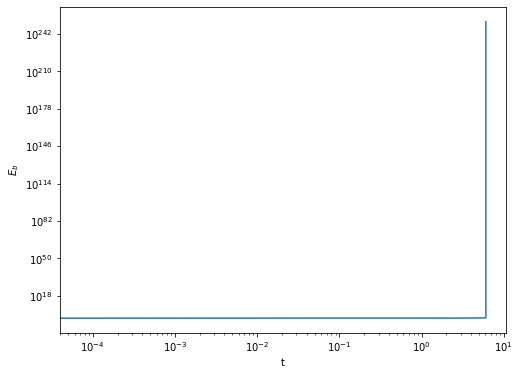

In [37]:
plt.figure(figsize = (8,6))
plt.loglog(t,Eb)
plt.xlabel('t')
plt.ylabel(r'$E_b$')

Text(0, 0.5, '$E_t$')

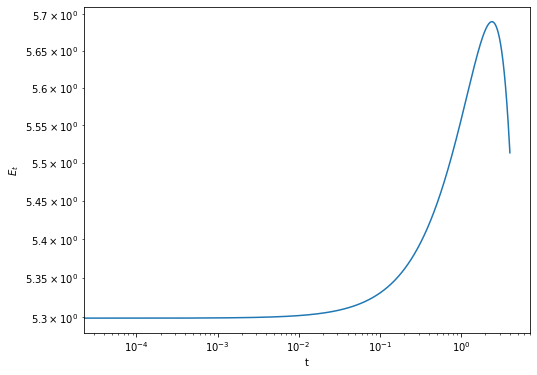

In [23]:
plt.figure(figsize = (8,6))
plt.loglog(t,et)
plt.xlabel('t')
plt.ylabel(r'$E_t$')

Text(0, 0.5, 'u')

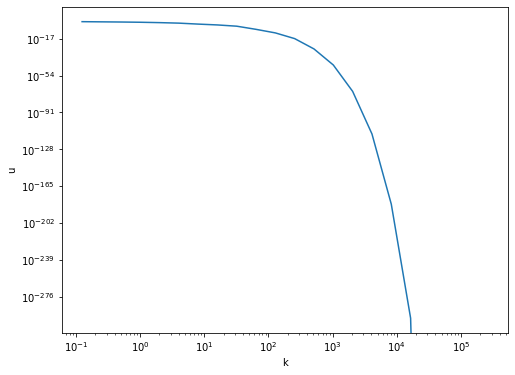

In [24]:
plt.figure(figsize = (8,6))
plt.loglog(k,u[-1])
plt.xlabel('k')
plt.ylabel('u')

Text(0, 0.5, 'b')

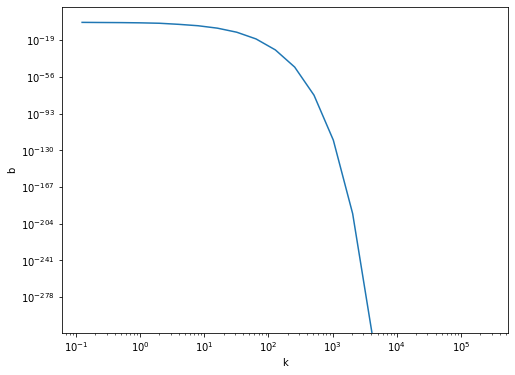

In [18]:
plt.figure(figsize = (8,6))
plt.loglog(k,b[-1])
plt.xlabel('k')
plt.ylabel('b')